In [1]:
%%javascript 
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [2]:
# lib
import os
import gc
import random
import math
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader, Dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

import warnings
warnings.filterwarnings("ignore")

from fastprogress import master_bar, progress_bar
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

if not os.path.exists('models1'):
    os.mkdir('models1')


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


SEED = 777
seed_everything(SEED)

torch.__version__

'1.7.0'

In [3]:
data_path = '../input/lish-moa/'

In [4]:
def get_logger(filename='log', save=True):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    
    if save:
        handler2 = FileHandler(filename=f"{filename}.log")
        handler2.setFormatter(Formatter("%(message)s"))  
        logger.addHandler(handler2)
    return logger

logger = get_logger(nb_name[:-6])
logger.info(f'file_name: {nb_name[:-6]}')
logger.info(f'Time: {time.ctime()}')
logger.info(f'Set seed: {SEED}')

file_name: 01_baseline-opt-Constant-wd
Time: Tue Nov 17 19:56:41 2020
Set seed: 777


# load df

In [5]:
# load df
# train_df
trn_feature = pd.read_csv(data_path + 'train_features.csv')
print(trn_feature.shape)

# train_df_target
trn_tar_df = pd.read_csv(data_path + 'train_targets_scored.csv')
print(trn_tar_df.shape)

# test_df
test_df = pd.read_csv(data_path + 'test_features.csv')
print(test_df.shape)

# sub_df
sub_df = pd.read_csv(data_path + 'sample_submission.csv')
print(sub_df.shape)

# label column keys
y_keys = list(trn_tar_df.keys())[1:];

# numerical col
genes = [col for col in trn_feature.columns if col.startswith('g-')]
cells = [col for col in trn_feature.columns if col.startswith('c-')]

# catgoriacal col
cat_col = ['cp_time', 'cp_dose']

(23814, 876)
(23814, 207)
(3982, 876)
(3982, 207)


In [6]:
# create df without ctl_vehicle in cp_type
trn_df = trn_feature.merge(trn_tar_df, on='sig_id')
trn_df = trn_df[trn_df.cp_type !='ctl_vehicle'].reset_index(drop=True)
test_df = test_df[test_df.cp_type !='ctl_vehicle'].reset_index(drop=True)
print(trn_df.shape, test_df.shape)
trn_df.sample(20)

(21948, 1082) (3624, 876)


sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
14261  id_a6a4f3626  trt_cp       24      D2 -0.3265  0.1577 -0.3381  0.1789   
14266  id_a6b456ebb  trt_cp       24      D1 -0.7239  0.0713  0.2250  0.5864   
5119   id_3bd739795  trt_cp       24      D1  0.5283  1.2350  2.7150 -0.0206   
692    id_07b7426b2  trt_cp       24      D1 -0.2856 -0.6573  1.8890 -0.3083   
6833   id_4fbf1ada4  trt_cp       72      D2  0.9492 -0.5027 -0.0934 -2.2830   
7051   id_52620ac73  trt_cp       24      D1 -0.4717 -0.2592 -0.5129  0.0462   
13131  id_995a3b2d4  trt_cp       48      D1  2.4190 -1.1380 -0.4596 -0.1602   
2435   id_1c33757b3  trt_cp       24      D1 -0.0171 -0.0432 -0.4036 -0.6486   
10021  id_7514b50fb  trt_cp       48      D1  0.5772  0.8006  1.5080 -0.8161   
13768  id_a0ad27715  trt_cp       48      D2  0.2120  0.2485  1.0300 -1.0730   
18518  id_d7bb3adc4  trt_cp       48      D1 -0.7536 -0.5321 -0.1516 -0.0495   
20041  id_e91fab646  trt_cp       72      D2 -0.6309  0.4781 -2.6910  0.2385   
18117  id_d31c9e94e  trt_cp       48      D1  0.7976  1.0440  0.2952 -0.5905   
15504  id_b4cc111bb  trt_cp       48      D1 -0.5976 -1.1690 -0.4103  0.5798   
5556   id_412140e64  trt_cp       24      D1 -0.5952 -0.9559  2.4630 -0.0315   
21588  id_fbd8dbcad  trt_cp       72      D2 -0.2161 -1.4290  0.4589  1.0030   
15360  id_b31db9325  trt_cp       48      D1 -0.0374 -1.0160  1.9580 -0.4785   
11138  id_821c17c40  trt_cp       24      D2 -0.0261  0.1104 -0.1617 -0.3219   
8190   id_60006934f  trt_cp       48      D1  0.1364 -1.3170 -0.8553  0.1797   
2259   id_1a17c635a  trt_cp       72      D1 -1.0280 -0.8049 -1.0320  0.1032   

          g-4     g-5  ...  tropomyosin_receptor_kinase_inhibitor  \
14261  0.2595  0.7117  ...                                      0   
14266  2.6280 -0.4762  ...                                      0   
5119   0.5865  0.2824  ...                                      0   
692   -0.5899  0.5369  ...                                      0   
6833  -0.1903  0.0230  ...                                      0   
7051   0.5863 -0.6585  ...                                      0   
13131  2.5480  1.5230  ...                                      0   
2435  -0.7183 -0.5947  ...                                      0   
10021 -0.1879 -0.1965  ...                                      0   
13768 -0.0180 -1.7210  ...                                      0   
18518  1.0390  0.0809  ...                                      0   
20041 -0.3716 -1.7600  ...                                      0   
18117 -0.1289 -0.0398  ...                                      0   
15504 -1.1120 -0.5922  ...                                      0   
5556  -1.1080 -0.4219  ...                                      1   
21588 -0.4092 -0.3814  ...                                      0   
15360 -1.9240  0.4834  ...                                      0   
11138 -0.3690 -0.3912  ...                                      0   
8190  -0.3682  0.3688  ...                                      0   
2259  -1.0780  0.4771  ...                                      0   

       trpv_agonist  trpv_antagonist  tubulin_inhibitor  \
14261             0                0                  0   
14266             0                0                  0   
5119              0                0                  0   
692               0                0                  0   
6833              0                0                  0   
7051              0                0                  0   
13131             0                0                  0   
2435              0                0                  0   
10021             0                0                  0   
13768             0                0                  0   
18518             0                0                  0   
20041             0                0                  0   
18117             0                0                  0   
15504             0                0                  0 

# cv

In [7]:
# kfolds index
folds = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for n, (trn_idx, val_idx) in enumerate(folds.split(trn_df, trn_df[y_keys])):
    print(trn_idx, val_idx)

[    0     1     2 ... 21945 21946 21947] [    3    15    21 ... 21939 21942 21944]
[    1     2     3 ... 21944 21945 21947] [    0     4     7 ... 21934 21936 21946]
[    0     2     3 ... 21945 21946 21947] [    1    14    18 ... 21928 21940 21943]
[    0     1     2 ... 21944 21946 21947] [    8     9    10 ... 21920 21932 21945]
[    0     1     3 ... 21944 21945 21946] [    2     5     6 ... 21937 21941 21947]


# dataset

In [8]:
class TrainDataset(Dataset):
    def __init__(self, df, features_col, labels_col):
        self.features = torch.FloatTensor(df[features_col].values).to(device)
        self.labels = torch.tensor(df[labels_col].values).float().to(device)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]

        return x, y


class TestDataset(Dataset):
    def __init__(self, df, features_col):
        self.features = torch.FloatTensor(df[features_col].values)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx].to(device)

        return x

In [9]:
cat_features = ['cp_time', 'cp_dose']
feature_cols = genes + cells + cat_features


def cate2num(df):
    df['cp_time'] = df['cp_time'].map({24: 0, 48: 1, 72: 2})
    df['cp_dose'] = df['cp_dose'].map({'D1': 1, 'D2': 0})
    return df


trn_df = cate2num(trn_df)
test_df = cate2num(test_df)

In [10]:
# debug ds, dl
trn_dataset = TrainDataset(trn_df.iloc[trn_idx], feature_cols, y_keys)
test_dataset = TestDataset(test_df, feature_cols)

trn_loader = DataLoader(trn_dataset,
                        batch_size=32,
                        shuffle=True,
                        drop_last=True)
test_loader = DataLoader(test_dataset,
                         batch_size=32,
                         shuffle=False,
                         drop_last=False)

for xs, ys in trn_loader: 
    print(xs.shape, ys.shape)
    break
for xs in test_loader: 
    print(xs.shape)
    break

torch.Size([32, 874]) torch.Size([32, 206])
torch.Size([32, 874])


# model

In [11]:
class CFG:
    max_grad_norm = 1000
    hidden_size = 256
    dropout = 0.5
    lr = 7e-3
    wd = 1e-3
    bs = 32
    epochs = 30
    smooth = 0.0005
    feature_cols = feature_cols
    target_cols = y_keys
    optimizer = None
    scheduler = None 

In [12]:
class MLP(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.h1 = nn.Sequential(
            nn.Linear(len(cfg.feature_cols), cfg.hidden_size),
            nn.Hardswish(inplace=True),
            nn.BatchNorm1d(cfg.hidden_size), 
            nn.Dropout(cfg.dropout))
        
        self.h2 = nn.Sequential(
            nn.Linear(cfg.hidden_size, cfg.hidden_size),
            nn.Hardswish(inplace=True),
            nn.BatchNorm1d(cfg.hidden_size),
            nn.Dropout(cfg.dropout),
        )
        self.h3 = nn.Linear(cfg.hidden_size, len(cfg.target_cols))

    def forward(self, x):
        x = self.h1(x)
        x = self.h2(x)
        return self.h3(x)

In [13]:
def compute_metric(preds, ys):
    esp = 1e-15
    preds = np.clip(preds, esp, 1 - esp)
    score = -np.mean(np.mean(
        ys * np.log(preds + esp) + (1 - ys) * np.log(1 - preds + esp), axis=1),
                     axis=0)
    return score


def smoothing_critirion(smooth=0.0):
    assert 0 <= smooth < 1, 'smooth not in range'

    def smoothing(criterion):
        def warp(preds, ys):
            with torch.no_grad():
                ys = ys * (1.0 - smooth) + 0.5 * smooth
            return criterion(preds, ys)

        return warp

    return smoothing


@smoothing_critirion(smooth=CFG.smooth)
def criterion(preds, ys):
    return F.binary_cross_entropy_with_logits(preds, ys)

In [14]:
import torch_optimizer

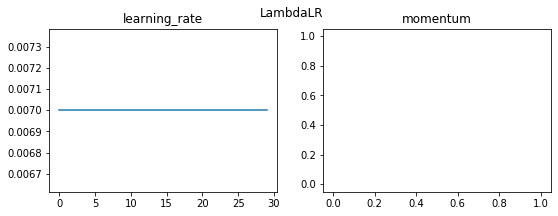

In [15]:
# show_learning_rate_scheduler
#%%capture --no-display
optim_param = {'lr': CFG.lr, 'weight_decay': CFG.wd}
CFG.optimizer = torch_optimizer.Yogi
CFG.optim_param = optim_param

scheduler_param = {
    'lr_lambda': lambda epoch: 1,
}
CFG.scheduler = optim.lr_scheduler.LambdaLR
CFG.scheduler_param = scheduler_param


cfg = CFG
model = MLP(cfg).to(device)
optimizer = cfg.optimizer(model.parameters(), **cfg.optim_param)
scheduler = cfg.scheduler(optimizer, **cfg.scheduler_param)

def show_learning_rate_scheduler():
    lrs = []
    moms = []
    if scheduler.__class__.__name__ == 'OneCycleLR':
        step = cfg.epochs* len(trn_loader)
    else:
        step = cfg.epochs
    
    for i in range(step):
        optimizer.step()
        lrs.append(scheduler.optimizer.param_groups[0]['lr'])
        #moms.append(scheduler.optimizer.param_groups[0]['betas'][0])
        scheduler.step()

    plt.figure(figsize=(9, 3))
    plt.suptitle(scheduler.__class__.__name__)
    plt.subplot(121)
    plt.title('learning_rate')
    plt.plot(lrs)
    plt.subplot(122)
    plt.title('momentum')
    plt.plot(moms)


show_learning_rate_scheduler()

# optimizer

In [16]:
from tabulate import tabulate
from colorama import Fore, Back, Style

version_higher = (torch.__version__ >= "1.5.0")

class AdaBelief(Optimizer):
    r"""Implements AdaBelief algorithm. Modified from Adam in PyTorch
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-16)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
        weight_decouple (boolean, optional): ( default: True) If set as True, then
            the optimizer uses decoupled weight decay as in AdamW
        fixed_decay (boolean, optional): (default: False) This is used when weight_decouple
            is set as True.
            When fixed_decay == True, the weight decay is performed as
            $W_{new} = W_{old} - W_{old} \times decay$.
            When fixed_decay == False, the weight decay is performed as
            $W_{new} = W_{old} - W_{old} \times decay \times lr$. Note that in this case, the
            weight decay ratio decreases with learning rate (lr).
        rectify (boolean, optional): (default: True) If set as True, then perform the rectified
            update similar to RAdam
        degenerated_to_sgd (boolean, optional) (default:True) If set as True, then perform SGD update
            when variance of gradient is high
    reference: AdaBelief Optimizer, adapting stepsizes by the belief in observed gradients, NeurIPS 2020
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-16,
                 weight_decay=0,
                 amsgrad=False,
                 weight_decouple=True,
                 fixed_decay=False,
                 rectify=True,
                 degenerated_to_sgd=True):

        # ------------------------------------------------------------------------------
        # Print modifications to default arguments
        print(
            Fore.RED +
            'Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.'
        )
        print(Fore.RED + 'Modifications to default arguments:')
        default_table = tabulate(
            [['adabelief-pytorch=0.0.5', '1e-8', 'False', 'False'],
             ['Current version (0.1.0)', '1e-16', 'True', 'True']],
            headers=['eps', 'weight_decouple', 'rectify'])
        print(Fore.RED + default_table)

        print(Fore.RED +
              'For a complete table of recommended hyperparameters, see')
        print(Fore.RED +
              'https://github.com/juntang-zhuang/Adabelief-Optimizer')

        print(Style.RESET_ALL)
        # ------------------------------------------------------------------------------

        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))

        self.degenerated_to_sgd = degenerated_to_sgd
        if isinstance(params,
                      (list, tuple)) and len(params) > 0 and isinstance(
                          params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0]
                                         or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]

        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        amsgrad=amsgrad,
                        buffer=[[None, None, None] for _ in range(10)])
        super(AdaBelief, self).__init__(params, defaults)

        self.degenerated_to_sgd = degenerated_to_sgd
        self.weight_decouple = weight_decouple
        self.rectify = rectify
        self.fixed_decay = fixed_decay
        if self.weight_decouple:
            print('Weight decoupling enabled in AdaBelief')
            if self.fixed_decay:
                print('Weight decay fixed')
        if self.rectify:
            print('Rectification enabled in AdaBelief')
        if amsgrad:
            print('AMSGrad enabled in AdaBelief')

    def __setstate__(self, state):
        super(AdaBelief, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    def reset(self):
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                amsgrad = group['amsgrad']

                # State initialization
                state['step'] = 0
                # Exponential moving average of gradient values
                state['exp_avg'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                    if version_higher else torch.zeros_like(p.data)

                # Exponential moving average of squared gradient values
                state['exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                    if version_higher else torch.zeros_like(p.data)

                if amsgrad:
                    # Maintains max of all exp. moving avg. of sq. grad. values
                    state['max_exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                        if version_higher else torch.zeros_like(p.data)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'AdaBelief does not support sparse gradients, please consider SparseAdam instead'
                    )
                amsgrad = group['amsgrad']

                state = self.state[p]

                beta1, beta2 = group['betas']

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                        if version_higher else torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                        if version_higher else torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                            if version_higher else torch.zeros_like(p.data)

                # get current state variable
                exp_avg, exp_avg_var = state['exp_avg'], state['exp_avg_var']

                state['step'] += 1
                bias_correction1 = 1 - beta1**state['step']
                bias_correction2 = 1 - beta2**state['step']

                # Update first and second moment running average
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                grad_residual = grad - exp_avg
                exp_avg_var.mul_(beta2).addcmul_(grad_residual,
                                                 grad_residual,
                                                 value=1 - beta2)

                if amsgrad:
                    max_exp_avg_var = state['max_exp_avg_var']
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_var,
                              exp_avg_var,
                              out=max_exp_avg_var)

                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_var.add_(group['eps']).sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_var.add_(group['eps']).sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])

                # perform weight decay, check if decoupled weight decay
                if self.weight_decouple:
                    if not self.fixed_decay:
                        p.data.mul_(1.0 - group['lr'] * group['weight_decay'])
                    else:
                        p.data.mul_(1.0 - group['weight_decay'])
                else:
                    if group['weight_decay'] != 0:
                        grad.add_(p.data, alpha=group['weight_decay'])

                # update
                if not self.rectify:
                    # Default update
                    step_size = group['lr'] / bias_correction1
                    p.data.addcdiv_(exp_avg, denom, value=-step_size)

                else:  # Rectified update, forked from RAdam
                    buffered = group['buffer'][int(state['step'] % 10)]
                    if state['step'] == buffered[0]:
                        N_sma, step_size = buffered[1], buffered[2]
                    else:
                        buffered[0] = state['step']
                        beta2_t = beta2**state['step']
                        N_sma_max = 2 / (1 - beta2) - 1
                        N_sma = N_sma_max - 2 * state['step'] * beta2_t / (
                            1 - beta2_t)
                        buffered[1] = N_sma

                        # more conservative since it's an approximated value
                        if N_sma >= 5:
                            step_size = math.sqrt(
                                (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                                (N_sma - 2) / N_sma * N_sma_max /
                                (N_sma_max - 2)) / (1 - beta1**state['step'])
                        elif self.degenerated_to_sgd:
                            step_size = 1.0 / (1 - beta1**state['step'])
                        else:
                            step_size = -1
                        buffered[2] = step_size

                    if N_sma >= 5:
                        denom = exp_avg_var.sqrt().add_(group['eps'])
                        p.data.addcdiv_(exp_avg,
                                        denom,
                                        value=-step_size * group['lr'])
                    elif step_size > 0:
                        p.data.add_(exp_avg, alpha=-step_size * group['lr'])

        return loss

In [17]:
class PlainRAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

        super(PlainRAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(PlainRAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                beta2_t = beta2 ** state['step']
                N_sma_max = 2 / (1 - beta2) - 1
                N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:                    
                    step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    step_size = group['lr'] / (1 - beta1 ** state['step'])
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss


class AdamW(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, warmup = 0):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, warmup = warmup)
        super(AdamW, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AdamW, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                
                if group['warmup'] > state['step']:
                    scheduled_lr = 1e-8 + state['step'] * group['lr'] / group['warmup']
                else:
                    scheduled_lr = group['lr']

                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1
                
                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * scheduled_lr, p_data_fp32)

                p_data_fp32.addcdiv_(-step_size, exp_avg, denom)

                p.data.copy_(p_data_fp32)

        return loss


class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:            
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

# RAdam + LARS
class Ralamb(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(Ralamb, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Ralamb, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Ralamb does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # Decay the first and second moment running average coefficient
                # m_t
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                # v_t
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, radam_step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        radam_step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        radam_step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = radam_step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                radam_step = p_data_fp32.clone()
                if N_sma >= 5:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    radam_step.addcdiv_(-radam_step_size * group['lr'], exp_avg, denom)
                else:
                    radam_step.add_(-radam_step_size * group['lr'], exp_avg)

                radam_norm = radam_step.pow(2).sum().sqrt()
                weight_norm = p.data.pow(2).sum().sqrt().clamp(0, 10)
                if weight_norm == 0 or radam_norm == 0:
                    trust_ratio = 1
                else:
                    trust_ratio = weight_norm / radam_norm

                state['weight_norm'] = weight_norm
                state['adam_norm'] = radam_norm
                state['trust_ratio'] = trust_ratio

                if N_sma >= 5:
                    p_data_fp32.addcdiv_(-radam_step_size * group['lr'] * trust_ratio, exp_avg, denom)
                else:
                    p_data_fp32.add_(-radam_step_size * group['lr'] * trust_ratio, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss
    

def Ranger(params, alpha=0.5, k=6, *args, **kwargs):
    radam = RAdam(params, *args, **kwargs)
    return Lookahead(radam, alpha, k)


def RangerLars(params, alpha=0.5, k=6, *args, **kwargs):
    ralamb = Ralamb(params, *args, **kwargs)
    return Lookahead(ralamb, alpha, k)

In [18]:
# CG
# https://github.com/Yonghongwei/Gradient-Centralization
def centralized_gradient(x, use_gc=True, gc_conv_only=False):
    if use_gc:
        if gc_conv_only:
            if len(list(x.size())) > 3:
                x.add_(-x.mean(dim=tuple(range(1, len(list(x.size())))),
                               keepdim=True))
        else:
            if len(list(x.size())) > 1:
                x.add_(-x.mean(dim=tuple(range(1, len(list(x.size())))),
                               keepdim=True))
    return x

class Adam_CG(Optimizer):
    r"""Implements Adam algorithm.
    It has been proposed in `Adam: A Method for Stochastic Optimization`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=0,
                 amsgrad=False,
                 use_gc=False,
                 gc_conv_only=False,
                 gc_loc=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError(
                "Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        amsgrad=amsgrad)
        super(Adam_CG, self).__init__(params, defaults)
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only

    def __setstate__(self, state):
        super(Adam_CG, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead'
                    )
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(
                            p, memory_format=torch.preserve_format)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1
                bias_correction1 = 1 - beta1**state['step']
                bias_correction2 = 1 - beta2**state['step']

                if group['weight_decay'] != 0:
                    grad = grad.add(p, alpha=group['weight_decay'])
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])

                step_size = group['lr'] / bias_correction1
                #GC operation
                G_grad = exp_avg / denom
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p.add_(G_grad, alpha=-step_size)

        return loss


class AdamW_CG(Optimizer):
    r"""Implements AdamW algorithm.
    The original Adam algorithm was proposed in `Adam: A Method for Stochastic Optimization`_.
    The AdamW variant was proposed in `Decoupled Weight Decay Regularization`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay coefficient (default: 1e-2)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _Decoupled Weight Decay Regularization:
        https://arxiv.org/abs/1711.05101
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=1e-2,
                 amsgrad=False,
                 use_gc=True,
                 gc_conv_only=False,
                 gc_loc=True):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError(
                "Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        amsgrad=amsgrad)
        super(AdamW_CG, self).__init__(params, defaults)
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only

    def __setstate__(self, state):
        super(AdamW_CG, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                # Perform optimization step
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError(
                        'AdamW does not support sparse gradients')
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(
                            p, memory_format=torch.preserve_format)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1
                bias_correction1 = 1 - beta1**state['step']
                bias_correction2 = 1 - beta2**state['step']
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])

                step_size = group['lr'] / bias_correction1

                #GC operation and stepweight decay
                G_grad = (exp_avg / denom).add(p.data,
                                               alpha=group['weight_decay'])
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p.add_(G_grad, alpha=-step_size)

        return loss


class PlainRAdam_CG(Optimizer):
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=0,
                 degenerated_to_sgd=True,
                 use_gc=True,
                 gc_conv_only=False,
                 gc_loc=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))

        self.degenerated_to_sgd = degenerated_to_sgd
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

        super(PlainRAdam_CG, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(PlainRAdam_CG, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError(
                        'RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                state['step'] += 1
                beta2_t = beta2**state['step']
                N_sma_max = 2 / (1 - beta2) - 1
                N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    #if group['weight_decay'] != 0:
                    #    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    step_size = group['lr'] * math.sqrt(
                        (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                        (N_sma - 2) / N_sma * N_sma_max /
                        (N_sma_max - 2)) / (1 - beta1**state['step'])
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    G_grad = exp_avg / denom

                elif self.degenerated_to_sgd:
                    #if group['weight_decay'] != 0:
                    #    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    step_size = group['lr'] / (1 - beta1**state['step'])
                    G_grad = exp_avg

                if group['weight_decay'] != 0:
                    G_grad.add_(p.data, alpha=group['weight_decay'])

                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p_data_fp32.add_(G_grad, alpha=-step_size * group['lr'])
                #p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                p.data.copy_(p_data_fp32)
        return loss


class RAdam_CG(Optimizer):
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=0,
                 degenerated_to_sgd=True,
                 use_gc=True,
                 gc_conv_only=False,
                 gc_loc=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))

        self.degenerated_to_sgd = degenerated_to_sgd
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only

        if isinstance(params,
                      (list, tuple)) and len(params) > 0 and isinstance(
                          params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0]
                                         or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]
        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        buffer=[[None, None, None] for _ in range(10)])
        super(RAdam_CG, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam_CG, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError(
                        'RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                state['step'] += 1
                buffered = group['buffer'][int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2**state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 -
                                                                       beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt(
                            (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                            (N_sma - 2) / N_sma * N_sma_max /
                            (N_sma_max - 2)) / (1 - beta1**state['step'])
                    elif self.degenerated_to_sgd:
                        step_size = 1.0 / (1 - beta1**state['step'])
                    else:
                        step_size = -1
                    buffered[2] = step_size

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    G_grad = exp_avg / denom
                elif step_size > 0:
                    G_grad = exp_avg

                if group['weight_decay'] != 0:
                    G_grad.add_(p_data_fp32, alpha=group['weight_decay'])
                #GC operation
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)
                p_data_fp32.add_(G_grad, alpha=-step_size * group['lr'])
                #p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                p.data.copy_(p_data_fp32)
        return loss


class Ranger_CG(Optimizer):
    def __init__(
            self,
            params,
            lr=1e-3,  # lr
            alpha=0.5,
            k=6,
            N_sma_threshhold=5,  # Ranger options
            betas=(.95, 0.999),
            eps=1e-5,
            weight_decay=0,  # Adam options
            # Gradient centralization on or off, applied to conv layers only or conv + fc layers
            use_gc=True,
            gc_conv_only=False,
            gc_loc=False):

        # parameter checks
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        if not lr > 0:
            raise ValueError(f'Invalid Learning Rate: {lr}')
        if not eps > 0:
            raise ValueError(f'Invalid eps: {eps}')

        # parameter comments:
        # beta1 (momentum) of .95 seems to work better than .90...
        # N_sma_threshold of 5 seems better in testing than 4.
        # In both cases, worth testing on your dataset (.90 vs .95, 4 vs 5) to make sure which works best for you.

        # prep defaults and init torch.optim base
        defaults = dict(lr=lr,
                        alpha=alpha,
                        k=k,
                        step_counter=0,
                        betas=betas,
                        N_sma_threshhold=N_sma_threshhold,
                        eps=eps,
                        weight_decay=weight_decay)
        super().__init__(params, defaults)

        # adjustable threshold
        self.N_sma_threshhold = N_sma_threshhold

        # look ahead params

        self.alpha = alpha
        self.k = k

        # radam buffer for state
        self.radam_buffer = [[None, None, None] for ind in range(10)]

        # gc on or off
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only
        # level of gradient centralization
        #self.gc_gradient_threshold = 3 if gc_conv_only else 1

        print(
            f"Ranger optimizer loaded. \nGradient Centralization usage = {self.use_gc}"
        )
        if (self.use_gc and self.gc_conv_only == False):
            print(f"GC applied to both conv and fc layers")
        elif (self.use_gc and self.gc_conv_only == True):
            print(f"GC applied to conv layers only")

    def __setstate__(self, state):
        print("set state called")
        super(Ranger, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        # note - below is commented out b/c I have other work that passes back the loss as a float, and thus not a callable closure.
        # Uncomment if you need to use the actual closure...

        # if closure is not None:
        #loss = closure()

        # Evaluate averages and grad, update param tensors
        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()

                if grad.is_sparse:
                    raise RuntimeError(
                        'Ranger optimizer does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]  # get state dict for this param

                if len(
                        state
                ) == 0:  # if first time to run...init dictionary with our desired entries
                    # if self.first_run_check==0:
                    # self.first_run_check=1
                    #print("Initializing slow buffer...should not see this at load from saved model!")
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)

                    # look ahead weight storage now in state dict
                    state['slow_buffer'] = torch.empty_like(p.data)
                    state['slow_buffer'].copy_(p.data)

                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                # begin computations
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # GC operation for Conv layers and FC layers
                #if grad.dim() > self.gc_gradient_threshold:
                #    grad.add_(-grad.mean(dim=tuple(range(1, grad.dim())), keepdim=True))
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                state['step'] += 1

                # compute variance mov avg
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # compute mean moving avg
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

                buffered = self.radam_buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2**state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * \
                        state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma
                    if N_sma > self.N_sma_threshhold:
                        step_size = math.sqrt(
                            (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                            (N_sma - 2) / N_sma * N_sma_max /
                            (N_sma_max - 2)) / (1 - beta1**state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1**state['step'])
                    buffered[2] = step_size

                #if group['weight_decay'] != 0:
                #    p_data_fp32.add_(-group['weight_decay']
                #                     * group['lr'], p_data_fp32)

                # apply lr
                if N_sma > self.N_sma_threshhold:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    G_grad = exp_avg / denom
                else:
                    G_grad = exp_avg

                if group['weight_decay'] != 0:
                    G_grad.add_(p_data_fp32, alpha=group['weight_decay'])
                #GC operation
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p_data_fp32.add_(G_grad, alpha=-step_size * group['lr'])
                p.data.copy_(p_data_fp32)

                # integrated look ahead...
                # we do it at the param level instead of group level
                if state['step'] % group['k'] == 0:
                    # get access to slow param tensor
                    slow_p = state['slow_buffer']
                    # (fast weights - slow weights) * alpha
                    slow_p.add_(p.data - slow_p, alpha=self.alpha)
                    # copy interpolated weights to RAdam param tensor
                    p.data.copy_(slow_p)

        return loss

In [19]:
from collections import defaultdict

class Lookahead(Optimizer):
    def __init__(self, base_optimizer, alpha=0.5, k=6):
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        defaults = dict(lookahead_alpha=alpha, lookahead_k=k, lookahead_step=0)
        self.base_optimizer = base_optimizer
        self.param_groups = self.base_optimizer.param_groups
        self.defaults = base_optimizer.defaults
        self.defaults.update(defaults)
        self.state = defaultdict(dict)
        # manually add our defaults to the param groups
        for name, default in defaults.items():
            for group in self.param_groups:
                group.setdefault(name, default)

    def update_slow(self, group):
        for fast_p in group["params"]:
            if fast_p.grad is None:
                continue
            param_state = self.state[fast_p]
            if 'slow_buffer' not in param_state:
                param_state['slow_buffer'] = torch.empty_like(fast_p.data)
                param_state['slow_buffer'].copy_(fast_p.data)
            slow = param_state['slow_buffer']
            slow.add_(group['lookahead_alpha'], fast_p.data - slow)
            fast_p.data.copy_(slow)

    def sync_lookahead(self):
        for group in self.param_groups:
            self.update_slow(group)

    def step(self, closure=None):
        # print(self.k)
        #assert id(self.param_groups) == id(self.base_optimizer.param_groups)
        loss = self.base_optimizer.step(closure)
        for group in self.param_groups:
            group['lookahead_step'] += 1
            if group['lookahead_step'] % group['lookahead_k'] == 0:
                self.update_slow(group)
        return loss

    def state_dict(self):
        fast_state_dict = self.base_optimizer.state_dict()
        slow_state = {(id(k) if isinstance(k, torch.Tensor) else k): v
                      for k, v in self.state.items()}
        fast_state = fast_state_dict['state']
        param_groups = fast_state_dict['param_groups']
        return {
            'state': fast_state,
            'slow_state': slow_state,
            'param_groups': param_groups,
        }

    def load_state_dict(self, state_dict):
        fast_state_dict = {
            'state': state_dict['state'],
            'param_groups': state_dict['param_groups'],
        }
        self.base_optimizer.load_state_dict(fast_state_dict)

        # We want to restore the slow state, but share param_groups reference
        # with base_optimizer. This is a bit redundant but least code
        slow_state_new = False
        if 'slow_state' not in state_dict:
            print(
                'Loading state_dict from optimizer without Lookahead applied.')
            state_dict['slow_state'] = defaultdict(dict)
            slow_state_new = True
        slow_state_dict = {
            'state': state_dict['slow_state'],
            'param_groups':
            state_dict['param_groups'],  # this is pointless but saves code
        }
        super(Lookahead, self).load_state_dict(slow_state_dict)
        self.param_groups = self.base_optimizer.param_groups  # make both ref same container
        if slow_state_new:
            # reapply defaults to catch missing lookahead specific ones
            for name, default in self.defaults.items():
                for group in self.param_groups:
                    group.setdefault(name, default)


def LookaheadAdam(params, alpha=0.5, k=6, *args, **kwargs):
    adam = optim.Adam(params, *args, **kwargs)
    return Lookahead(adam, alpha, k)  

def LookaheadAdam_CG(params, alpha=0.5, k=6, *args, **kwargs):
    adam = Adam_CG(params, *args, **kwargs)
    return Lookahead(adam, alpha, k) 


def LookaheadAdamW(params, alpha=0.5, k=6, *args, **kwargs):
    adam = AdamW(params, *args, **kwargs)
    return Lookahead(adam, alpha, k) 


def LookaheadDiffGrad(params, alpha=0.5, k=6, *args, **kwargs):
    diffgrad = torch_optimizer.DiffGrad(params, *args, **kwargs)
    return Lookahead(diffgrad, alpha, k)


def LookaheadYogi(params, alpha=0.5, k=6, *args, **kwargs):
    yogi = torch_optimizer.Yogi(params, *args, **kwargs)
    return Lookahead(yogi, alpha, k)

In [20]:
class Apollo(Optimizer):
    r"""Implements Atom algorithm.
        Arguments:
            params (iterable): iterable of parameters to optimize or dicts defining
                parameter groups
            lr (float): learning rate
            beta (float, optional): coefficient used for computing
                running averages of gradient (default: 0.9)
            eps (float, optional): term added to the denominator to improve
                numerical stability (default: 1e-4)
            warmup (int, optional): number of warmup steps (default: 0)
            init_lr (float, optional): initial learning rate for warmup (default: 0.01)
            weight_decay (float, optional): weight decay coefficient (default: 0)
        """

    def __init__(self, params, lr, beta=0.9, eps=1e-4, warmup=100, init_lr=0.01, weight_decay=0):
        if not 0.0 < lr:
            raise ValueError("Invalid learning rate value: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= beta < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(beta))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        if not 0.0 <= warmup:
            raise ValueError("Invalid warmup updates: {}".format(warmup))
        if not 0.0 <= init_lr <= 1.0:
            raise ValueError("Invalid initial learning rate: {}".format(init_lr))

        defaults = dict(lr=lr, beta=beta, eps=eps, warmup=warmup,
                        init_lr=init_lr, base_lr=lr, weight_decay=weight_decay)
        super(Apollo, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Apollo, self).__setstate__(state)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg_grad'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['approx_hessian'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    # Previous update direction
                    state['update'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                # Calculate current lr
                if state['step'] < group['warmup']:
                    curr_lr = (group['base_lr'] - group['init_lr']) * state['step'] / group['warmup'] + group['init_lr']
                else:
                    curr_lr = group['lr']

                # Perform optimization step
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError('Atom does not support sparse gradients.')

                # Perform step weight decay
                if group['weight_decay'] != 0:
                    grad = grad.add(p, alpha=group['weight_decay'])

                beta = group['beta']
                exp_avg_grad = state['exp_avg_grad']
                B = state['approx_hessian']
                d_p = state['update']

                state['step'] += 1
                bias_correction = 1 - beta ** state['step']
                alpha = (1 - beta) / bias_correction

                # Update the running average grad
                delta_grad = grad - exp_avg_grad
                exp_avg_grad.add_(delta_grad, alpha=alpha)

                denom = d_p.norm(p=4).add(group['eps'])
                d_p.div_(denom)
                v_sq = d_p.mul(d_p)
                delta = delta_grad.div_(denom).mul_(d_p).sum().mul(-alpha) - B.mul(v_sq).sum()

                # Update B
                B.addcmul_(v_sq, delta)

                # calc direction of parameter updates
                denom = B.abs().clamp_(min=1)
                d_p.copy_(exp_avg_grad.div(denom))

                p.add_(d_p, alpha=-curr_lr)

        return loss

In [21]:
optim_list = [
    Adam_CG, AdamW_CG, PlainRAdam_CG, RAdam_CG, Ranger_CG,
    #
    torch_optimizer.AggMo, Apollo, 
    torch_optimizer.PID, torch_optimizer.QHM, 
    torch_optimizer.SGDP, torch_optimizer.SGDW, 
    torch.optim.SGD,
    #
    AdaBelief, torch_optimizer.AdaBound, torch_optimizer.AdaMod, AdamW,
    torch_optimizer.AdamP, torch_optimizer.DiffGrad, torch_optimizer.Lamb,
    torch_optimizer.NovoGrad, PlainRAdam, torch_optimizer.QHAdam, RAdam,
    Ranger, torch_optimizer.RangerQH, torch_optimizer.RangerVA,
    torch_optimizer.SWATS, torch_optimizer.Yogi, torch.optim.Adam, 
    LookaheadAdam, LookaheadDiffGrad, LookaheadYogi, RangerLars
]

# train

In [22]:
def trn_fn(trn_loader, model, optimizer, scheduler, mb, history):

    running_loss = 0.0
    running_metric = 0.0
    m = 0

    model.train()

    trn_tqdm = progress_bar(trn_loader, total=int(len(trn_loader)), parent=mb)
    for i, (xs, ys) in enumerate(trn_tqdm):
        batch_size = len(xs)
        m += batch_size

        # forward, backward
        optimizer.zero_grad()
        preds = model(xs)
        loss = criterion(preds, ys)
        loss.backward()

        # clip grad
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(),
                                                   CFG.max_grad_norm)
        optimizer.step()
        if scheduler.__class__.__name__ == 'OneCycleLR':
            history['lrs'].append(scheduler.optimizer.param_groups[0]['lr'])
            scheduler.step() 

        # metric
        metric = compute_metric(preds.sigmoid().detach().cpu().numpy(), 
                                ys.detach().cpu().numpy())
        

        # to record
        running_loss += loss.item() * batch_size
        running_metric += metric * batch_size

        # set commet on child progressbar
        mb.child.comment = (f'loss={loss.item():.4f}, ' f'metric={metric:.4f}')
    
    # step if lr scheduler not onecycle
    if scheduler.__class__.__name__ != 'OneCycleLR':
        history['lrs'].append(scheduler.optimizer.param_groups[0]['lr'])
        scheduler.step()    
        
    return running_loss / m, running_metric / m


def val_fn(val_loader, model, mb):

    running_loss = 0.0
    running_metric = 0.0
    m = 0
    val_preds = []

    model.eval()
    
    val_tqdm = progress_bar(val_loader, total=int(len(val_loader)), parent=mb)
    for i, (xs, ys) in enumerate(val_tqdm):

        batch_size = len(xs)
        m += batch_size

        model.eval()

        # loss
        with torch.no_grad():
            preds = model(xs)
        loss = criterion(preds, ys)
        
        # metric
        preds = preds.sigmoid()
        metric = compute_metric(preds.detach().cpu().numpy(),
                                ys.detach().cpu().numpy())

        # to record
        running_loss += loss.item() * batch_size
        running_metric += metric * batch_size
        val_preds.append(preds.detach().cpu().numpy())

        # set commet on child progressbar
        mb.child.comment = (f'val_loss={loss.item():.4f}, '
                            f'val_metric={metric:.4f}')
        
    val_preds = np.concatenate(val_preds)
    return running_loss / m, running_metric / m, val_preds


def infer_fn(test_loader, model):

    model.eval()
    preds = []

    for i, xs in enumerate(test_loader):

        with torch.no_grad():
            pred = model(xs)
        
        pred = pred.sigmoid()
        preds.append(pred.detach().cpu().numpy())

    preds = np.concatenate(preds)

    return preds


def plot_history(history, fold_num=0):
    
    fig = plt.figure(figsize=(16, 3))
    fig.subplots_adjust(top=0.8)
    plt.suptitle(f'fold{fold_num}')
    
    # metrics
    plt.subplot(131)
    plt.ylim(0.01, 0.03)
    plt.plot(history['trn_metrics'], 'C0', label='train')
    plt.plot(history['val_metrics'], 'C1', label='val')
    plt.title(f'Metric')
    plt.legend()
    plt.ylabel("Metric") 
    plt.xlabel("Epoch")
    
    # loss
    plt.subplot(132)
    plt.ylim(0.01, 0.03)
    plt.plot(history['trn_losses'], 'C0', label='train')
    plt.plot(history['val_losses'], 'C1', label='val')
    plt.title(f'Loss')
    plt.legend()
    plt.ylabel("Loss") 
    plt.xlabel("Epoch")
    
    # lr
    plt.subplot(133)
    plt.plot(history['lrs'][1:], 'C0', label='lr')
    plt.title(f'Learning rate')
    plt.ylabel("Loss") 
    if history['lrs'] == 'OneCycleLR':
        plt.xlabel("Iteration")    
    else:
        plt.xlabel("Epoch")
    
    plt.show()

In [25]:
def run_single_nn(cfg,
                  trn_df,
                  test_df,
                  fold_idx,
                  feature_cols,
                  target_cols,
                  fold_num=0):
    
    # init
    best_loss = np.inf
    history = {
        'losses': [],
        'trn_losses': [],
        'trn_metrics': [],
        'val_losses': [],
        'val_metrics': [],
        'lrs': [],
    }
    mb = master_bar(range(1, cfg.epochs + 1))
    mb.write(('epoch', 'train loss', 'train metric', 'val loss', 'val metric',
              'time'),
             table=True)

    # loader
    trn_idx, val_idx = fold_idx
    trn_dataset = TrainDataset(trn_df.iloc[trn_idx], feature_cols, target_cols)
    val_dataset = TrainDataset(trn_df.iloc[val_idx], feature_cols, target_cols)
    trn_loader = DataLoader(trn_dataset,
                            batch_size=cfg.bs,
                            shuffle=True,
                            drop_last=True)
    val_loader = DataLoader(val_dataset,
                            batch_size=cfg.bs,
                            shuffle=False,
                            drop_last=False)

    # model
    model = MLP(cfg).to(device)
    optimizer = cfg.optimizer(model.parameters(), **cfg.optim_param)
    scheduler = cfg.scheduler(optimizer, **cfg.scheduler_param)
    history['lrs'].append(scheduler.__class__.__name__)

    # train & validate
    for epoch in mb:
        start_time = time.time()
        trn_loss, trn_metric = trn_fn(trn_loader, 
                                      model, 
                                      optimizer, 
                                      scheduler,
                                      mb, 
                                      history)
        val_loss, val_metric, val_preds = val_fn(val_loader, model, mb)

        # checkpoint
        if val_metric < best_loss:
            logger.info(f'epoch{epoch} save best model... {val_metric}')
            best_loss = val_metric
            oof = np.zeros((len(trn_df), len(cfg.target_cols)))
            oof[val_idx] = val_preds
            torch.save(model.state_dict(), f"fold{fold_num}_.pth")

        # calculate time
        end_time = time.time()
        m, s = divmod(end_time - start_time, 60)

        # record
        history['trn_losses'].append(trn_loss)
        history['trn_metrics'].append(trn_metric)
        history['val_losses'].append(val_loss)
        history['val_metrics'].append(val_metric)
        mb.write((f'{epoch}', f'{trn_loss:.6f}', f'{trn_metric:.10f}',
                  f'{val_loss:.6f}', f'{val_metric:.10f}', f'{m:.0f}:{s:.0f}'),
                 table=True)

    score = compute_metric(oof[val_idx],
                           trn_df.iloc[val_idx][target_cols].values)
    logger.info(f"fold{fold_num} score: {score}")
    plot_history(history, fold_num)

    # predictions
    test_dataset = TestDataset(test_df, feature_cols)
    test_loader = DataLoader(test_dataset,
                             batch_size=cfg.bs,
                             shuffle=False,
                             drop_last=False)

    model = MLP(cfg)
    #model.load_state_dict(torch.load(f"fold{fold_num}_.pth"))
    model.to(device)
    predictions = infer_fn(test_loader, model)

    # del
    torch.cuda.empty_cache()

    return oof, predictions


def run_kfold_nn(cfg, trn_df, test_df, feature_cols, target_cols, n_fold=5):

    oof = np.zeros((len(trn_df), len(cfg.target_cols)))
    predictions = np.zeros((len(test_df), len(cfg.target_cols)))

    folds = MultilabelStratifiedKFold(n_splits=5,
                                      shuffle=True,
                                      random_state=SEED)
    for fold_num, (fold_idx) in enumerate(folds.split(trn_df, trn_df[y_keys])):

        logger.info(f'fold {fold_num}')
        _oof, _predictions = run_single_nn(cfg,
                                           trn_df,
                                           test_df,
                                           fold_idx,
                                           cfg.feature_cols,
                                           cfg.target_cols,
                                           fold_num=fold_num)
        oof += _oof
        predictions += _predictions / n_fold

    score = compute_metric(oof, trn_df[y_keys].values)
    logger.info(f"CV score: {score}")

    return oof, predictions


optimizer: Adam_CG
fold 0


epoch1 save best model... 0.03222353380334676
epoch4 save best model... 0.03147130562819897
fold0 score: 0.03147130737207189


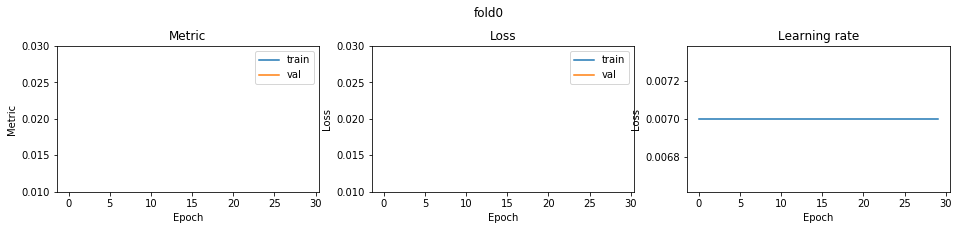

fold 1


epoch1 save best model... 0.032823872203964335
epoch2 save best model... 0.03204826333900198
epoch7 save best model... 0.03184404523097238
epoch29 save best model... 0.0317400864582856
fold1 score: 0.03174008670030461


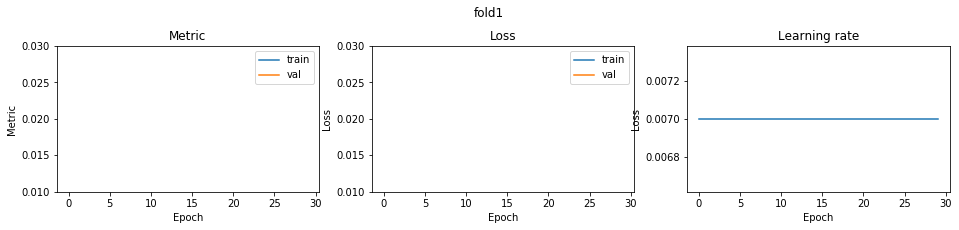

fold 2


epoch1 save best model... 0.03244075769425715
epoch3 save best model... 0.032351165520157564
epoch5 save best model... 0.031752879847851995
epoch20 save best model... 0.03164867849587226
epoch28 save best model... 0.031619974131714815
fold2 score: 0.031619973807146415


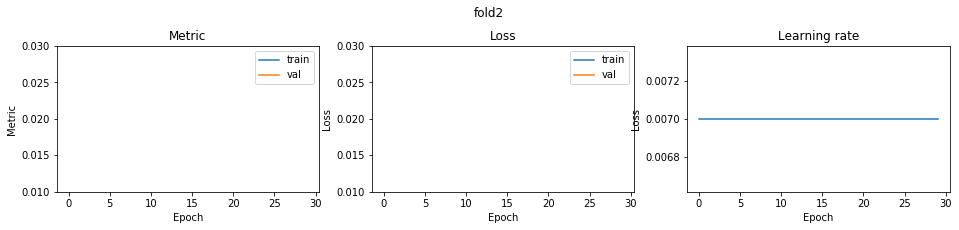

fold 3


epoch1 save best model... 0.03209922550700113
epoch11 save best model... 0.03174248925730552
fold3 score: 0.03174249089565203


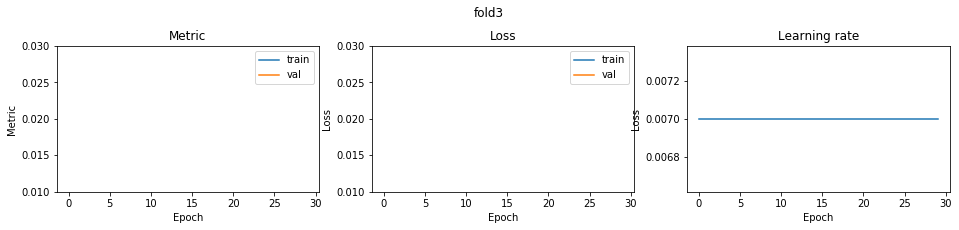

fold 4


epoch1 save best model... 0.03242121802511411
epoch2 save best model... 0.03229127361487962
epoch4 save best model... 0.032219286807780925
epoch5 save best model... 0.032154766784170494
epoch7 save best model... 0.0318987228044209
epoch10 save best model... 0.03177482147525003
epoch17 save best model... 0.03152533155995377
epoch25 save best model... 0.03142290114762435
fold4 score: 0.031422902289013045


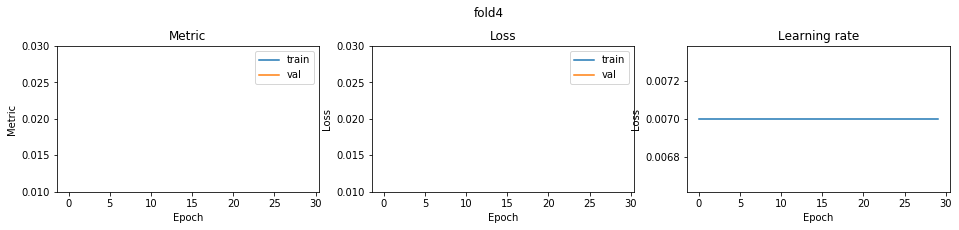

CV score: 0.03159934486109339

optimizer: AdamW_CG
fold 0


epoch1 save best model... 0.02040677650795575
epoch2 save best model... 0.018928240038505448
epoch3 save best model... 0.018315409813797555
epoch4 save best model... 0.017827099016050816
epoch5 save best model... 0.017557448524650788
epoch6 save best model... 0.017315202597571126
epoch7 save best model... 0.017101030583771323
epoch9 save best model... 0.016937103220060094
epoch10 save best model... 0.0168835380727718
epoch11 save best model... 0.01675940917927882
epoch12 save best model... 0.016712887263549216
epoch13 save best model... 0.016677836669027668
epoch14 save best model... 0.01664222194845014
epoch15 save best model... 0.01651664410541704
epoch16 save best model... 0.016497413139442377
epoch17 save best model... 0.016490791642143135
epoch20 save best model... 0.016429115987567397
epoch22 save best model... 0.016372384382984634
epoch23 save best model... 0.016339710494397305
epoch27 save best model... 0.016330855267635783
fold0 score: 0.01633085518334805


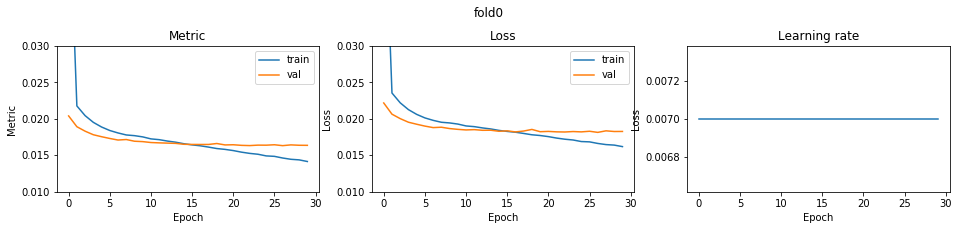

fold 1


epoch1 save best model... 0.020316019568547325
epoch2 save best model... 0.01887160653236122
epoch3 save best model... 0.018452277093426353
epoch4 save best model... 0.017987422736760125
epoch5 save best model... 0.017545392213520413
epoch6 save best model... 0.017385573680203863
epoch8 save best model... 0.017183462140657725
epoch9 save best model... 0.01705868123534207
epoch10 save best model... 0.01702298308531912
epoch12 save best model... 0.016980377876378662
epoch13 save best model... 0.016971769993269624
epoch14 save best model... 0.016951142910016603
epoch15 save best model... 0.016898879378832034
epoch16 save best model... 0.01682278538098583
epoch17 save best model... 0.016774167985956472
epoch20 save best model... 0.016621676935479265
fold1 score: 0.01662167682089531


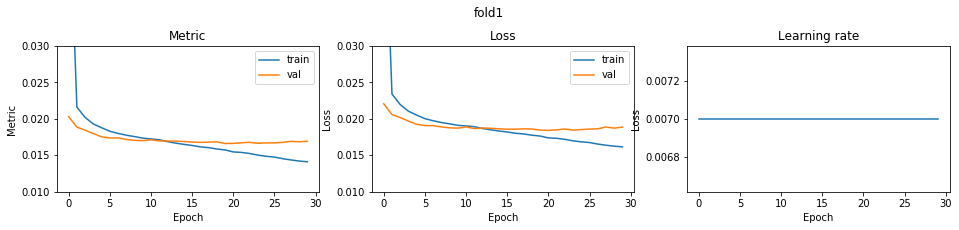

fold 2


epoch1 save best model... 0.02019105501826042
epoch2 save best model... 0.019240374053667363
epoch3 save best model... 0.018268052749140548
epoch4 save best model... 0.017889004213216434
epoch5 save best model... 0.017694941093123674
epoch6 save best model... 0.017509809010856296
epoch7 save best model... 0.017346782528337597
epoch8 save best model... 0.017123178330857598
epoch9 save best model... 0.017013461285118606
epoch11 save best model... 0.016875912211062997
epoch12 save best model... 0.016814142233238225
epoch13 save best model... 0.016596306357290837
epoch17 save best model... 0.01647983181489155
epoch21 save best model... 0.016457400974976933
epoch23 save best model... 0.01644064101063124
fold2 score: 0.016440640960750534


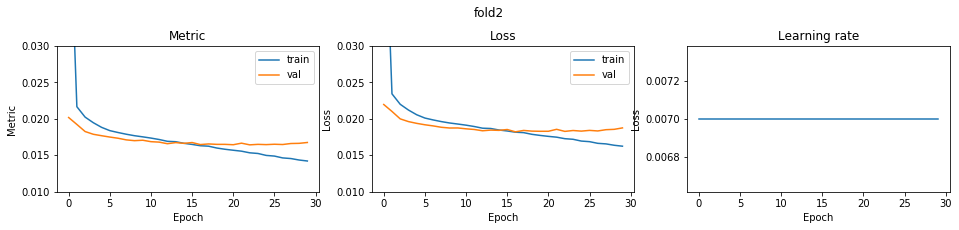

fold 3


epoch1 save best model... 0.020545713335343538
epoch2 save best model... 0.019166535066529804
epoch3 save best model... 0.018506044513017687
epoch4 save best model... 0.0180866283744336
epoch5 save best model... 0.017783384622076785
epoch6 save best model... 0.0174718558410679
epoch8 save best model... 0.017201033371642808
epoch9 save best model... 0.01713139586922859
epoch10 save best model... 0.017124119564330794
epoch11 save best model... 0.016979395319412807
epoch13 save best model... 0.016865070778155244
epoch14 save best model... 0.016736725000303942
epoch18 save best model... 0.01672547225095756
epoch19 save best model... 0.016661973811838784
epoch20 save best model... 0.016646713547510412
epoch22 save best model... 0.01659838286374859
fold3 score: 0.01659838283191387


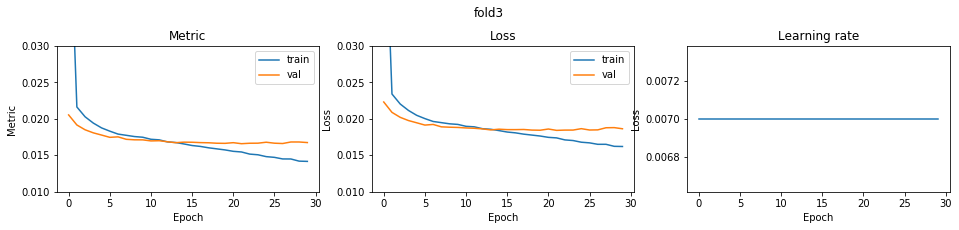

fold 4


epoch1 save best model... 0.020148455617198368
epoch2 save best model... 0.018995544483252972
epoch3 save best model... 0.01813715966863893
epoch4 save best model... 0.01783740608772615
epoch5 save best model... 0.017586518666263592
epoch6 save best model... 0.01747147053912927
epoch7 save best model... 0.017345609521845478
epoch8 save best model... 0.017115758400164324
epoch10 save best model... 0.017016000163599273
epoch11 save best model... 0.016843428922677095
epoch12 save best model... 0.016800086070827988
epoch14 save best model... 0.016780724668353456
epoch15 save best model... 0.01664223877377893
epoch19 save best model... 0.016640056824154627
epoch20 save best model... 0.016538166590798688
fold4 score: 0.01653816668773772


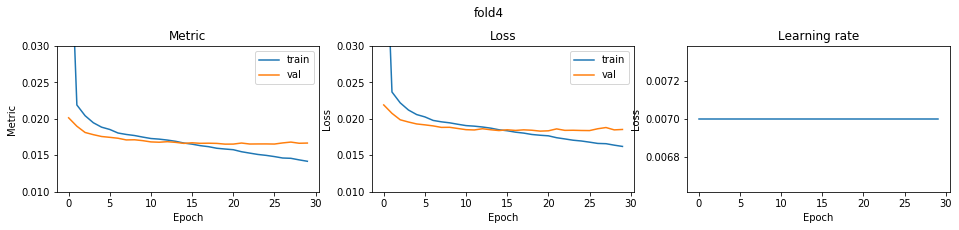

CV score: 0.016505942199280664

optimizer: PlainRAdam_CG
fold 0


epoch1 save best model... 0.699124837220394
epoch2 save best model... 0.6754887953434555
epoch3 save best model... 0.6302790543212977
epoch4 save best model... 0.5286484230895249
epoch5 save best model... 0.3751405060427064
epoch6 save best model... 0.23134635725569888
epoch7 save best model... 0.13778336008751854
epoch8 save best model... 0.08417148318540534
epoch9 save best model... 0.056226956360636106
epoch10 save best model... 0.041026652062943966
epoch11 save best model... 0.03217376349387788
epoch12 save best model... 0.027406456761045174
epoch13 save best model... 0.02454578637618546
epoch14 save best model... 0.022823765103393373
epoch15 save best model... 0.021881259866652836
epoch16 save best model... 0.02133500392045953
epoch17 save best model... 0.020891812641453636
epoch18 save best model... 0.020527903381777516
epoch19 save best model... 0.020435576715372963
epoch20 save best model... 0.02015922920595948
epoch21 save best model... 0.019927787790096158
epoch22 save best m

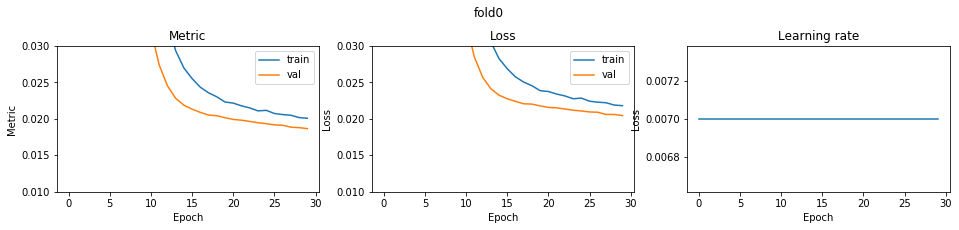

fold 1


epoch1 save best model... 0.7028318176402076
epoch2 save best model... 0.6819082578403528
epoch3 save best model... 0.6340397514333267
epoch4 save best model... 0.5299218197867333
epoch5 save best model... 0.37596426669599037
epoch6 save best model... 0.2327025713817925
epoch7 save best model... 0.14077868203104804
epoch8 save best model... 0.08667409731685015
epoch9 save best model... 0.057017580952981685
epoch10 save best model... 0.04153867099857678
epoch11 save best model... 0.033343598667568704
epoch12 save best model... 0.027724629186143036
epoch13 save best model... 0.024742766539571522
epoch14 save best model... 0.023146482811352474
epoch15 save best model... 0.02201003207271084
epoch16 save best model... 0.021380703685786952
epoch17 save best model... 0.02093209321641398
epoch18 save best model... 0.020910226359902306
epoch19 save best model... 0.020490334749282912
epoch20 save best model... 0.020435203850951735
epoch21 save best model... 0.020152789865458955
epoch22 save best

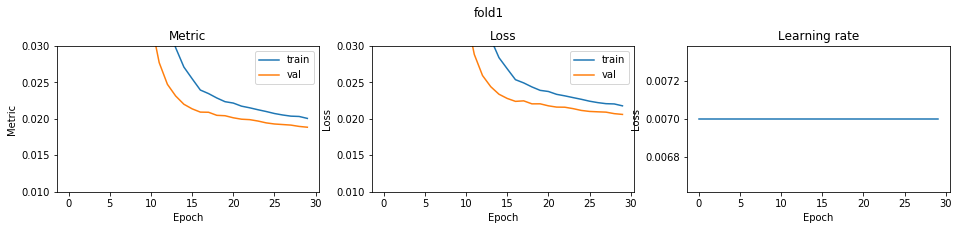

fold 2


epoch1 save best model... 0.6982242922816577
epoch2 save best model... 0.675976220962262
epoch3 save best model... 0.6280150002568424
epoch4 save best model... 0.5244768826992481
epoch5 save best model... 0.37040819949836495
epoch6 save best model... 0.23200461323425856
epoch7 save best model... 0.1388898489652611
epoch8 save best model... 0.08491723575028995
epoch9 save best model... 0.05794057346359286
epoch10 save best model... 0.04150981844697164
epoch11 save best model... 0.0323181275128096
epoch12 save best model... 0.027708290775019424
epoch13 save best model... 0.02496679528858483
epoch14 save best model... 0.02306821860761761
epoch15 save best model... 0.02203120506907764
epoch16 save best model... 0.02142654306122235
epoch17 save best model... 0.020952789116320644
epoch18 save best model... 0.020691425782091717
epoch19 save best model... 0.020556788511300963
epoch20 save best model... 0.02037017385431413
epoch21 save best model... 0.02012427174926524
epoch22 save best model..

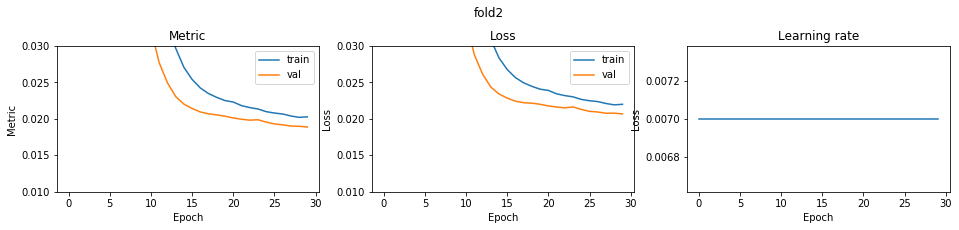

fold 3


epoch1 save best model... 0.6982162284416599
epoch2 save best model... 0.6767430992767317
epoch3 save best model... 0.6304269438452492
epoch4 save best model... 0.5289516936945209
epoch5 save best model... 0.3790921066643708
epoch6 save best model... 0.23314453262946058
epoch7 save best model... 0.14208760860297565
epoch8 save best model... 0.08706330459794043
epoch9 save best model... 0.05713717471765766
epoch10 save best model... 0.042293475166065006
epoch11 save best model... 0.033210624845227514
epoch12 save best model... 0.027998399140487226
epoch13 save best model... 0.024697446131522943
epoch14 save best model... 0.022962679332949577
epoch15 save best model... 0.021927941633825422
epoch16 save best model... 0.021401528902945867
epoch17 save best model... 0.021008136862536768
epoch18 save best model... 0.020711915029938372
epoch19 save best model... 0.02058591690033267
epoch20 save best model... 0.020420621399574644
epoch21 save best model... 0.02036952138082856
epoch22 save best

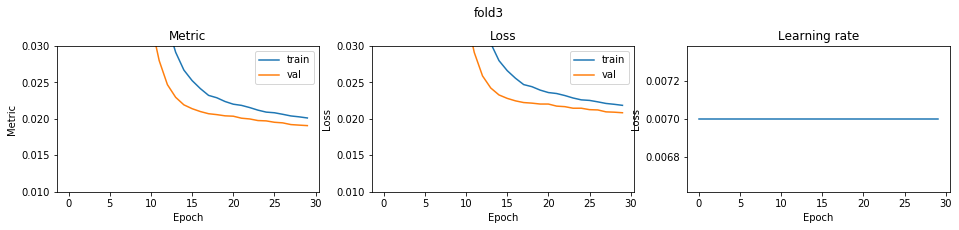

fold 4


epoch1 save best model... 0.6966077502333222
epoch2 save best model... 0.6727458559842208
epoch3 save best model... 0.6276678401136724
epoch4 save best model... 0.5249990799704011
epoch5 save best model... 0.37236884961367195
epoch6 save best model... 0.23450861803355685
epoch7 save best model... 0.13858035249224013
epoch8 save best model... 0.08593205294671526
epoch9 save best model... 0.05644456810044265
epoch10 save best model... 0.0417726532150917
epoch11 save best model... 0.032497347198036375
epoch12 save best model... 0.027594291112451454
epoch13 save best model... 0.024548799235687712
epoch14 save best model... 0.02276941135203241
epoch15 save best model... 0.02173484582750971
epoch16 save best model... 0.0211326603610111
epoch17 save best model... 0.02070991485835751
epoch18 save best model... 0.020457604174461887
epoch19 save best model... 0.020171609742392984
epoch20 save best model... 0.020100572628896165
epoch21 save best model... 0.019884642152484838
epoch22 save best mod

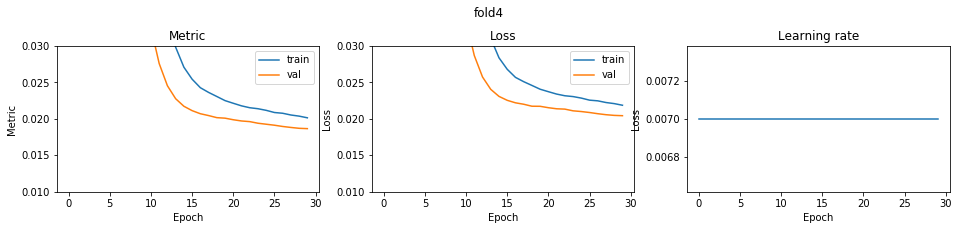

CV score: 0.018830631696300178

optimizer: RAdam_CG
fold 0


epoch1 save best model... 0.02018172876625099
epoch2 save best model... 0.01911892545131589
epoch3 save best model... 0.01811065592024484
epoch4 save best model... 0.017727780257243503
epoch5 save best model... 0.017651959012234944
epoch6 save best model... 0.017271942004629313
epoch7 save best model... 0.01711283629178865
epoch8 save best model... 0.017054675129117076
epoch9 save best model... 0.016929339306059894
epoch10 save best model... 0.016850832068193745
epoch11 save best model... 0.016767877228303488
epoch12 save best model... 0.016762495607748663
epoch13 save best model... 0.016739832543702222
epoch14 save best model... 0.01671002587910258
epoch15 save best model... 0.016580575247187007
epoch16 save best model... 0.01655184110596878
epoch18 save best model... 0.01643969316400401
epoch19 save best model... 0.016294864543070827
fold0 score: 0.01629486454568932


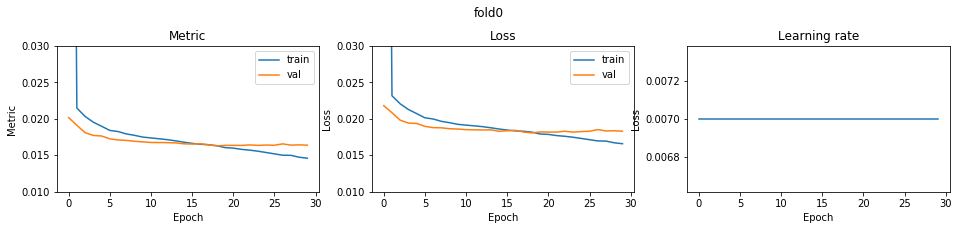

fold 1


epoch1 save best model... 0.02041012273775021
epoch2 save best model... 0.018929411033089923
epoch3 save best model... 0.018350549973335264
epoch4 save best model... 0.018157207701371345
epoch5 save best model... 0.017836634144798094
epoch6 save best model... 0.01752053203447842
epoch8 save best model... 0.01726006749761922
epoch9 save best model... 0.017220276801943046
epoch11 save best model... 0.01716958850623875
epoch12 save best model... 0.017161336434399464
epoch13 save best model... 0.017047881935361334
epoch14 save best model... 0.016925037105385902
epoch18 save best model... 0.016914630065147766
epoch19 save best model... 0.016755088921453856
epoch23 save best model... 0.016699250505277603
fold1 score: 0.01669925039913235


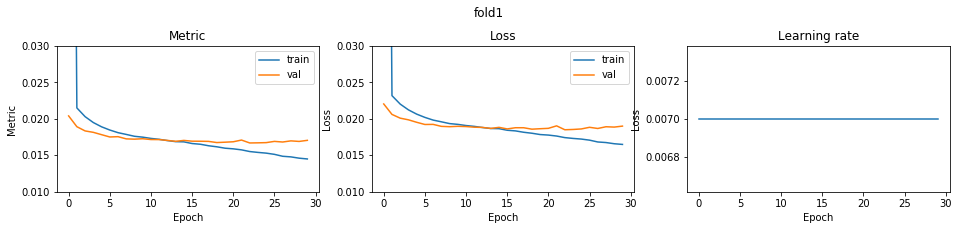

fold 2


epoch1 save best model... 0.0201652913659261
epoch2 save best model... 0.018907407530400742
epoch3 save best model... 0.018182756040796152
epoch4 save best model... 0.017705246356291934
epoch5 save best model... 0.017540278208375615
epoch6 save best model... 0.017374986623948378
epoch7 save best model... 0.017271599468793555
epoch8 save best model... 0.017039287419033555
epoch9 save best model... 0.017017356603217303
epoch10 save best model... 0.01696443485677935
epoch11 save best model... 0.016916943804205387
epoch13 save best model... 0.01677374110410088
epoch15 save best model... 0.016712441870687655
epoch16 save best model... 0.016658566020875593
epoch19 save best model... 0.016491680358290184
epoch28 save best model... 0.01648567160678483
fold2 score: 0.016485671436253523


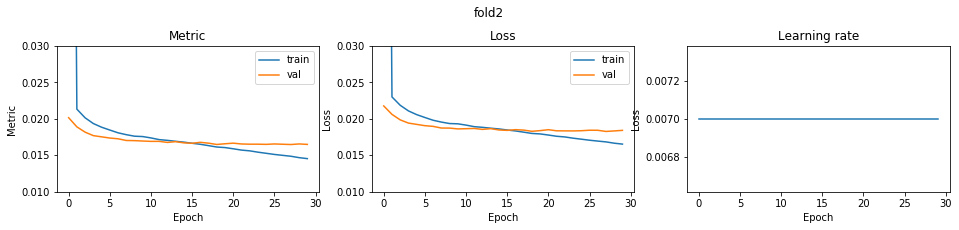

fold 3


epoch1 save best model... 0.02048144956588202
epoch2 save best model... 0.01897957935835954
epoch3 save best model... 0.018449794363171065
epoch4 save best model... 0.017973650872690396
epoch5 save best model... 0.017705245699589235
epoch6 save best model... 0.017574052222429484
epoch7 save best model... 0.017396649490863697
epoch8 save best model... 0.017199569075009816
epoch10 save best model... 0.017104362920860088
epoch11 save best model... 0.017101439077975674
epoch12 save best model... 0.016982077004850455
epoch14 save best model... 0.016881695569647744
epoch15 save best model... 0.016854276984997925
epoch16 save best model... 0.016812477708032573
epoch18 save best model... 0.016807065470088995
epoch19 save best model... 0.01675100072598878
epoch21 save best model... 0.016687907740168255
epoch25 save best model... 0.016633544904275335
fold3 score: 0.016633544897315642


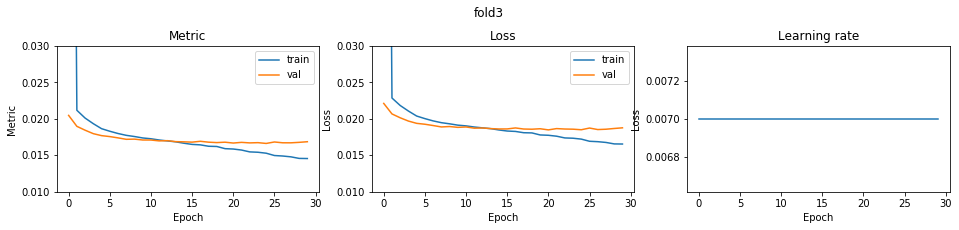

fold 4


epoch1 save best model... 0.020018730887078208
epoch2 save best model... 0.018776031066759027
epoch3 save best model... 0.018171713976847147
epoch4 save best model... 0.01773951722050175
epoch5 save best model... 0.017532879397154262
epoch6 save best model... 0.017403703606804165
epoch7 save best model... 0.01716964852132735
epoch8 save best model... 0.017112450427662133
epoch9 save best model... 0.017011872013279816
epoch10 save best model... 0.01700924200584989
epoch11 save best model... 0.016986384587298765
epoch12 save best model... 0.016968769607280543
epoch13 save best model... 0.016772115584844746
epoch17 save best model... 0.016649663307892842
epoch20 save best model... 0.016647881779879126
epoch22 save best model... 0.01662111288840312
fold4 score: 0.016621112801381954


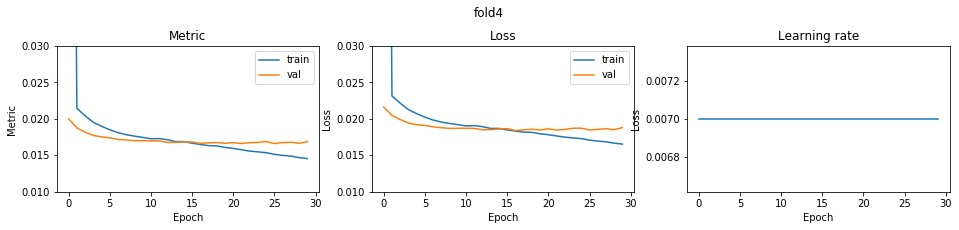

CV score: 0.016546884663220664

optimizer: Ranger_CG
fold 0


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.02125712364725344
epoch2 save best model... 0.01928660983902854
epoch3 save best model... 0.018416113229065386
epoch4 save best model... 0.017856834782181405
epoch5 save best model... 0.017419342351292423
epoch6 save best model... 0.017261245110176147
epoch7 save best model... 0.017187836341101652
epoch8 save best model... 0.01701727496006087
epoch9 save best model... 0.016882581572241418
epoch10 save best model... 0.016762621143243037
epoch11 save best model... 0.01660963417643974
epoch12 save best model... 0.016531642935406373
epoch14 save best model... 0.016450678071766617
epoch15 save best model... 0.016412528164277452
epoch16 save best model... 0.016397858466656035
epoch18 save best model... 0.01627872981012275
fold0 score: 0.016278729798946137


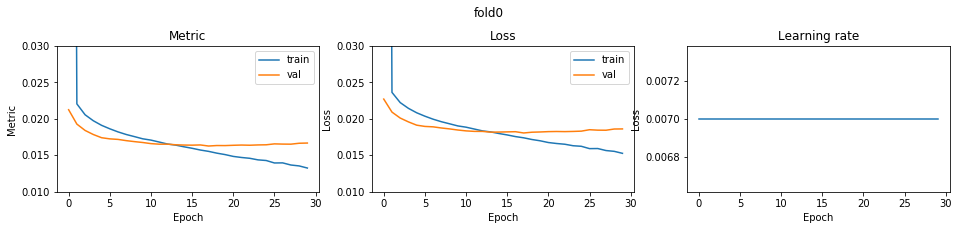

fold 1


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.021119298735507448
epoch2 save best model... 0.01957636684014643
epoch3 save best model... 0.018612295128175922
epoch4 save best model... 0.018028099869464274
epoch5 save best model... 0.017710314210148657
epoch6 save best model... 0.017497169034244475
epoch7 save best model... 0.01725549773009879
epoch8 save best model... 0.017230371501543752
epoch9 save best model... 0.01714469589493315
epoch10 save best model... 0.016924866422752798
epoch12 save best model... 0.016720189783602485
epoch13 save best model... 0.016714247978254423
epoch14 save best model... 0.016706817223645677
epoch17 save best model... 0.01669302007226296
fold1 score: 0.016693020170558594


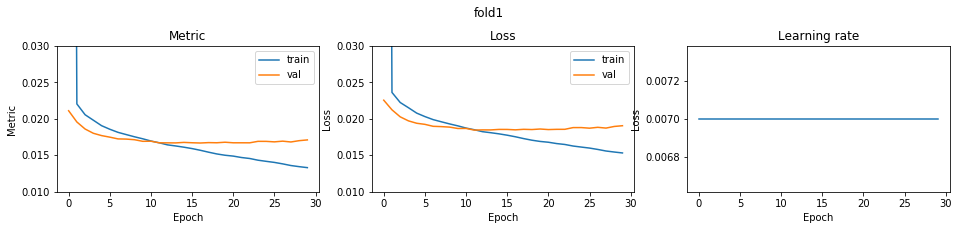

fold 2


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.02123889241662105
epoch2 save best model... 0.019395605627872604
epoch3 save best model... 0.01843192444456027
epoch4 save best model... 0.018190861831757197
epoch5 save best model... 0.01771322383374947
epoch6 save best model... 0.017362505265215135
epoch7 save best model... 0.017295220340768674
epoch8 save best model... 0.01711267008308018
epoch9 save best model... 0.01687206562199369
epoch11 save best model... 0.016739236407990295
epoch12 save best model... 0.016683336361346387
epoch13 save best model... 0.01657336366490823
epoch14 save best model... 0.016561204165654837
epoch15 save best model... 0.016500185970764452
epoch16 save best model... 0.016494463951390353
epoch17 save best model... 0.01647992179902832
epoch18 save best model... 0.016385063893565095
fold2 score: 0.01638506397129678


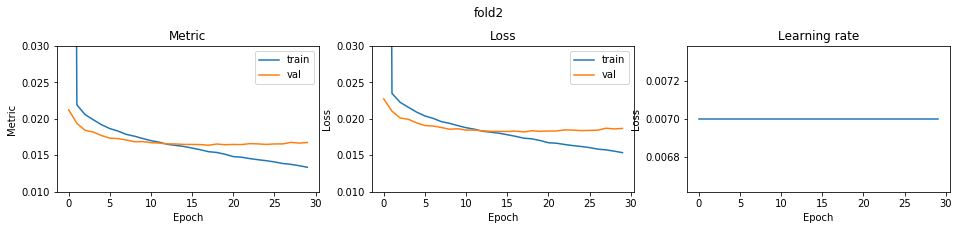

fold 3


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.021286650438175656
epoch2 save best model... 0.019710197782139706
epoch3 save best model... 0.018785938410118122
epoch4 save best model... 0.018219210165457328
epoch5 save best model... 0.01786621112826202
epoch6 save best model... 0.017662618061896746
epoch7 save best model... 0.017417516963713398
epoch8 save best model... 0.01727951671249299
epoch9 save best model... 0.017070106127148744
epoch10 save best model... 0.017020738557626012
epoch12 save best model... 0.016839919728492143
epoch13 save best model... 0.016778764783792994
epoch14 save best model... 0.016679363967617444
epoch16 save best model... 0.016603487145350843
epoch18 save best model... 0.016586630972598708
epoch19 save best model... 0.016577871320747978
epoch20 save best model... 0.016548618752348126
fold3 score: 0.016548618734828716


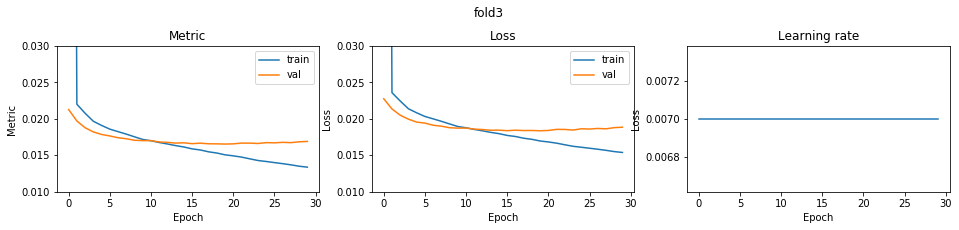

fold 4


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.020926033234508
epoch2 save best model... 0.0194212237046289
epoch3 save best model... 0.01848037998469924
epoch4 save best model... 0.017939875683066243
epoch5 save best model... 0.01757036207078326
epoch6 save best model... 0.017466213530383513
epoch7 save best model... 0.01715487531409652
epoch8 save best model... 0.017152934342809446
epoch9 save best model... 0.01692236265579158
epoch10 save best model... 0.016902678048743066
epoch11 save best model... 0.01679243425878957
epoch12 save best model... 0.016708450586638987
epoch14 save best model... 0.016669342660924298
epoch15 save best model... 0.016634911395490577
epoch16 save best model... 0.016606647169943006
epoch18 save best model... 0.016526639634628772
fold4 score: 0.016526639605432616


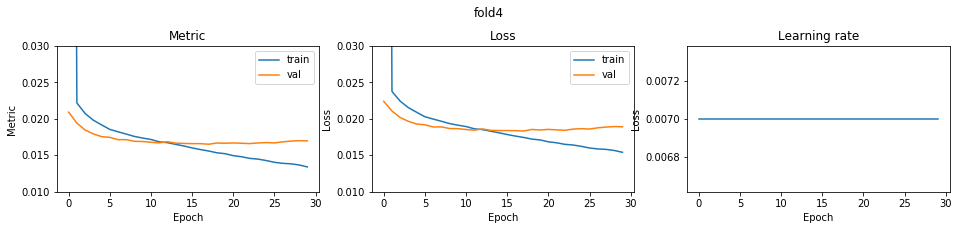

CV score: 0.016486409660548755

optimizer: AggMo
fold 0


epoch1 save best model... 0.24323644748717071
epoch2 save best model... 0.03195375518572086
epoch3 save best model... 0.03025075126023526
fold0 score: 0.03025075117837983


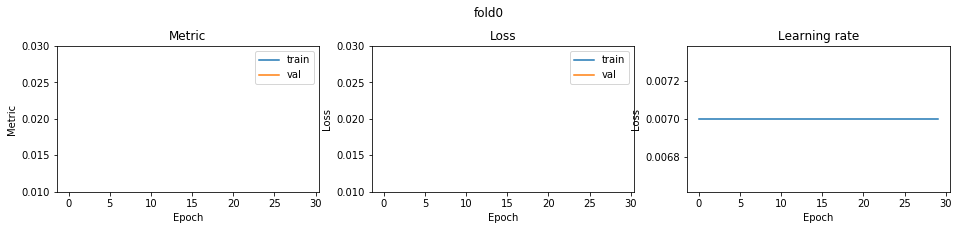

fold 1


epoch1 save best model... 0.24618681159832126
epoch2 save best model... 0.031580594047228384
epoch3 save best model... 0.03011778654396113
fold1 score: 0.030117786691626396


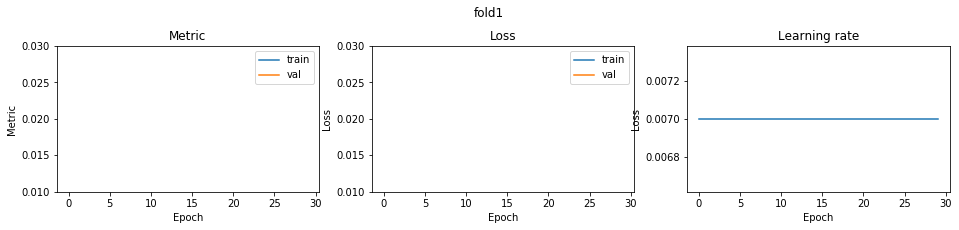

fold 2


epoch1 save best model... 0.2769981964584037
epoch2 save best model... 0.032370096370900346
epoch3 save best model... 0.02998092366303119
fold2 score: 0.029980923611842503


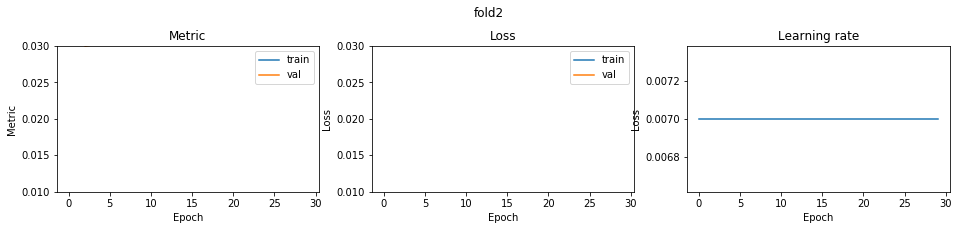

fold 3


epoch1 save best model... 0.2684211741683152
epoch2 save best model... 0.03235232084395538
epoch3 save best model... 0.030252590480182057
epoch4 save best model... 0.030219514507605166
fold3 score: 0.030219514467913815


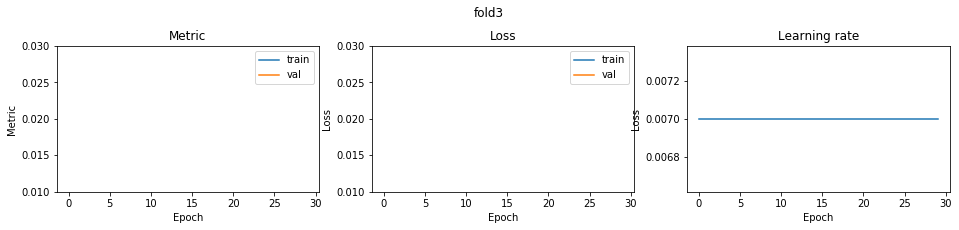

fold 4


epoch1 save best model... 0.2500457289618077
epoch2 save best model... 0.031168223230978623
epoch3 save best model... 0.029800783895414348
epoch4 save best model... 0.029776282476129727
fold4 score: 0.029776282341323967


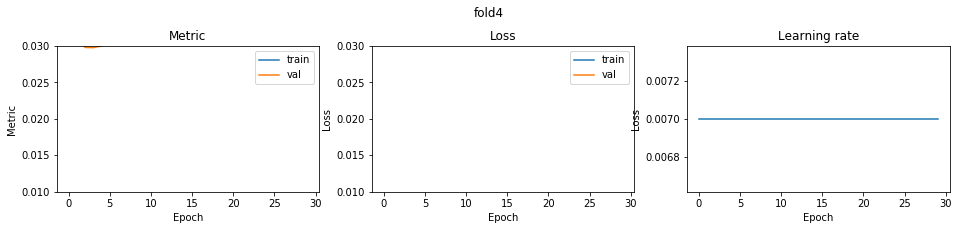

CV score: 0.030069053453051133

optimizer: Apollo
fold 0


epoch1 save best model... 0.700888203135384
epoch2 save best model... 0.6927384861237911
epoch3 save best model... 0.6831471593885052
epoch4 save best model... 0.6748059437595358
epoch5 save best model... 0.6675768881832549
epoch6 save best model... 0.6587730648034255
epoch7 save best model... 0.6495229053334386
epoch8 save best model... 0.641340227251987
epoch9 save best model... 0.628520460253696
epoch10 save best model... 0.6163470896881642
epoch11 save best model... 0.6048655025508246
epoch12 save best model... 0.590152121812173
epoch13 save best model... 0.5735332228599757
epoch14 save best model... 0.5556934857694326
epoch15 save best model... 0.5337194519868472
epoch16 save best model... 0.5107703073149662
epoch17 save best model... 0.4851206600258725
epoch18 save best model... 0.4586648313358324
epoch19 save best model... 0.4254450392342917
epoch20 save best model... 0.3932702503470462
epoch21 save best model... 0.36311456075018794
epoch22 save best model... 0.32947873010179174

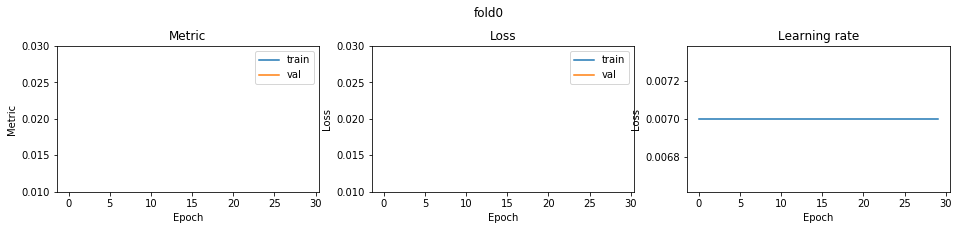

fold 1


epoch1 save best model... 0.7051051932631714
epoch2 save best model... 0.6971572746744893
epoch3 save best model... 0.6870274492563868
epoch4 save best model... 0.6788181090143064
epoch5 save best model... 0.6726134124201993
epoch6 save best model... 0.6637822647359817
epoch7 save best model... 0.6551609267594195
epoch8 save best model... 0.6485481940822684
epoch9 save best model... 0.638040858524811
epoch10 save best model... 0.6279577251636621
epoch11 save best model... 0.6163815031917526
epoch12 save best model... 0.6034151679509646
epoch13 save best model... 0.5892538038004121
epoch14 save best model... 0.5710265785285948
epoch15 save best model... 0.5548154295482188
epoch16 save best model... 0.5334348648847657
epoch17 save best model... 0.5103017341903197
epoch18 save best model... 0.48601670360532595
epoch19 save best model... 0.45982482853498563
epoch20 save best model... 0.4267681289381904
epoch21 save best model... 0.3983231703467509
epoch22 save best model... 0.3654500061625

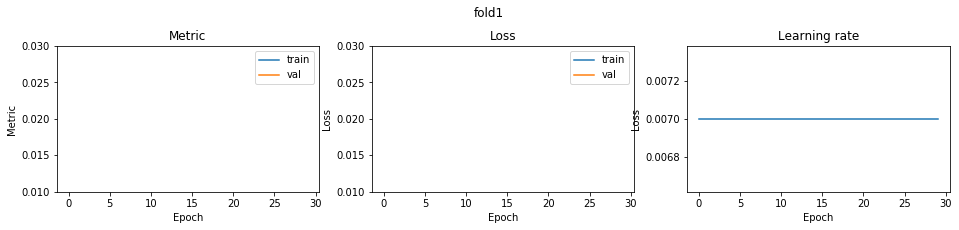

fold 2


epoch1 save best model... 0.7050995419171547
epoch2 save best model... 0.6984279462921237
epoch3 save best model... 0.6879844362683056
epoch4 save best model... 0.6786029491481055
epoch5 save best model... 0.6734842488694555
epoch6 save best model... 0.6631058285029392
epoch7 save best model... 0.6542435628484012
epoch8 save best model... 0.6440431713433221
epoch9 save best model... 0.6378750358499191
epoch10 save best model... 0.6245263926557539
epoch11 save best model... 0.6134419673177424
epoch12 save best model... 0.5995013746701386
epoch13 save best model... 0.5828551315424735
epoch14 save best model... 0.5639309802992954
epoch15 save best model... 0.5467634532956279
epoch16 save best model... 0.5234581386344963
epoch17 save best model... 0.4976693544580117
epoch18 save best model... 0.4695488181084863
epoch19 save best model... 0.4419792894758649
epoch20 save best model... 0.41097943254933866
epoch21 save best model... 0.3780368319756079
epoch22 save best model... 0.3475841829189

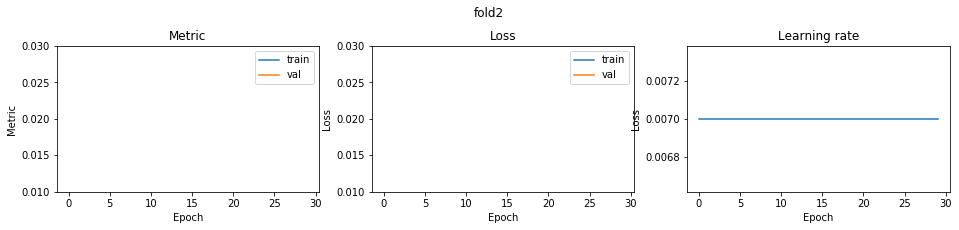

fold 3


epoch1 save best model... 0.7049798747401574
epoch2 save best model... 0.6955108893216335
epoch3 save best model... 0.6861500842967718
epoch4 save best model... 0.6792618871006716
epoch5 save best model... 0.6705673916193239
epoch6 save best model... 0.662872517543393
epoch7 save best model... 0.6554552084764207
epoch8 save best model... 0.6469726763173497
epoch9 save best model... 0.636804458193464
epoch10 save best model... 0.6268080032767902
epoch11 save best model... 0.6151198328491767
epoch12 save best model... 0.600585204132054
epoch13 save best model... 0.5868604931853084
epoch14 save best model... 0.571228807553615
epoch15 save best model... 0.5520680905474618
epoch16 save best model... 0.5314072227423717
epoch17 save best model... 0.5070198183993815
epoch18 save best model... 0.48221389865820935
epoch19 save best model... 0.4540278903308382
epoch20 save best model... 0.4240798311380156
epoch21 save best model... 0.39212030120754027
epoch22 save best model... 0.3606253459540477

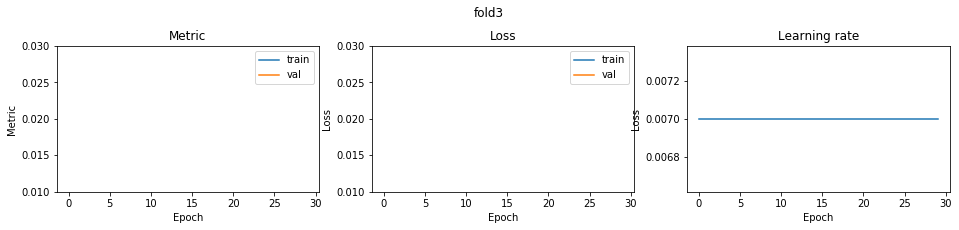

fold 4


epoch1 save best model... 0.7052645717231993
epoch2 save best model... 0.6979565881922468
epoch3 save best model... 0.6880582833072862
epoch4 save best model... 0.6798634274945444
epoch5 save best model... 0.6715393683090297
epoch6 save best model... 0.6657722418020418
epoch7 save best model... 0.6555029790602404
epoch8 save best model... 0.6451697099724771
epoch9 save best model... 0.6361433505740416
epoch10 save best model... 0.6239842090356866
epoch11 save best model... 0.6130113011612165
epoch12 save best model... 0.5979411368489537
epoch13 save best model... 0.5835065339040647
epoch14 save best model... 0.5638201505556737
epoch15 save best model... 0.5437655406823734
epoch16 save best model... 0.5219693283556806
epoch17 save best model... 0.4978332056407233
epoch18 save best model... 0.468842403668749
epoch19 save best model... 0.44001179572389987
epoch20 save best model... 0.40641696176116177
epoch21 save best model... 0.3772281963895828
epoch22 save best model... 0.3428586598545

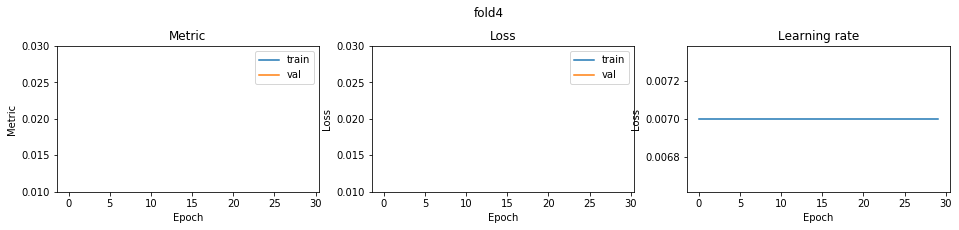

CV score: 0.1559558860657511

optimizer: PID
fold 0


epoch1 save best model... 0.7015047658005716
epoch2 save best model... 0.6954734236341402
epoch3 save best model... 0.6855530307884912
epoch4 save best model... 0.6772853287857594
epoch5 save best model... 0.6682759635540781
epoch6 save best model... 0.6615651696309414
epoch7 save best model... 0.6525615726625186
epoch8 save best model... 0.6431077306254307
epoch9 save best model... 0.6331729438418952
epoch10 save best model... 0.6205059927796992
epoch11 save best model... 0.6095940995868083
epoch12 save best model... 0.5946300786557122
epoch13 save best model... 0.5784066809880163
epoch14 save best model... 0.5608928500384024
epoch15 save best model... 0.5388928865245914
epoch16 save best model... 0.5142711623926097
epoch17 save best model... 0.4899732488706063
epoch18 save best model... 0.4608839730738507
epoch19 save best model... 0.43254751545421627
epoch20 save best model... 0.39808721705286815
epoch21 save best model... 0.36726351882710817
epoch22 save best model... 0.33677452559

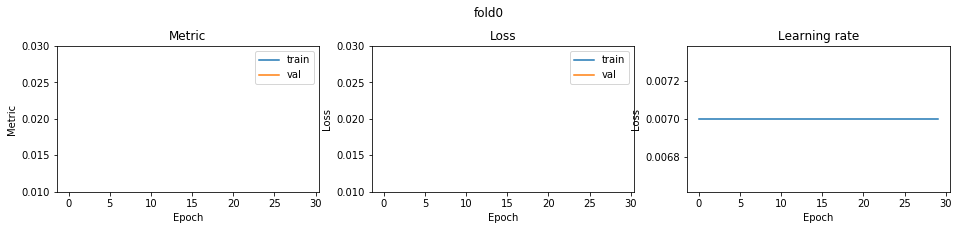

fold 1


epoch1 save best model... 0.7102841263236748
epoch2 save best model... 0.6995739364819582
epoch3 save best model... 0.6924371844028987
epoch4 save best model... 0.6853705842474865
epoch5 save best model... 0.6783694457725339
epoch6 save best model... 0.670338956743146
epoch7 save best model... 0.6613093712900787
epoch8 save best model... 0.6527291202251828
epoch9 save best model... 0.6438989172929185
epoch10 save best model... 0.633906784783357
epoch11 save best model... 0.6238819592144094
epoch12 save best model... 0.6087010940513515
epoch13 save best model... 0.5972356837549251
epoch14 save best model... 0.5810255312544796
epoch15 save best model... 0.5618896053466962
epoch16 save best model... 0.5417602420885326
epoch17 save best model... 0.5192823886708372
epoch18 save best model... 0.4904350843726163
epoch19 save best model... 0.4654799937033985
epoch20 save best model... 0.43378133578516676
epoch21 save best model... 0.40103616570388845
epoch22 save best model... 0.36992323088276

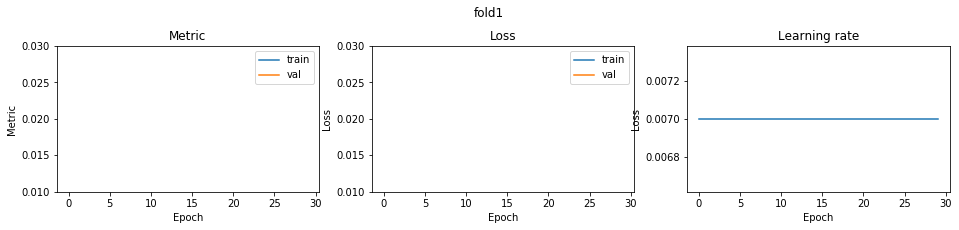

fold 2


epoch1 save best model... 0.7017347871999204
epoch2 save best model... 0.6944400089073355
epoch3 save best model... 0.6872383080410995
epoch4 save best model... 0.679220143891489
epoch5 save best model... 0.6734118846207552
epoch6 save best model... 0.6604020154049739
epoch7 save best model... 0.6534893182992229
epoch8 save best model... 0.6442327402968373
epoch9 save best model... 0.6349460796985031
epoch10 save best model... 0.6233108019090019
epoch11 save best model... 0.6121989623455666
epoch12 save best model... 0.6009802701370568
epoch13 save best model... 0.5811587391885057
epoch14 save best model... 0.5657560626258338
epoch15 save best model... 0.54934338615869
epoch16 save best model... 0.5225479108213319
epoch17 save best model... 0.5015391701105435
epoch18 save best model... 0.47250892408998496
epoch19 save best model... 0.4454284280803378
epoch20 save best model... 0.4142765140623078
epoch21 save best model... 0.38172407465606867
epoch22 save best model... 0.347035670055020

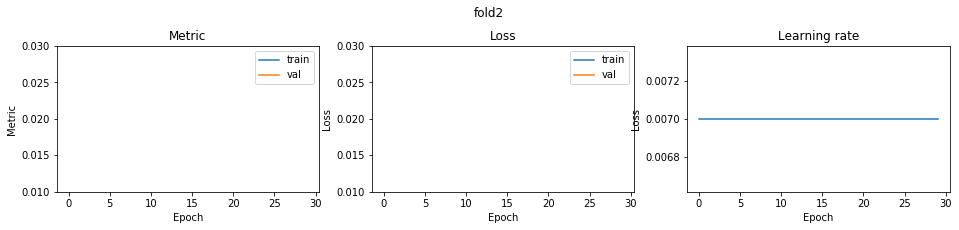

fold 3


epoch1 save best model... 0.7032448055803912
epoch2 save best model... 0.6958402432993496
epoch3 save best model... 0.6867219788338438
epoch4 save best model... 0.6795915581099264
epoch5 save best model... 0.6696128786832162
epoch6 save best model... 0.6634578408575819
epoch7 save best model... 0.6553132510674027
epoch8 save best model... 0.6467448831419196
epoch9 save best model... 0.6376457704769994
epoch10 save best model... 0.6269897965200941
epoch11 save best model... 0.6156177437930009
epoch12 save best model... 0.6029223040459096
epoch13 save best model... 0.5858931173496202
epoch14 save best model... 0.571672407559762
epoch15 save best model... 0.5519458603750329
epoch16 save best model... 0.5305257398881239
epoch17 save best model... 0.5058281729052985
epoch18 save best model... 0.48068488767043877
epoch19 save best model... 0.45182655214720274
epoch20 save best model... 0.42183809509853026
epoch21 save best model... 0.39021675407479184
epoch22 save best model... 0.35839546531

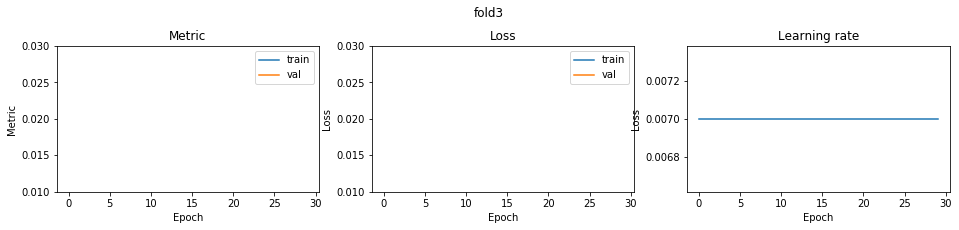

fold 4


epoch1 save best model... 0.7033003085838092
epoch2 save best model... 0.6970614459357121
epoch3 save best model... 0.6904839646300314
epoch4 save best model... 0.6805690973657682
epoch5 save best model... 0.6751405629318776
epoch6 save best model... 0.6690065897407184
epoch7 save best model... 0.6598794343259721
epoch8 save best model... 0.651036621036182
epoch9 save best model... 0.6443610829481503
epoch10 save best model... 0.6330408477565965
epoch11 save best model... 0.6214708899582708
epoch12 save best model... 0.608550194021238
epoch13 save best model... 0.5954362881210779
epoch14 save best model... 0.5808137587642886
epoch15 save best model... 0.5634352998744382
epoch16 save best model... 0.5404416254549743
epoch17 save best model... 0.5198798667597064
epoch18 save best model... 0.4920989041583685
epoch19 save best model... 0.46709028018091153
epoch20 save best model... 0.4364261773968612
epoch21 save best model... 0.4042597475383168
epoch22 save best model... 0.374641560951506

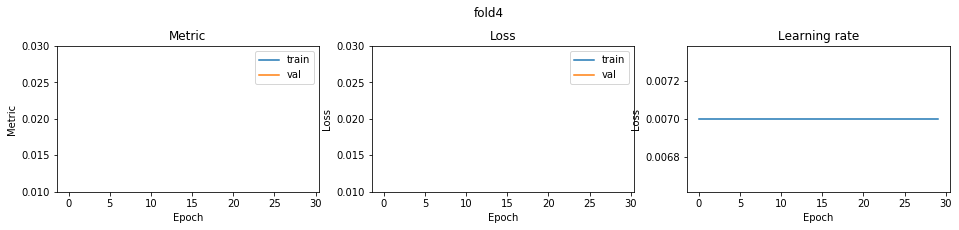

CV score: 0.15903969961974346

optimizer: QHM
fold 0


epoch1 save best model... 0.7042388504349832
epoch2 save best model... 0.6977937710583889
epoch3 save best model... 0.6892024156715983
epoch4 save best model... 0.6813838450132036
epoch5 save best model... 0.673465158075841
epoch6 save best model... 0.6634614327230867
epoch7 save best model... 0.6552038406456793
epoch8 save best model... 0.6483709317133476
epoch9 save best model... 0.637971880604303
epoch10 save best model... 0.6255027449755571
epoch11 save best model... 0.614014015083704
epoch12 save best model... 0.6003196889827355
epoch13 save best model... 0.5845041417043682
epoch14 save best model... 0.5681191348540756
epoch15 save best model... 0.5488141768342542
epoch16 save best model... 0.5247855544633365
epoch17 save best model... 0.5025956764851182
epoch18 save best model... 0.4753352525972831
epoch19 save best model... 0.4445296335736277
epoch20 save best model... 0.4142337845235316
epoch21 save best model... 0.38003590275323473
epoch22 save best model... 0.3496241232936094

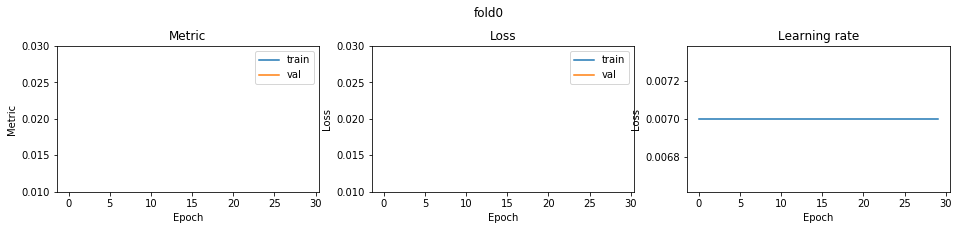

fold 1


epoch1 save best model... 0.7062347975671359
epoch2 save best model... 0.6978981665609963
epoch3 save best model... 0.6910581376346702
epoch4 save best model... 0.6809371152209867
epoch5 save best model... 0.67552987742625
epoch6 save best model... 0.6671411726571999
epoch7 save best model... 0.6580956473413538
epoch8 save best model... 0.6489178741350345
epoch9 save best model... 0.6395192674852824
epoch10 save best model... 0.6298443689436488
epoch11 save best model... 0.6187646870299118
epoch12 save best model... 0.6062769138153008
epoch13 save best model... 0.590395168227089
epoch14 save best model... 0.5756941742602609
epoch15 save best model... 0.5564210675359723
epoch16 save best model... 0.5355592179635197
epoch17 save best model... 0.5122256472513274
epoch18 save best model... 0.48448440886814953
epoch19 save best model... 0.45804649010202175
epoch20 save best model... 0.43133808568877113
epoch21 save best model... 0.3978264644032433
epoch22 save best model... 0.36461451094224

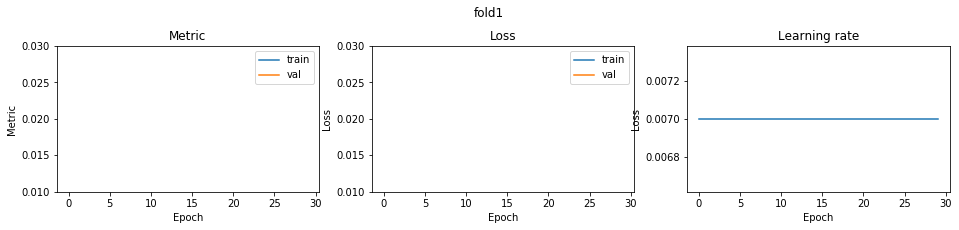

fold 2


epoch1 save best model... 0.7042038698868915
epoch2 save best model... 0.695782813946569
epoch3 save best model... 0.688519180133365
epoch4 save best model... 0.6806922224964578
epoch5 save best model... 0.6733040679937942
epoch6 save best model... 0.6649795670557141
epoch7 save best model... 0.6564459639927552
epoch8 save best model... 0.6476561894420069
epoch9 save best model... 0.6385104380671922
epoch10 save best model... 0.6289296992331926
epoch11 save best model... 0.6167229077598179
epoch12 save best model... 0.604316131852433
epoch13 save best model... 0.5893249971281561
epoch14 save best model... 0.5732424309161889
epoch15 save best model... 0.5545512323608754
epoch16 save best model... 0.5339157603601302
epoch17 save best model... 0.5098872268273256
epoch18 save best model... 0.4878102655181528
epoch19 save best model... 0.45581735583312094
epoch20 save best model... 0.428784353134436
epoch21 save best model... 0.3985751739366366
epoch22 save best model... 0.3671721161213082


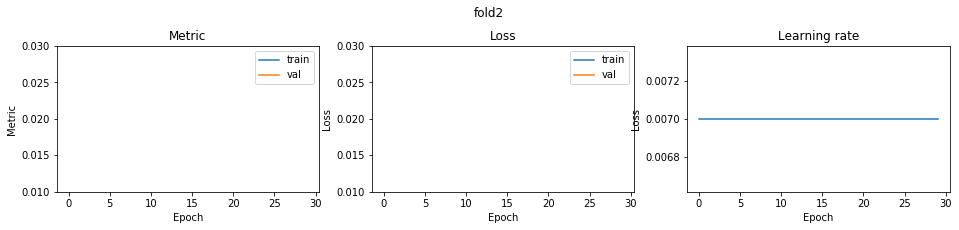

fold 3


epoch1 save best model... 0.7053374696701155
epoch2 save best model... 0.6943924718945879
epoch3 save best model... 0.6862829325954029
epoch4 save best model... 0.6770747489972647
epoch5 save best model... 0.6714344311140664
epoch6 save best model... 0.6626836136696279
epoch7 save best model... 0.6548275941053664
epoch8 save best model... 0.6458362395508143
epoch9 save best model... 0.6348198532243524
epoch10 save best model... 0.6253113697221447
epoch11 save best model... 0.612998993494516
epoch12 save best model... 0.5980642433047023
epoch13 save best model... 0.584490269381799
epoch14 save best model... 0.5648772333097349
epoch15 save best model... 0.5455040008712195
epoch16 save best model... 0.5259103965650659
epoch17 save best model... 0.49868735152387944
epoch18 save best model... 0.4721425385029821
epoch19 save best model... 0.44231033019704535
epoch20 save best model... 0.4115614855207995
epoch21 save best model... 0.37868716452007684
epoch22 save best model... 0.3487323119048

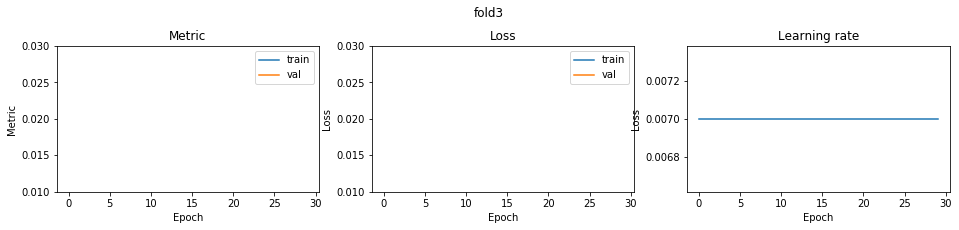

fold 4


epoch1 save best model... 0.703884855082475
epoch2 save best model... 0.6976444264207723
epoch3 save best model... 0.6899050057341678
epoch4 save best model... 0.6794001630335571
epoch5 save best model... 0.6731032988748138
epoch6 save best model... 0.664765353083339
epoch7 save best model... 0.6563055604628387
epoch8 save best model... 0.6490931414254434
epoch9 save best model... 0.6391022635212249
epoch10 save best model... 0.6284596777722613
epoch11 save best model... 0.6188487021961082
epoch12 save best model... 0.6052250371435509
epoch13 save best model... 0.5932387506500192
epoch14 save best model... 0.5776983401498382
epoch15 save best model... 0.5603043649897217
epoch16 save best model... 0.5420914828098445
epoch17 save best model... 0.5176526039499356
epoch18 save best model... 0.49389801301011194
epoch19 save best model... 0.4654580386597366
epoch20 save best model... 0.4374336197734694
epoch21 save best model... 0.40626561330771394
epoch22 save best model... 0.37544158568143

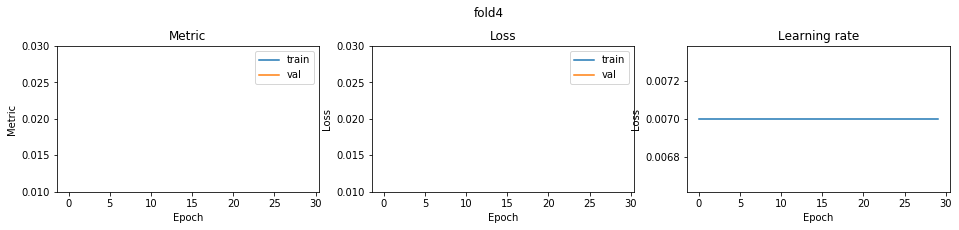

CV score: 0.1605715750113786

optimizer: SGDP
fold 0


epoch1 save best model... 0.7092857314948341
epoch2 save best model... 0.7040281439153372
epoch3 save best model... 0.6940824442680985
epoch4 save best model... 0.6857932258303996
epoch5 save best model... 0.6779793881609663
epoch6 save best model... 0.6704354127338644
epoch7 save best model... 0.6611211533970062
epoch8 save best model... 0.6540281863581889
epoch9 save best model... 0.6443161771346333
epoch10 save best model... 0.6349713206019652
epoch11 save best model... 0.6222038607119428
epoch12 save best model... 0.6131964818491751
epoch13 save best model... 0.597425426573308
epoch14 save best model... 0.5815574869751116
epoch15 save best model... 0.5638362014755302
epoch16 save best model... 0.5417741459974666
epoch17 save best model... 0.5189343137730227
epoch18 save best model... 0.49426846980777034
epoch19 save best model... 0.4674260401780079
epoch20 save best model... 0.43592694781907326
epoch21 save best model... 0.4034979307434282
epoch22 save best model... 0.3721520884976

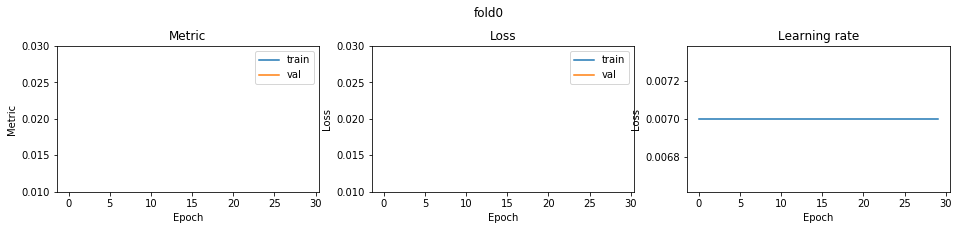

fold 1


epoch1 save best model... 0.7049906961628342
epoch2 save best model... 0.6979438590145133
epoch3 save best model... 0.687970595605337
epoch4 save best model... 0.6813694278725081
epoch5 save best model... 0.6748134234576812
epoch6 save best model... 0.6646118777084524
epoch7 save best model... 0.6567065211683071
epoch8 save best model... 0.6482246846103212
epoch9 save best model... 0.6391024017801152
epoch10 save best model... 0.629154042248086
epoch11 save best model... 0.6163871246879153
epoch12 save best model... 0.6038844297512921
epoch13 save best model... 0.5921155851640743
epoch14 save best model... 0.5735406125018254
epoch15 save best model... 0.5564889229221262
epoch16 save best model... 0.5345807370739718
epoch17 save best model... 0.5099830663158019
epoch18 save best model... 0.48372890541699626
epoch19 save best model... 0.4564644416811581
epoch20 save best model... 0.42689776828007103
epoch21 save best model... 0.39337337732070615
epoch22 save best model... 0.3627925894884

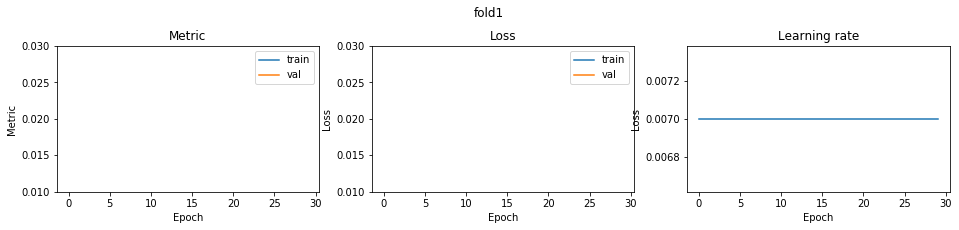

fold 2


epoch1 save best model... 0.69833549722014
epoch2 save best model... 0.6893283743254278
epoch3 save best model... 0.6824461890396862
epoch4 save best model... 0.6737662861927899
epoch5 save best model... 0.6663430497461095
epoch6 save best model... 0.6584327225534105
epoch7 save best model... 0.651484992705654
epoch8 save best model... 0.6419653576635559
epoch9 save best model... 0.631028048892748
epoch10 save best model... 0.6202230797076883
epoch11 save best model... 0.6081724131289309
epoch12 save best model... 0.5951625597072262
epoch13 save best model... 0.5811751958557402
epoch14 save best model... 0.5656744937577316
epoch15 save best model... 0.5452716657202237
epoch16 save best model... 0.5215918911049322
epoch17 save best model... 0.49993190141494465
epoch18 save best model... 0.47235785973020444
epoch19 save best model... 0.4441481191154818
epoch20 save best model... 0.414386961333272
epoch21 save best model... 0.38517910850485354
epoch22 save best model... 0.3530594249960229

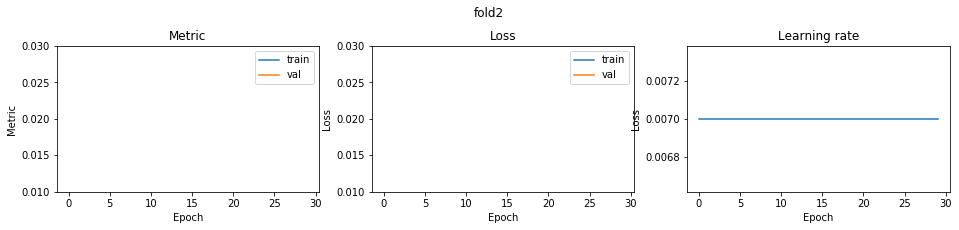

fold 3


epoch1 save best model... 0.7059535624226024
epoch2 save best model... 0.6968946368927836
epoch3 save best model... 0.6893727474983841
epoch4 save best model... 0.6818861975485209
epoch5 save best model... 0.6742324010386282
epoch6 save best model... 0.6653669094713511
epoch7 save best model... 0.6569211487618014
epoch8 save best model... 0.6494943216884326
epoch9 save best model... 0.6379363873281891
epoch10 save best model... 0.6286537820766075
epoch11 save best model... 0.6191877683094259
epoch12 save best model... 0.6046372183091548
epoch13 save best model... 0.5916795192655507
epoch14 save best model... 0.5739981703171697
epoch15 save best model... 0.5556037220976618
epoch16 save best model... 0.5353984829776651
epoch17 save best model... 0.5112644877955148
epoch18 save best model... 0.48493939570250977
epoch19 save best model... 0.45788082548317444
epoch20 save best model... 0.42793207446915144
epoch21 save best model... 0.39690867432972293
epoch22 save best model... 0.3655338334

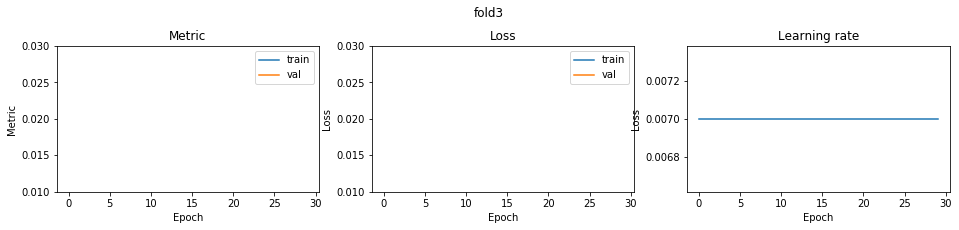

fold 4


epoch1 save best model... 0.7083000025336454
epoch2 save best model... 0.6983651720852949
epoch3 save best model... 0.6889943678178114
epoch4 save best model... 0.6789235010777085
epoch5 save best model... 0.6726268782702557
epoch6 save best model... 0.6640464549455665
epoch7 save best model... 0.6557736230874116
epoch8 save best model... 0.648297288124545
epoch9 save best model... 0.6380180009133724
epoch10 save best model... 0.6267210432771669
epoch11 save best model... 0.6162485326341182
epoch12 save best model... 0.6022619012276512
epoch13 save best model... 0.58980342559771
epoch14 save best model... 0.5731340174794468
epoch15 save best model... 0.5526739694262963
epoch16 save best model... 0.530827393157064
epoch17 save best model... 0.5084731873998881
epoch18 save best model... 0.4826621483561661
epoch19 save best model... 0.4550144596360539
epoch20 save best model... 0.423252813107332
epoch21 save best model... 0.3934596470656862
epoch22 save best model... 0.36218650138731157
e

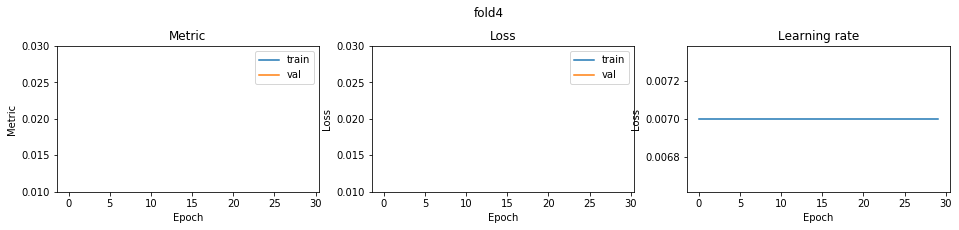

CV score: 0.16218881853337527

optimizer: SGDW
fold 0


epoch1 save best model... 0.7492035020999865
epoch7 save best model... 0.7428961361730831
epoch8 save best model... 0.6951629560737783
epoch9 save best model... 0.6170995527899619
epoch10 save best model... 0.5532225493418057
epoch12 save best model... 0.4383084579046332
epoch13 save best model... 0.34378862862978005
epoch14 save best model... 0.32931819778096977
epoch15 save best model... 0.2734451512405161
epoch16 save best model... 0.2124537167421506
epoch17 save best model... 0.19589319212154266
epoch18 save best model... 0.1786214868374729
epoch19 save best model... 0.17176852822643207
epoch20 save best model... 0.13808666286408766
epoch21 save best model... 0.07998910135078267
epoch27 save best model... 0.05781944393602482
epoch28 save best model... 0.056535438857208895
epoch30 save best model... 0.052621586924601255
fold0 score: 0.05262158632753601


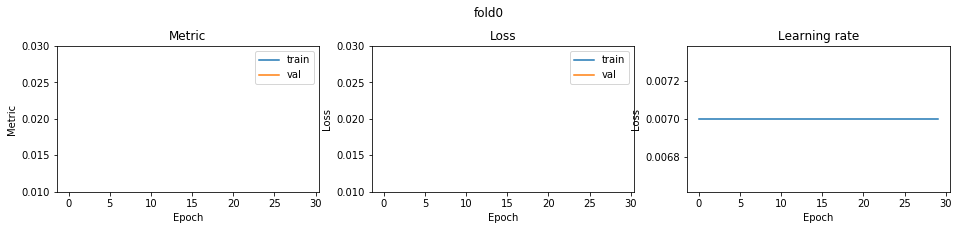

fold 1


epoch1 save best model... 0.760413880933795
epoch7 save best model... 0.7166859906283075
epoch8 save best model... 0.6293746974275932
epoch9 save best model... 0.5781433905928302
epoch10 save best model... 0.4324684977382048
epoch12 save best model... 0.39201571310087985
epoch13 save best model... 0.3235332532345529
epoch14 save best model... 0.2707310335260368
epoch15 save best model... 0.2635768002128718
epoch16 save best model... 0.1775995918979716
epoch17 save best model... 0.1627564964424263
epoch18 save best model... 0.13819130633843735
epoch19 save best model... 0.1109124384387584
epoch20 save best model... 0.10805441056437388
epoch21 save best model... 0.0954247778304911
epoch23 save best model... 0.07833158806998493
epoch24 save best model... 0.07211659494494625
epoch25 save best model... 0.061559654751062176
epoch26 save best model... 0.05798745670882736
epoch29 save best model... 0.05027249940274435
fold1 score: 0.050272498573867466


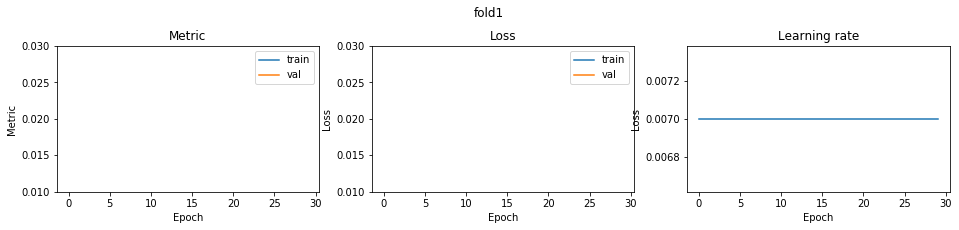

fold 2


epoch1 save best model... 0.7640433176472616
epoch6 save best model... 0.7531310346518217
epoch8 save best model... 0.665004767394332
epoch10 save best model... 0.5549918586109407
epoch11 save best model... 0.5411474617963283
epoch12 save best model... 0.42947716625289784
epoch13 save best model... 0.3754611591267189
epoch14 save best model... 0.36603539833265547
epoch15 save best model... 0.28216299168828357
epoch16 save best model... 0.2612507787288444
epoch17 save best model... 0.2480457280909969
epoch18 save best model... 0.20073663998088795
epoch19 save best model... 0.1441202899044319
epoch22 save best model... 0.13560796408061218
epoch23 save best model... 0.10241133660353054
epoch25 save best model... 0.08253386115630264
epoch27 save best model... 0.07400064384889415
epoch28 save best model... 0.06963832279564132
epoch29 save best model... 0.06499717313873521
epoch30 save best model... 0.06179886863338401
fold2 score: 0.061798867799580305


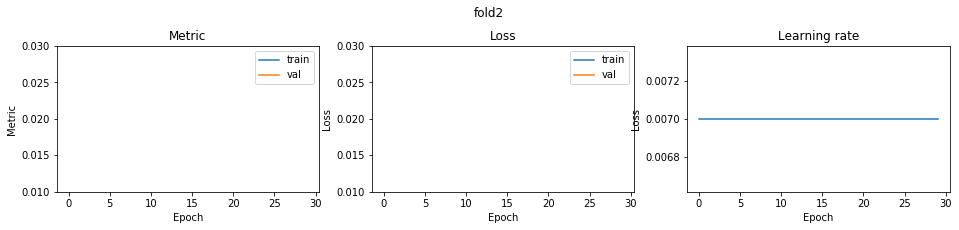

fold 3


epoch1 save best model... 0.7595651931806143
epoch6 save best model... 0.7394991976525083
epoch7 save best model... 0.6898128608093175
epoch9 save best model... 0.5618369180955214
epoch10 save best model... 0.5094885234273376
epoch11 save best model... 0.4459591969677962
epoch12 save best model... 0.36266247765893
epoch14 save best model... 0.3095936350779001
epoch15 save best model... 0.2335095371159986
epoch16 save best model... 0.1704081953556228
epoch17 save best model... 0.16550378957275377
epoch18 save best model... 0.16421796571217256
epoch19 save best model... 0.1467398271575604
epoch20 save best model... 0.13168175033630977
epoch21 save best model... 0.11372303277050444
epoch22 save best model... 0.10648799165065033
epoch23 save best model... 0.1007603785443143
epoch24 save best model... 0.0763859119011696
epoch27 save best model... 0.0610449153802661
epoch30 save best model... 0.05052687617735874
fold3 score: 0.0505268753406945


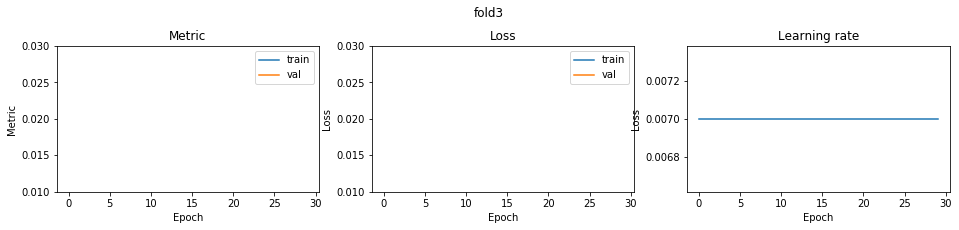

fold 4


epoch1 save best model... 0.747073414439764
epoch8 save best model... 0.6724995746699444
epoch9 save best model... 0.6113537469051422
epoch10 save best model... 0.5455021949591018
epoch11 save best model... 0.47260357629601124
epoch12 save best model... 0.3868954983143166
epoch13 save best model... 0.34158285803295213
epoch14 save best model... 0.29344468466377477
epoch15 save best model... 0.2605732400318213
epoch16 save best model... 0.19410267146410323
epoch17 save best model... 0.16232154776675284
epoch18 save best model... 0.15142555698277196
epoch19 save best model... 0.1311378055729464
epoch20 save best model... 0.12215687116111601
epoch21 save best model... 0.11221637401076412
epoch22 save best model... 0.11000104812323912
epoch23 save best model... 0.08406999967483154
epoch24 save best model... 0.07924213632007802
epoch27 save best model... 0.07410910668229188
epoch28 save best model... 0.06947695521345035
epoch29 save best model... 0.06594598801098
epoch30 save best model... 

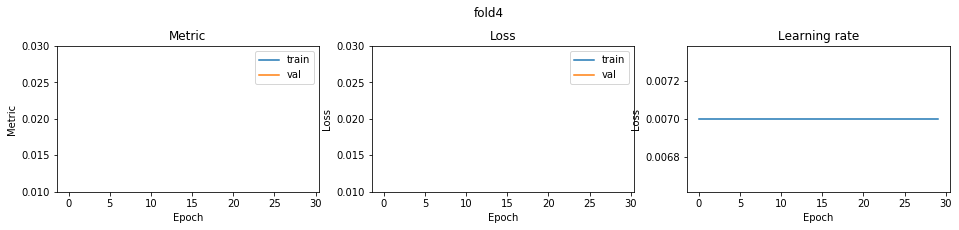

CV score: 0.05505144858141179

optimizer: SGD
fold 0


epoch1 save best model... 0.7111741074396972
epoch2 save best model... 0.7024870130901728
epoch3 save best model... 0.6951021561590034
epoch4 save best model... 0.6871857065274667
epoch5 save best model... 0.6786018584203611
epoch6 save best model... 0.6711494668469614
epoch7 save best model... 0.6645873664451895
epoch8 save best model... 0.655209357619014
epoch9 save best model... 0.6461327862087849
epoch10 save best model... 0.6379356227594519
epoch11 save best model... 0.6257278835311838
epoch12 save best model... 0.6167253335407492
epoch13 save best model... 0.602081663190368
epoch14 save best model... 0.5849182483818645
epoch15 save best model... 0.5663083398803763
epoch16 save best model... 0.5466462553769418
epoch17 save best model... 0.5230726152183255
epoch18 save best model... 0.49951959210267644
epoch19 save best model... 0.47240309736994784
epoch20 save best model... 0.44466591619956464
epoch21 save best model... 0.4119842505264934
epoch22 save best model... 0.3802490013471

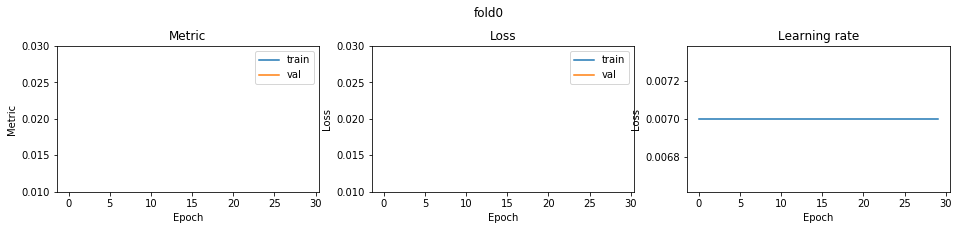

fold 1


epoch1 save best model... 0.7026705107131561
epoch2 save best model... 0.6931119565541121
epoch3 save best model... 0.686758267849609
epoch4 save best model... 0.6792229002769837
epoch5 save best model... 0.6689154337739369
epoch6 save best model... 0.6641727524320855
epoch7 save best model... 0.6551486586052292
epoch8 save best model... 0.6464495986842653
epoch9 save best model... 0.6368810564761662
epoch10 save best model... 0.6278303728529521
epoch11 save best model... 0.6154633063502996
epoch12 save best model... 0.6011948203627682
epoch13 save best model... 0.5882949946844163
epoch14 save best model... 0.5724238523944795
epoch15 save best model... 0.5514796716554693
epoch16 save best model... 0.531463295757757
epoch17 save best model... 0.5064735771936663
epoch18 save best model... 0.48322880976317983
epoch19 save best model... 0.4542240219809901
epoch20 save best model... 0.4269755825240782
epoch21 save best model... 0.39425573833278277
epoch22 save best model... 0.36214719865853

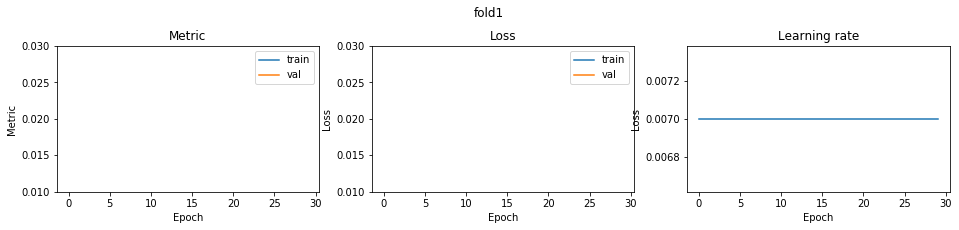

fold 2


epoch1 save best model... 0.7002876559159945
epoch2 save best model... 0.6926497899608695
epoch3 save best model... 0.6843415543141629
epoch4 save best model... 0.6796807418871262
epoch5 save best model... 0.6687377306670256
epoch6 save best model... 0.6613834322680371
epoch7 save best model... 0.6541480095545669
epoch8 save best model... 0.6462401228794125
epoch9 save best model... 0.6366445623706593
epoch10 save best model... 0.6247572150173913
epoch11 save best model... 0.6139956883836591
epoch12 save best model... 0.6009035075436042
epoch13 save best model... 0.585341287110112
epoch14 save best model... 0.5688874790244234
epoch15 save best model... 0.5494748263783866
epoch16 save best model... 0.5277779005360945
epoch17 save best model... 0.503412944712653
epoch18 save best model... 0.4770766110226298
epoch19 save best model... 0.4475850474321101
epoch20 save best model... 0.41747794600276206
epoch21 save best model... 0.3871255017584455
epoch22 save best model... 0.357051602126145

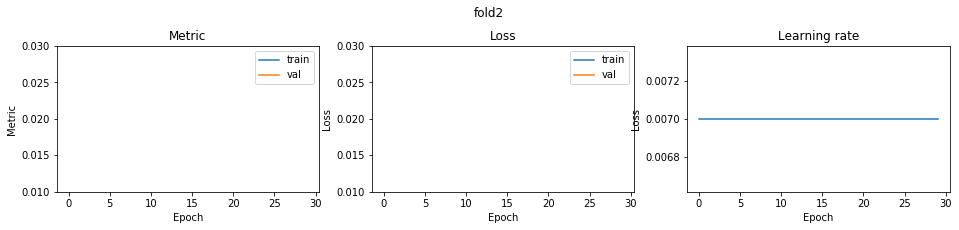

fold 3


epoch1 save best model... 0.7007525637100932
epoch2 save best model... 0.6964613121571465
epoch3 save best model... 0.6884621838773844
epoch4 save best model... 0.679517175803695
epoch5 save best model... 0.673222692925186
epoch6 save best model... 0.6634364757288018
epoch7 save best model... 0.6564932614361235
epoch8 save best model... 0.6488474174349618
epoch9 save best model... 0.6384694021492178
epoch10 save best model... 0.6294117792320686
epoch11 save best model... 0.6167711965043887
epoch12 save best model... 0.60625926750396
epoch13 save best model... 0.5933634747948353
epoch14 save best model... 0.5770344190282539
epoch15 save best model... 0.5561446199927623
epoch16 save best model... 0.5376573106965606
epoch17 save best model... 0.5137638971582904
epoch18 save best model... 0.4893725960292686
epoch19 save best model... 0.4623763540475406
epoch20 save best model... 0.43250949690988233
epoch21 save best model... 0.4028287808824509
epoch22 save best model... 0.36886095792937657

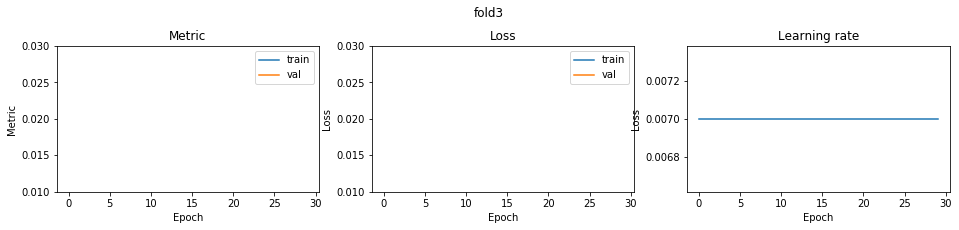

fold 4


epoch1 save best model... 0.7018560722096906
epoch2 save best model... 0.6933618626181791
epoch3 save best model... 0.6855962199067743
epoch4 save best model... 0.6762970485285366
epoch5 save best model... 0.6702364146845216
epoch6 save best model... 0.6629817579764712
epoch7 save best model... 0.653579263046282
epoch8 save best model... 0.6437402862351141
epoch9 save best model... 0.6332736615167935
epoch10 save best model... 0.622136896753637
epoch11 save best model... 0.6104084631848172
epoch12 save best model... 0.5968340021059562
epoch13 save best model... 0.5819044871590947
epoch14 save best model... 0.5654944568397244
epoch15 save best model... 0.5468961237503347
epoch16 save best model... 0.5241273749390605
epoch17 save best model... 0.4986893914555091
epoch18 save best model... 0.47089204735256274
epoch19 save best model... 0.4433938667823079
epoch20 save best model... 0.4108685574933445
epoch21 save best model... 0.37986719331328583
epoch22 save best model... 0.34818757480532

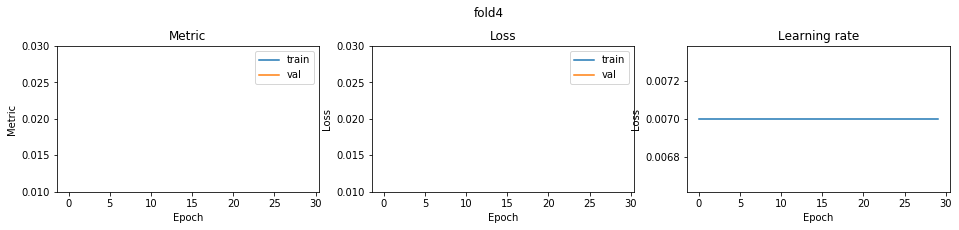

CV score: 0.16226609111624787

optimizer: AdaBelief
fold 0


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.01931046519114515
epoch2 save best model... 0.018179122847345804
epoch3 save best model... 0.01788911209749334
epoch4 save best model... 0.01745444305308995
epoch5 save best model... 0.01723697959171748
epoch6 save best model... 0.017130464309050037
epoch7 save best model... 0.017012793412071427
epoch8 save best model... 0.016920546759216958
epoch9 save best model... 0.016827016991641637
epoch10 save best model... 0.01667812844623805
epoch11 save best model... 0.01665422339543938
epoch12 save best model... 0.016650538871187826
epoch13 save best model... 0.016573246932908858
epoch15 save best model... 0.016510900915738255
epoch16 save best model... 0.016434640039802276
epoch18 save best model... 0.016370297160109924
epoch20 save best model... 0.016330952733195046
fold0 score: 0.016330952693111415


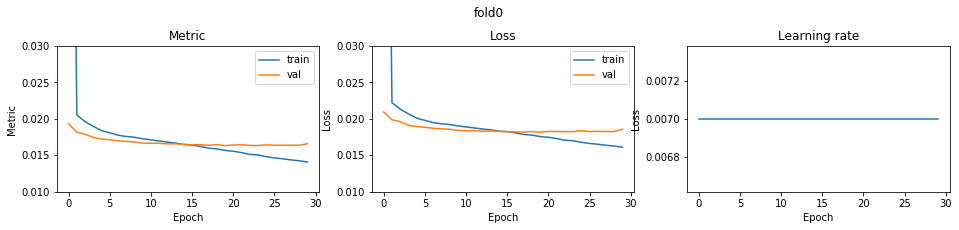

fold 1


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.01953384222700007
epoch2 save best model... 0.01880533613755155
epoch3 save best model... 0.018241520341265905
epoch4 save best model... 0.017729937809984813
epoch5 save best model... 0.017427477049417446
epoch6 save best model... 0.017340741316771137
epoch7 save best model... 0.017234156164133783
epoch8 save best model... 0.017209476081955322
epoch10 save best model... 0.017116730375986527
epoch11 save best model... 0.016944737188046125
epoch12 save best model... 0.016925595241127075
epoch14 save best model... 0.01685110723871825
epoch15 save best model... 0.0167881703412928
epoch17 save best model... 0.01678144188093199
epoch19 save best model... 0.016728982740389742
epoch20 save best model... 0.016694311330323678
fold1 score: 0.01669431123572532


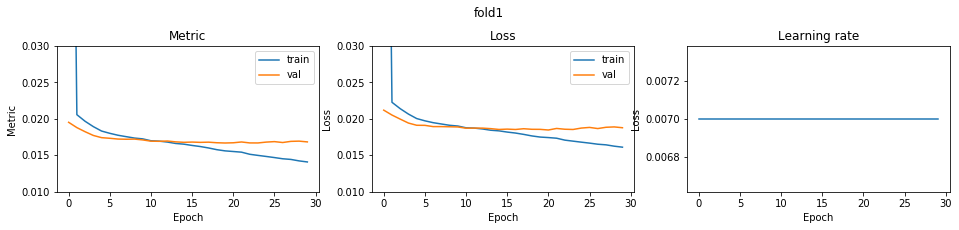

fold 2


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.019637625468829058
epoch2 save best model... 0.01845196268389052
epoch3 save best model... 0.017925406566815308
epoch4 save best model... 0.017585869699650362
epoch5 save best model... 0.01738273507668655
epoch6 save best model... 0.01718049954519433
epoch8 save best model... 0.017027396997736075
epoch9 save best model... 0.017025020001526166
epoch10 save best model... 0.016918536904145954
epoch11 save best model... 0.01677600036662324
epoch13 save best model... 0.016750673707858946
epoch14 save best model... 0.016688922257178544
epoch15 save best model... 0.01661405014287953
epoch18 save best model... 0.01656790821959249
epoch19 save best model... 0.016421081639374748
epoch21 save best model... 0.016418754178534122
epoch25 save best model... 0.016414747852683542
fold2 score: 0.016414747751058344


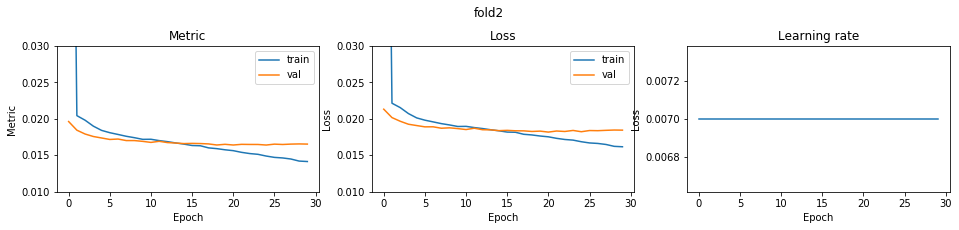

fold 3


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.019403722763044553
epoch2 save best model... 0.01842238197658966
epoch3 save best model... 0.01801696041586187
epoch4 save best model... 0.017679490257640092
epoch5 save best model... 0.01757154074923935
epoch6 save best model... 0.01741584069763813
epoch7 save best model... 0.017360205824883623
epoch8 save best model... 0.01716684739917924
epoch10 save best model... 0.01704601335735962
epoch11 save best model... 0.01695835912358313
epoch12 save best model... 0.016895855209686218
epoch14 save best model... 0.016801250378064524
epoch16 save best model... 0.016700251055520733
epoch19 save best model... 0.016688838315563347
epoch20 save best model... 0.01663430691792169
epoch22 save best model... 0.016608403987995856
epoch23 save best model... 0.016600925553004537
fold3 score: 0.01660092538315768


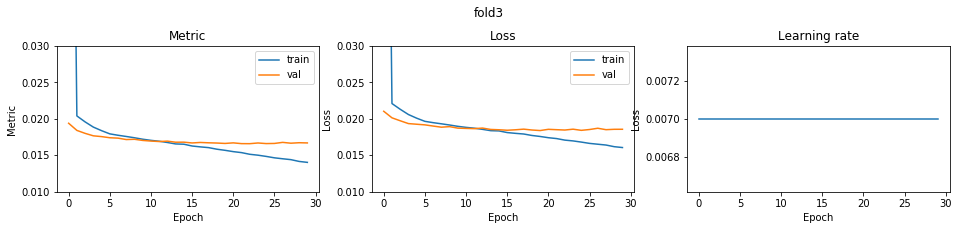

fold 4


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.019316864370926366
epoch2 save best model... 0.018140232857902255
epoch3 save best model... 0.018007228764491092
epoch4 save best model... 0.017574360070576157
epoch5 save best model... 0.01734463438892351
epoch6 save best model... 0.017265071301107934
epoch7 save best model... 0.017105061377150458
epoch8 save best model... 0.01710112011081333
epoch9 save best model... 0.01693429355477757
epoch11 save best model... 0.01692366964716235
epoch12 save best model... 0.01681930053987644
epoch13 save best model... 0.016801363246299005
epoch15 save best model... 0.016749814829888812
epoch18 save best model... 0.01661346368873513
epoch22 save best model... 0.016540828386241047
fold4 score: 0.016540828369053302


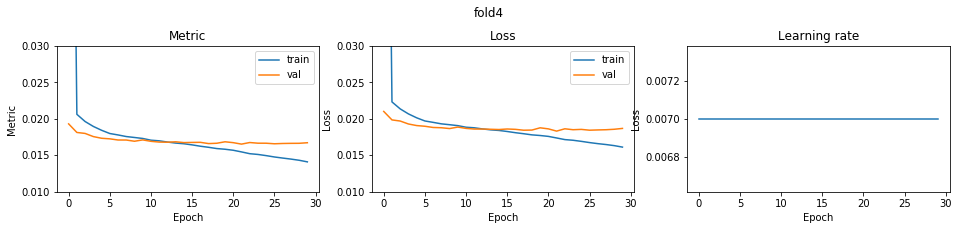

CV score: 0.01651634960761613

optimizer: AdaBound
fold 0


epoch1 save best model... 0.03062942594137034
epoch2 save best model... 0.0304543371004708
fold0 score: 0.030454337026349015


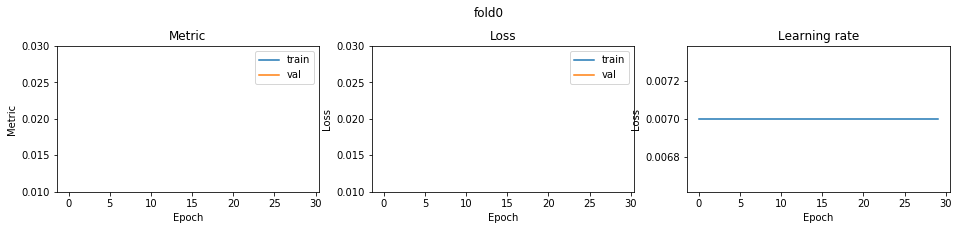

fold 1


epoch1 save best model... 0.03068258765534052
epoch2 save best model... 0.030420644905211906
fold1 score: 0.03042064480765073


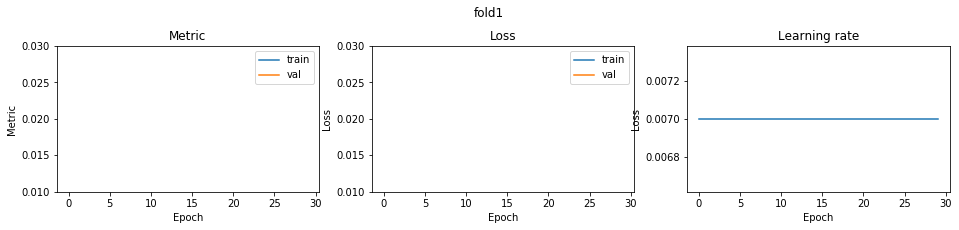

fold 2


epoch1 save best model... 0.03083272424638339
epoch2 save best model... 0.030613725238086475
fold2 score: 0.03061372512618356


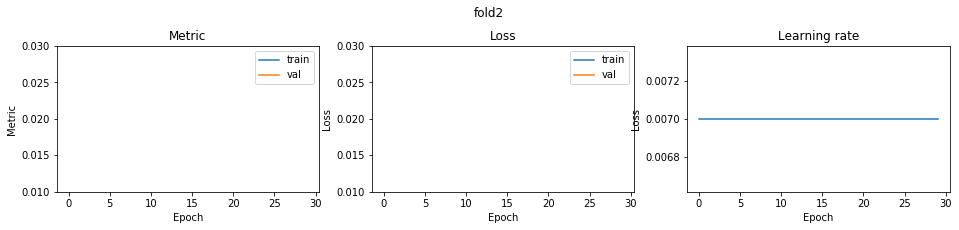

fold 3


epoch1 save best model... 0.03054844433853322
epoch2 save best model... 0.03037867231510902
fold3 score: 0.03037867218161309


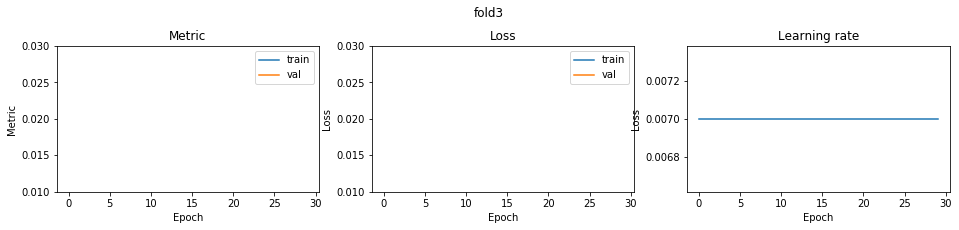

fold 4


epoch1 save best model... 0.030815131919021486
epoch2 save best model... 0.03055094006664389
epoch3 save best model... 0.030509016942869286
fold4 score: 0.030509016810401073


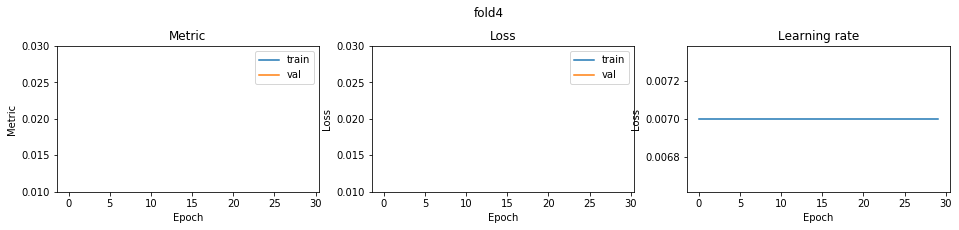

CV score: 0.03047527537179757

optimizer: AdaMod
fold 0


epoch1 save best model... 0.020018772692642343
epoch2 save best model... 0.018700592157034235
epoch3 save best model... 0.017951901728003063
epoch4 save best model... 0.017564254414485364
epoch5 save best model... 0.017477551540508358
epoch6 save best model... 0.017257339065228344
epoch7 save best model... 0.017112444347122807
epoch8 save best model... 0.01693176270753213
epoch9 save best model... 0.016893928868012983
epoch10 save best model... 0.01689018293417532
epoch11 save best model... 0.01670186126048853
epoch12 save best model... 0.016560460547311973
epoch14 save best model... 0.016478927110179682
epoch15 save best model... 0.016456391986943188
epoch18 save best model... 0.016389403677203932
epoch19 save best model... 0.016388243470756774
epoch20 save best model... 0.0162838010036796
fold0 score: 0.016283800849265204


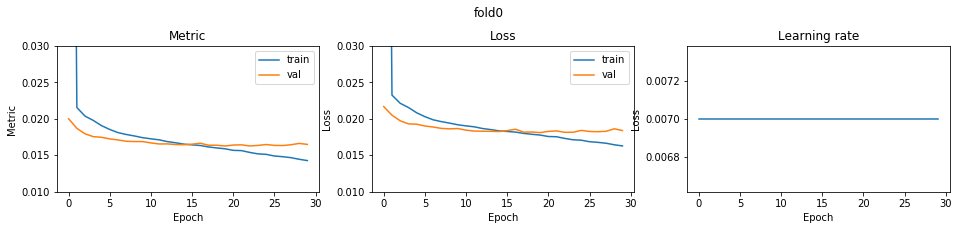

fold 1


epoch1 save best model... 0.020061858026805216
epoch2 save best model... 0.018968963477820816
epoch3 save best model... 0.018118968098934703
epoch4 save best model... 0.01790767671202141
epoch5 save best model... 0.017603258690381953
epoch6 save best model... 0.017397495570613167
epoch8 save best model... 0.017103722267655802
epoch10 save best model... 0.01693462135364028
epoch12 save best model... 0.016871104145065666
epoch16 save best model... 0.01680941856450319
epoch17 save best model... 0.0167320301876365
epoch19 save best model... 0.01670954087683343
fold1 score: 0.01670954075674763


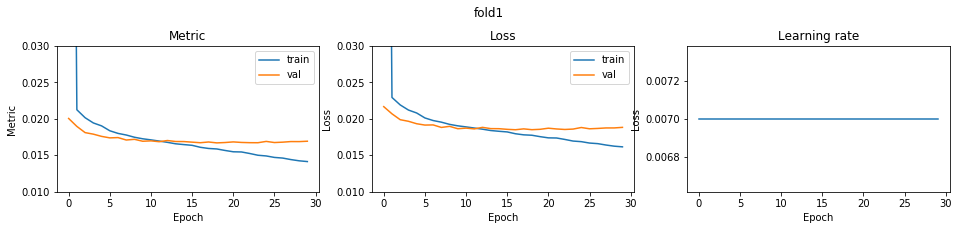

fold 2


epoch1 save best model... 0.020095851005828037
epoch2 save best model... 0.018599595136959152
epoch3 save best model... 0.018137024533479734
epoch4 save best model... 0.017625839173824348
epoch5 save best model... 0.017569305826132146
epoch6 save best model... 0.017354145238257047
epoch7 save best model... 0.01720058062833374
epoch8 save best model... 0.01688033515469893
epoch11 save best model... 0.01679260028692972
epoch12 save best model... 0.016704103790391656
epoch13 save best model... 0.01667014359927077
epoch14 save best model... 0.016628045933123777
epoch15 save best model... 0.016531495321826364
epoch19 save best model... 0.016516178402023535
epoch20 save best model... 0.016502257521603978
epoch22 save best model... 0.01648953609681192
epoch23 save best model... 0.016455371320284996
epoch24 save best model... 0.016407276983301782
fold2 score: 0.016407276882413765


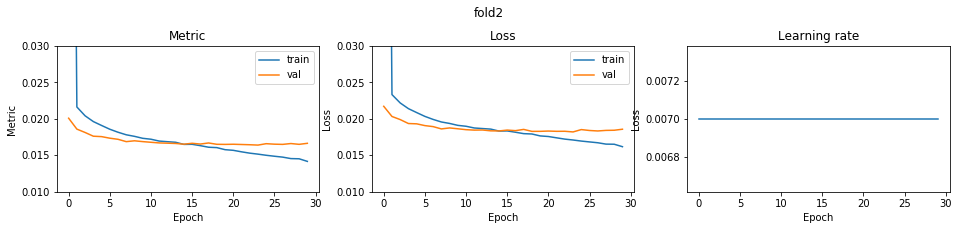

fold 3


epoch1 save best model... 0.020243372907755994
epoch2 save best model... 0.0186811431160447
epoch3 save best model... 0.018117477542854386
epoch4 save best model... 0.017755537730024317
epoch5 save best model... 0.01752131846192418
epoch6 save best model... 0.017460823329780804
epoch7 save best model... 0.01727970964858703
epoch8 save best model... 0.01713760927412871
epoch9 save best model... 0.017085169525159382
epoch10 save best model... 0.01705954241224804
epoch11 save best model... 0.01686882906824622
epoch14 save best model... 0.01682807215763116
epoch15 save best model... 0.016695945028529623
epoch16 save best model... 0.016688598842192485
epoch18 save best model... 0.016668711825441527
epoch19 save best model... 0.01666307940120238
epoch20 save best model... 0.01661161331625354
fold3 score: 0.01661161317258679


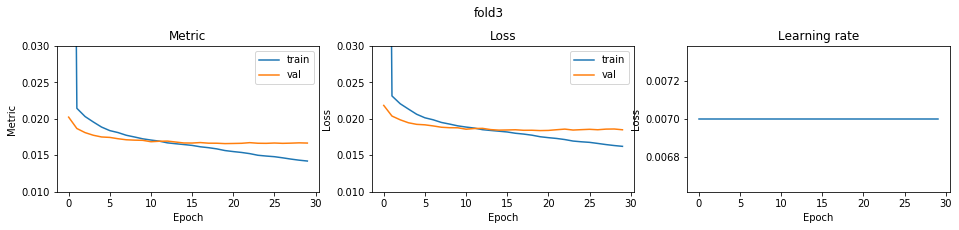

fold 4


epoch1 save best model... 0.01971782513200422
epoch2 save best model... 0.01833368806478171
epoch3 save best model... 0.01796243785920814
epoch4 save best model... 0.017719119404079837
epoch5 save best model... 0.017342972281921425
epoch6 save best model... 0.017276128859244337
epoch7 save best model... 0.01711900813127433
epoch8 save best model... 0.01690344019052583
epoch10 save best model... 0.016860528534240086
epoch11 save best model... 0.016857497318985115
epoch12 save best model... 0.01682249581513413
epoch13 save best model... 0.01670589388681232
epoch16 save best model... 0.01664907799944587
epoch17 save best model... 0.016618698325797338
epoch20 save best model... 0.01659051143354259
epoch23 save best model... 0.01657203601541715
epoch27 save best model... 0.01656652237362905
fold4 score: 0.01656652234446675


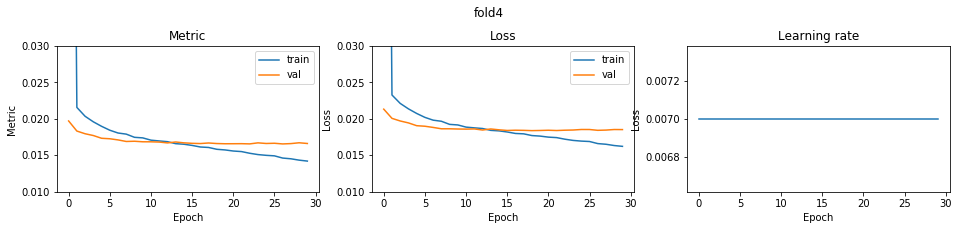

CV score: 0.016515746913906445

optimizer: AdamW
fold 0


epoch1 save best model... 0.01988493982694008
epoch2 save best model... 0.01853189942318785
epoch3 save best model... 0.017842380470831736
epoch4 save best model... 0.017417209777887698
epoch5 save best model... 0.01734446105303281
epoch6 save best model... 0.017053076534071652
epoch7 save best model... 0.01698240602393221
epoch8 save best model... 0.01688667701001455
epoch9 save best model... 0.016781333681187487
epoch11 save best model... 0.016665313344508204
epoch12 save best model... 0.016597506722142594
epoch14 save best model... 0.016559864037536544
epoch15 save best model... 0.016522463830718283
epoch17 save best model... 0.01639700602816422
epoch18 save best model... 0.016390563514940695
epoch19 save best model... 0.016369536198709577
epoch27 save best model... 0.016358471275275416
fold0 score: 0.016358471201762818


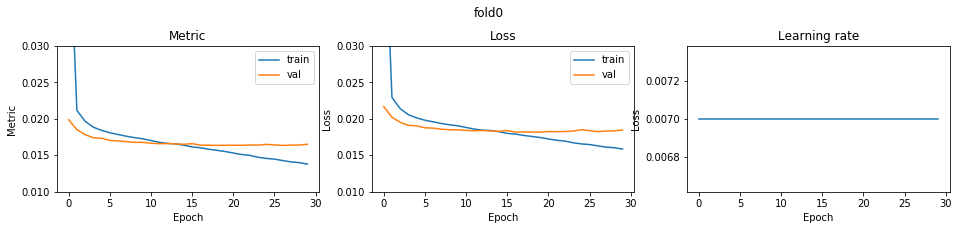

fold 1


epoch1 save best model... 0.020090448136419553
epoch2 save best model... 0.018645166027522843
epoch3 save best model... 0.018154895443220593
epoch4 save best model... 0.01770537484740241
epoch5 save best model... 0.017536046426071886
epoch6 save best model... 0.017252609208412935
epoch7 save best model... 0.017248835269931265
epoch8 save best model... 0.017101446753565123
epoch9 save best model... 0.017036581439118664
epoch10 save best model... 0.016988301966708568
epoch11 save best model... 0.016887338567201763
epoch13 save best model... 0.016810413410958843
epoch15 save best model... 0.0167883922630065
epoch16 save best model... 0.01677925516671942
epoch17 save best model... 0.01671168532992352
epoch19 save best model... 0.016687252542004413
epoch24 save best model... 0.01668465552449661
fold1 score: 0.01668465551924327


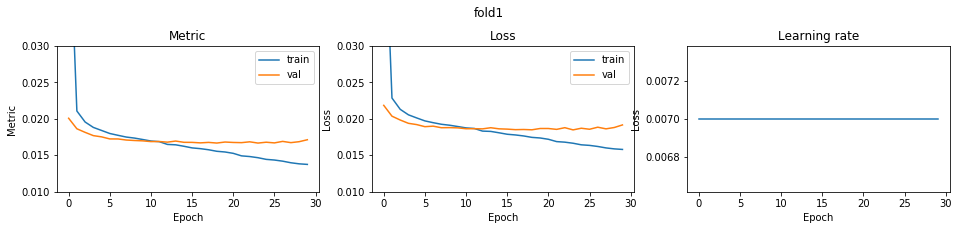

fold 2


epoch1 save best model... 0.01991458819348575
epoch2 save best model... 0.018858365909981346
epoch3 save best model... 0.017896258787863766
epoch4 save best model... 0.017486407706506786
epoch5 save best model... 0.0173490631019989
epoch6 save best model... 0.017201578214223075
epoch7 save best model... 0.017006206874073393
epoch8 save best model... 0.01696562811037991
epoch9 save best model... 0.016935329540323073
epoch10 save best model... 0.01678714347253372
epoch11 save best model... 0.01677249413892698
epoch12 save best model... 0.016660168868404473
epoch14 save best model... 0.01655293599651279
epoch16 save best model... 0.016515965398641225
epoch17 save best model... 0.01642522329876637
epoch18 save best model... 0.01641452778279306
epoch20 save best model... 0.01630554582005272
fold2 score: 0.0163055457439723


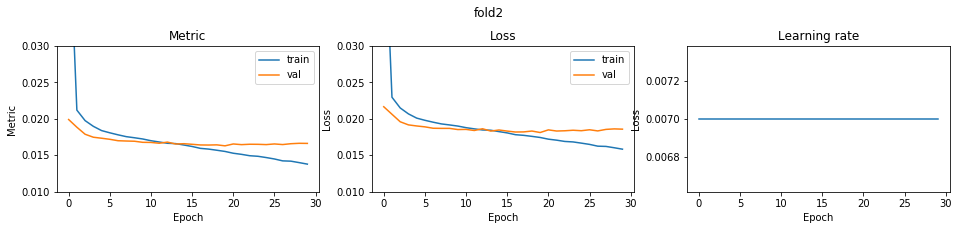

fold 3


epoch1 save best model... 0.019763617383863497
epoch2 save best model... 0.018617562950081733
epoch3 save best model... 0.018062346021735995
epoch4 save best model... 0.017638493429419665
epoch5 save best model... 0.017535336332603575
epoch6 save best model... 0.017349999532493887
epoch7 save best model... 0.017279461801374556
epoch8 save best model... 0.01710262498213721
epoch9 save best model... 0.01702354025638796
epoch10 save best model... 0.01693586607533666
epoch12 save best model... 0.01687095123120416
epoch13 save best model... 0.016729598802117662
epoch16 save best model... 0.01664103796506186
epoch23 save best model... 0.016613851297129122
fold3 score: 0.016613851146371032


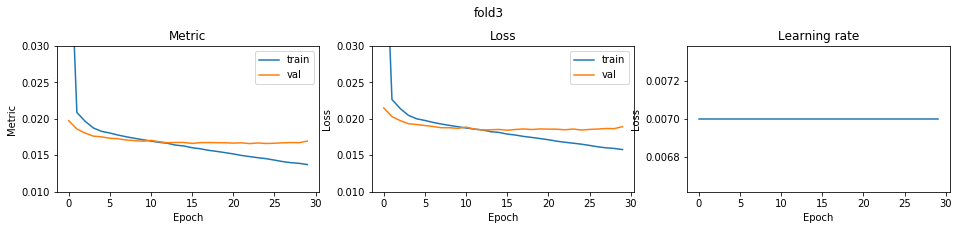

fold 4


epoch1 save best model... 0.020093602961213552
epoch2 save best model... 0.018709124451617716
epoch3 save best model... 0.017804209433988177
epoch4 save best model... 0.017605821624109712
epoch5 save best model... 0.017379447113900767
epoch6 save best model... 0.017321546318047682
epoch7 save best model... 0.01712311587523423
epoch8 save best model... 0.017063990546335256
epoch9 save best model... 0.016917769330848594
epoch10 save best model... 0.016842156093660954
epoch11 save best model... 0.016816459454019005
epoch12 save best model... 0.016779184207354157
epoch13 save best model... 0.016766597189280738
epoch15 save best model... 0.01666598402871697
epoch19 save best model... 0.01659224642937099
epoch23 save best model... 0.01659015263589884
epoch24 save best model... 0.016586874836550893
fold4 score: 0.01658610874087116


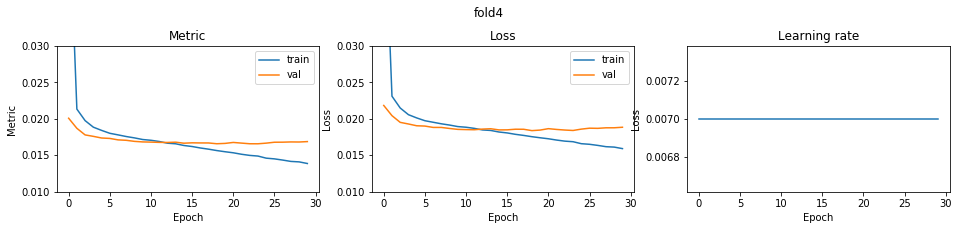

CV score: 0.016509727803216016

optimizer: AdamP
fold 0


epoch1 save best model... 0.020120228023389204
epoch2 save best model... 0.01849398067081029
epoch3 save best model... 0.017878558054770045
epoch4 save best model... 0.017590268035175317
epoch5 save best model... 0.017277524412391127
epoch6 save best model... 0.017211594622675543
epoch7 save best model... 0.017194827475451393
epoch8 save best model... 0.01693720933058403
epoch10 save best model... 0.016805941077768123
epoch13 save best model... 0.016759439482266648
epoch14 save best model... 0.01666692804146329
epoch15 save best model... 0.01663452944885897
epoch16 save best model... 0.01660767833114621
epoch17 save best model... 0.016579134805565
epoch18 save best model... 0.016495631004690037
epoch19 save best model... 0.016475590710487886
epoch21 save best model... 0.016420060373706944
epoch23 save best model... 0.01641080221012744
epoch24 save best model... 0.016396542538831473
epoch28 save best model... 0.016343150263681907
epoch29 save best model... 0.01633072107275078
fold0 scor

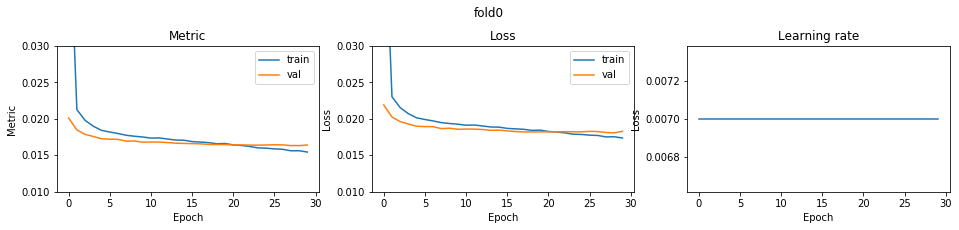

fold 1


epoch1 save best model... 0.01974430241838257
epoch2 save best model... 0.018780060456231776
epoch3 save best model... 0.017969421135661853
epoch4 save best model... 0.017654093142830583
epoch5 save best model... 0.017419481072400853
epoch6 save best model... 0.017413607755441225
epoch7 save best model... 0.017412892853220303
epoch8 save best model... 0.01719206947333369
epoch9 save best model... 0.017136467436545393
epoch10 save best model... 0.017115341685330385
epoch12 save best model... 0.016890941833660064
epoch13 save best model... 0.01688673934207728
epoch14 save best model... 0.016871183557025486
epoch15 save best model... 0.016738580211557365
epoch20 save best model... 0.01672928578435261
epoch23 save best model... 0.016662669446175896
epoch25 save best model... 0.016615959276494226
epoch26 save best model... 0.016606145810211106
epoch27 save best model... 0.01655960057162497
fold1 score: 0.016559600501497213


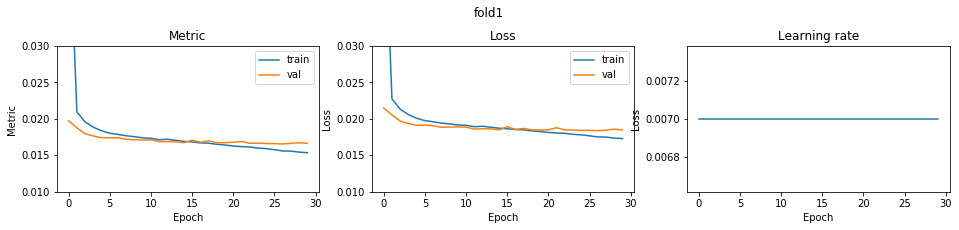

fold 2


epoch1 save best model... 0.01977900963078859
epoch2 save best model... 0.018741922566145625
epoch3 save best model... 0.017910912658829953
epoch4 save best model... 0.017603117565835127
epoch5 save best model... 0.017313498576288614
epoch6 save best model... 0.017225826303199812
epoch7 save best model... 0.01704177686973887
epoch8 save best model... 0.016968252162130132
epoch9 save best model... 0.01690960249645641
epoch10 save best model... 0.016884635725646607
epoch12 save best model... 0.016845860665141654
epoch14 save best model... 0.016676023836960808
epoch18 save best model... 0.016629356624400272
epoch20 save best model... 0.01656256645440879
epoch22 save best model... 0.016557705331246602
epoch23 save best model... 0.01654190528568319
epoch24 save best model... 0.016477795741521882
epoch28 save best model... 0.016418759057102657
epoch29 save best model... 0.016402932931536433
epoch30 save best model... 0.01635535550956256
fold2 score: 0.016355355452719413


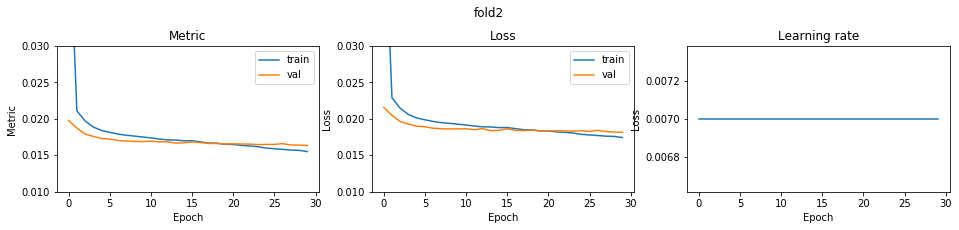

fold 3


epoch1 save best model... 0.020121655574149043
epoch2 save best model... 0.018611307110815628
epoch3 save best model... 0.018118417386924487
epoch4 save best model... 0.01779849562149045
epoch5 save best model... 0.017454324908350895
epoch6 save best model... 0.017381483825148508
epoch7 save best model... 0.017348851460394936
epoch8 save best model... 0.017187534335890365
epoch9 save best model... 0.017110514030250847
epoch10 save best model... 0.017068612258584324
epoch11 save best model... 0.016955221994676053
epoch12 save best model... 0.016907538552948853
epoch14 save best model... 0.016824057755529337
epoch17 save best model... 0.01680591636059428
epoch18 save best model... 0.016688349921519366
epoch20 save best model... 0.01663847173774161
epoch24 save best model... 0.01659366064291269
epoch27 save best model... 0.01656828606140573
fold3 score: 0.016568285884678076


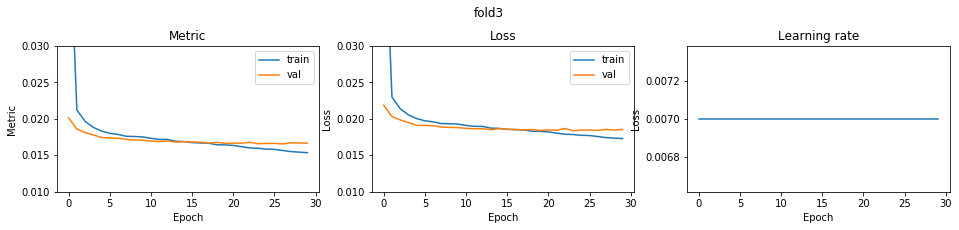

fold 4


epoch1 save best model... 0.019906309512624166
epoch2 save best model... 0.018455125273529924
epoch3 save best model... 0.017766793028945804
epoch4 save best model... 0.01752877683126302
epoch5 save best model... 0.01739916534190637
epoch7 save best model... 0.01717696778501696
epoch8 save best model... 0.01706009004434787
epoch10 save best model... 0.016969934088477107
epoch11 save best model... 0.016934500958829913
epoch12 save best model... 0.016876551380342802
epoch13 save best model... 0.016811831149533562
epoch15 save best model... 0.016719353597840308
epoch21 save best model... 0.016623650508633642
epoch22 save best model... 0.01650956024400941
fold4 score: 0.016509560187565164


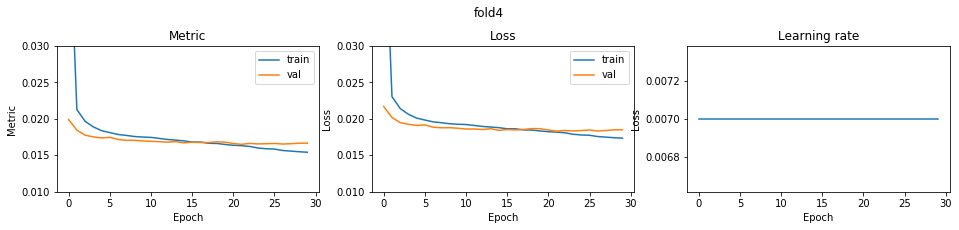

CV score: 0.016464705273118836

optimizer: DiffGrad
fold 0


epoch1 save best model... 0.03161966047654934
fold0 score: 0.031619660693580354


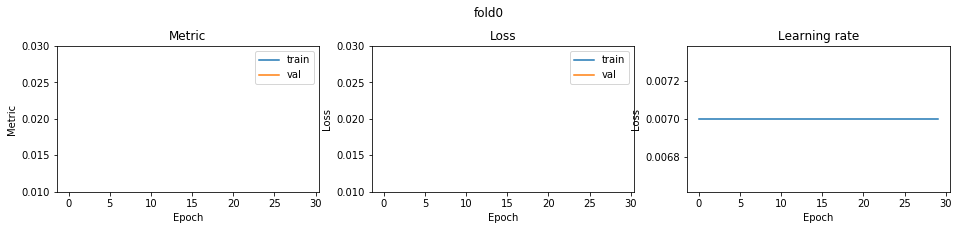

fold 1


epoch1 save best model... 0.03155996029575666
fold1 score: 0.03155996032379552


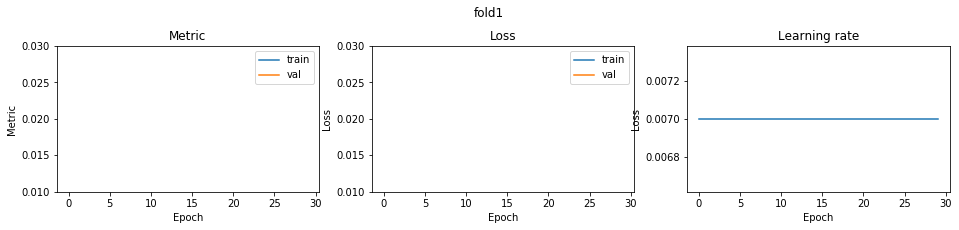

fold 2


epoch1 save best model... 0.03159408865160824
epoch13 save best model... 0.03130984244459472
fold2 score: 0.0313098410237231


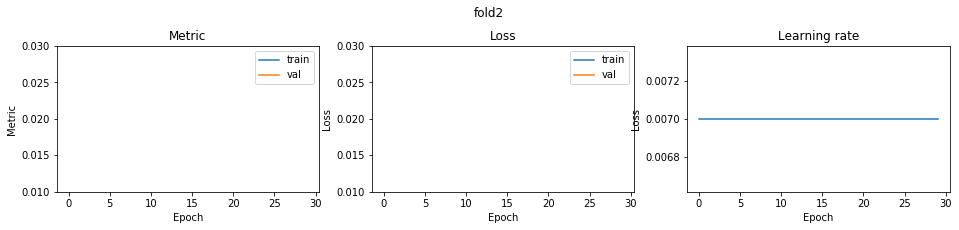

fold 3


epoch1 save best model... 0.03210742255600683
epoch13 save best model... 0.03153197876684758
fold3 score: 0.031531979289397084


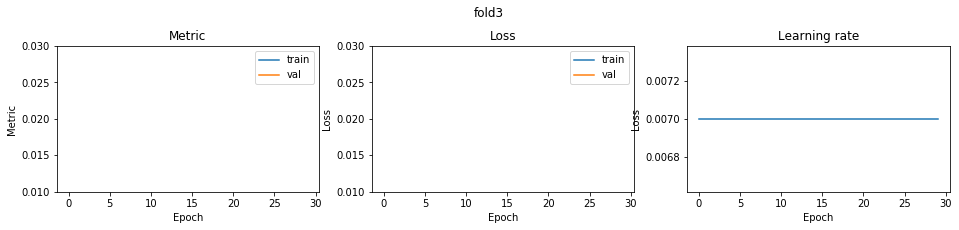

fold 4


epoch1 save best model... 0.030866015565863776
fold4 score: 0.030866015758919008


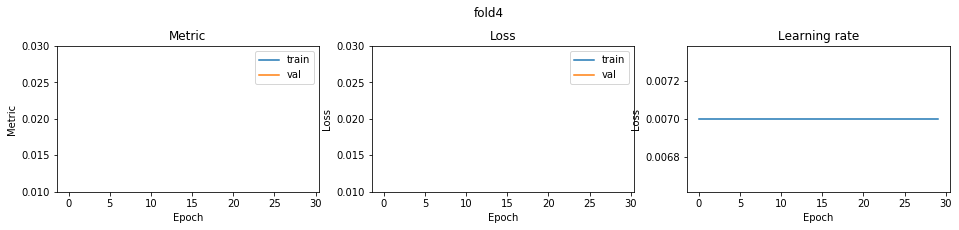

CV score: 0.031377486186494656

optimizer: Lamb
fold 0


epoch1 save best model... 0.019861742739559308
epoch2 save best model... 0.01841762881038672
epoch3 save best model... 0.017847718850864364
epoch4 save best model... 0.017430033214848515
epoch5 save best model... 0.01719916876329105
epoch6 save best model... 0.017062741659734405
epoch7 save best model... 0.016910813051299246
epoch8 save best model... 0.016771475358914947
epoch9 save best model... 0.016679942470408788
epoch10 save best model... 0.016636230756692027
epoch11 save best model... 0.016556276757787734
epoch12 save best model... 0.016467861170988692
epoch13 save best model... 0.01644582416701018
epoch14 save best model... 0.016346776097639546
epoch15 save best model... 0.016301149306373334
fold0 score: 0.0163011491592462


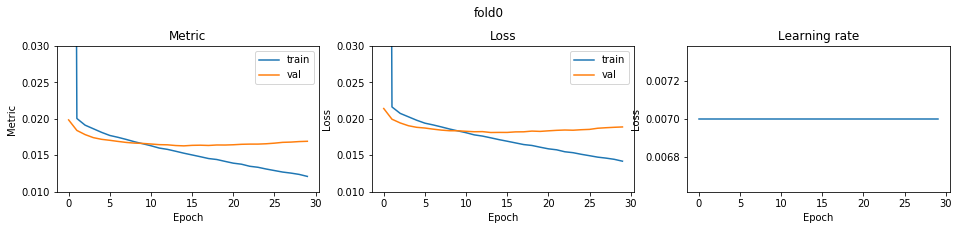

fold 1


epoch1 save best model... 0.02033000194490309
epoch2 save best model... 0.018579691938765637
epoch3 save best model... 0.017988633963252478
epoch4 save best model... 0.01759206363708494
epoch5 save best model... 0.017500892421580795
epoch6 save best model... 0.017272488903071783
epoch7 save best model... 0.017155386641193805
epoch8 save best model... 0.01704487181655888
epoch9 save best model... 0.016943965736572034
epoch10 save best model... 0.01691169883651834
epoch11 save best model... 0.016799041520109016
epoch13 save best model... 0.016772979898660473
epoch14 save best model... 0.016637061849893442
epoch16 save best model... 0.016612986842198793
fold1 score: 0.016612986774056638


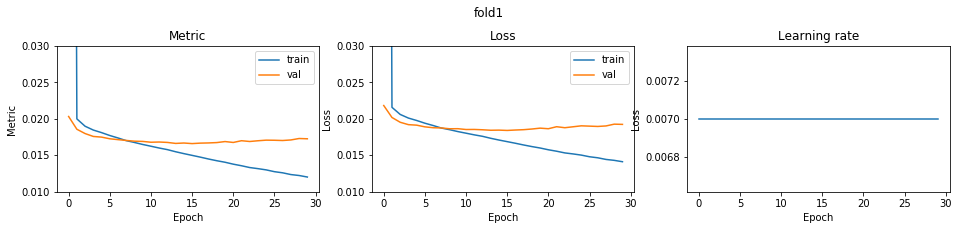

fold 2


epoch1 save best model... 0.02031522570528034
epoch2 save best model... 0.018410217601743963
epoch3 save best model... 0.01786003015828475
epoch4 save best model... 0.017466798384403768
epoch5 save best model... 0.017202026704290198
epoch6 save best model... 0.017189211440420106
epoch7 save best model... 0.016967593963852327
epoch8 save best model... 0.01680906218242967
epoch10 save best model... 0.01663785358739384
epoch11 save best model... 0.01660982579969788
epoch12 save best model... 0.016522473973508752
epoch13 save best model... 0.016443897594223943
epoch18 save best model... 0.016417974287015507
fold2 score: 0.01641797418707856


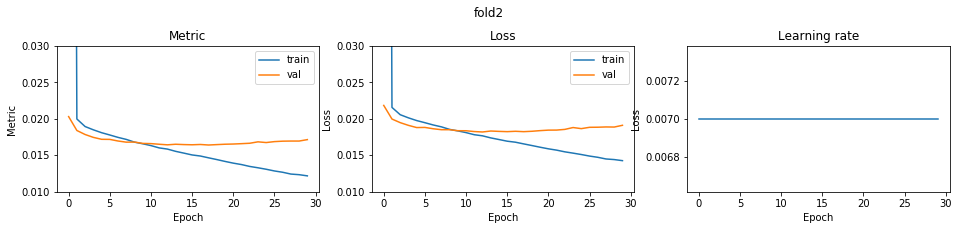

fold 3


epoch1 save best model... 0.0201732294608527
epoch2 save best model... 0.01858336129745549
epoch3 save best model... 0.018003248250226495
epoch4 save best model... 0.017656657224890175
epoch5 save best model... 0.017560033296534033
epoch6 save best model... 0.0172534212389439
epoch7 save best model... 0.017206839025275176
epoch8 save best model... 0.01706480820724796
epoch9 save best model... 0.016951967344740256
epoch10 save best model... 0.01679688170891688
epoch11 save best model... 0.016789868683182975
epoch12 save best model... 0.016670128540188955
epoch13 save best model... 0.016595389864965424
epoch16 save best model... 0.01654493372530967
epoch19 save best model... 0.01651122989620937
fold3 score: 0.016511229821147968


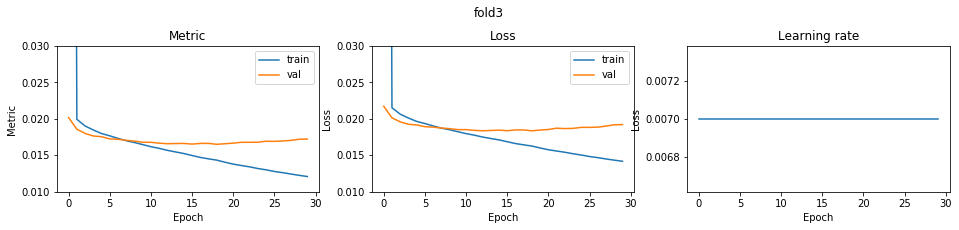

fold 4


epoch1 save best model... 0.020127344434414746
epoch2 save best model... 0.018360146346389567
epoch3 save best model... 0.017922120197232737
epoch4 save best model... 0.017583334723865116
epoch5 save best model... 0.01748085261995062
epoch6 save best model... 0.01722288653593943
epoch7 save best model... 0.017185619473457335
epoch8 save best model... 0.016976722566186025
epoch9 save best model... 0.01686168009699545
epoch10 save best model... 0.016809762488193554
epoch11 save best model... 0.01674342629688544
epoch14 save best model... 0.016670557134837796
epoch15 save best model... 0.016661266469585462
epoch16 save best model... 0.01664844130829893
fold4 score: 0.016648441117694156


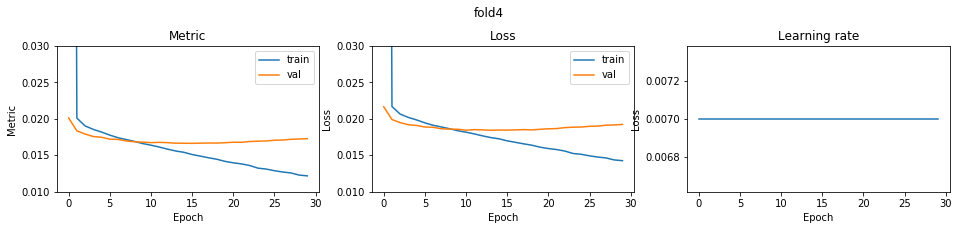

CV score: 0.01649835465140469

optimizer: NovoGrad
fold 0


epoch1 save best model... 0.0185088275759937
epoch2 save best model... 0.017781095436704187
epoch3 save best model... 0.017365722934416322
epoch4 save best model... 0.01707745941444926
epoch5 save best model... 0.016968410761691716
epoch6 save best model... 0.01679358237543926
epoch7 save best model... 0.01666996349540278
epoch8 save best model... 0.016569319186660044
epoch9 save best model... 0.016539055340263592
epoch10 save best model... 0.016453307863655828
epoch14 save best model... 0.016445267825453184
epoch15 save best model... 0.01640859403114995
epoch17 save best model... 0.0164038922523142
epoch19 save best model... 0.01631823237603509
epoch21 save best model... 0.016313329496864305
fold0 score: 0.016313329559164477


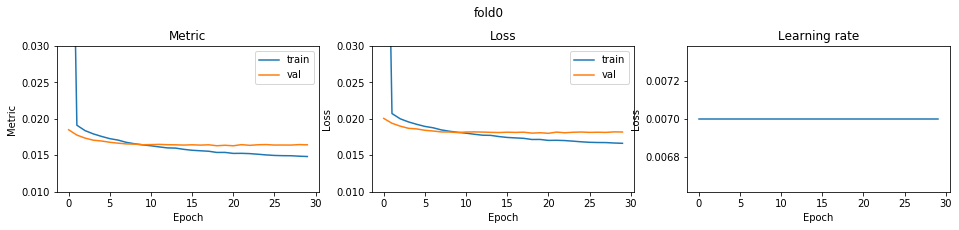

fold 1


epoch1 save best model... 0.01872282721803329
epoch2 save best model... 0.017872777366219228
epoch3 save best model... 0.017594804413536873
epoch4 save best model... 0.017292766774734868
epoch5 save best model... 0.017231773129711258
epoch6 save best model... 0.017050445868319004
epoch7 save best model... 0.016978445878996343
epoch8 save best model... 0.01693264118933235
epoch9 save best model... 0.016898421503605154
epoch10 save best model... 0.016825636398954555
epoch12 save best model... 0.016798388731735298
epoch13 save best model... 0.01674925765809029
epoch14 save best model... 0.016719168354454753
epoch16 save best model... 0.01661134311981545
fold1 score: 0.016611343201388837


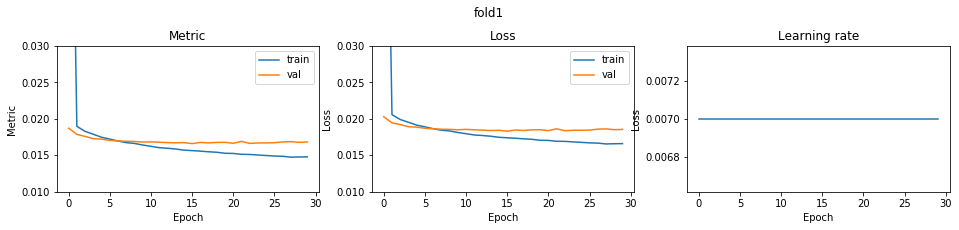

fold 2


epoch1 save best model... 0.018550055581073904
epoch2 save best model... 0.017716862666587212
epoch3 save best model... 0.017407665622888924
epoch4 save best model... 0.01709794993012614
epoch5 save best model... 0.017026226898609886
epoch6 save best model... 0.01686626172623043
epoch7 save best model... 0.01685932761460957
epoch8 save best model... 0.016696848522292015
epoch9 save best model... 0.016559739315559364
epoch12 save best model... 0.016533352780724733
epoch13 save best model... 0.016532689290098705
epoch14 save best model... 0.016489245062432954
epoch19 save best model... 0.016453341539973795
fold2 score: 0.016453341553969054


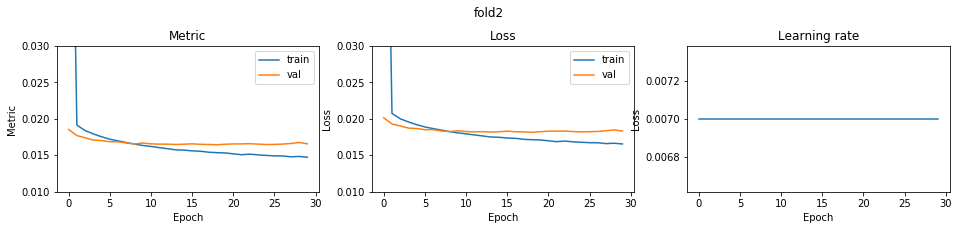

fold 3


epoch1 save best model... 0.018710867211579055
epoch2 save best model... 0.01799531677750561
epoch3 save best model... 0.017520249896345486
epoch4 save best model... 0.01738250304166236
epoch5 save best model... 0.017160542274916497
epoch6 save best model... 0.017027213810974887
epoch7 save best model... 0.016941593816516613
epoch8 save best model... 0.016838705977997775
epoch10 save best model... 0.016838556762725318
epoch11 save best model... 0.016756286638404894
epoch12 save best model... 0.01673216971617557
epoch13 save best model... 0.016682760953767424
epoch14 save best model... 0.016676581742195308
epoch15 save best model... 0.01652435473334002
fold3 score: 0.01652435458188837


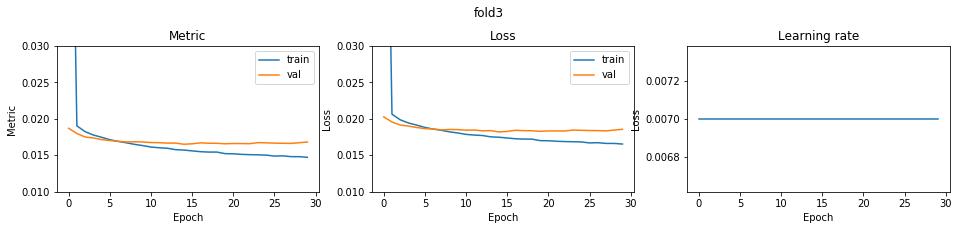

fold 4


epoch1 save best model... 0.01851454101299235
epoch2 save best model... 0.017820079632290133
epoch3 save best model... 0.017488624101636215
epoch4 save best model... 0.017277766426426946
epoch5 save best model... 0.017067960525835292
epoch6 save best model... 0.016938952341302382
epoch8 save best model... 0.016808244916514954
epoch9 save best model... 0.01678649034724488
epoch10 save best model... 0.0167584615935633
epoch11 save best model... 0.016669109198933038
epoch12 save best model... 0.01663773041812529
epoch13 save best model... 0.016628890898256882
epoch16 save best model... 0.016620269116090616
fold4 score: 0.016620268967859755


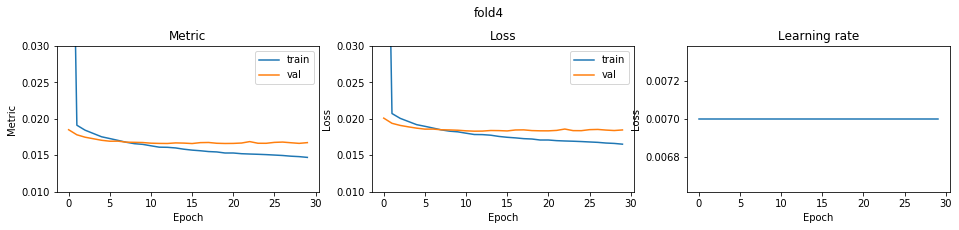

CV score: 0.01650452503824458

optimizer: PlainRAdam
fold 0


epoch1 save best model... 0.020219924211807565
epoch2 save best model... 0.018671824065183452
epoch3 save best model... 0.01845129643034419
epoch4 save best model... 0.01760345980575932
epoch5 save best model... 0.017426987835853138
epoch6 save best model... 0.01723243669948301
epoch7 save best model... 0.017073623661231885
epoch8 save best model... 0.017007492079584092
epoch9 save best model... 0.016975694713193355
epoch10 save best model... 0.016916105579712126
epoch11 save best model... 0.016766385996294184
epoch12 save best model... 0.016737346430913735
epoch14 save best model... 0.016556915108767892
epoch17 save best model... 0.01647308452950116
epoch19 save best model... 0.01646701791546475
epoch23 save best model... 0.016347467816161133
epoch26 save best model... 0.01634423246984805
fold0 score: 0.016344232363907318


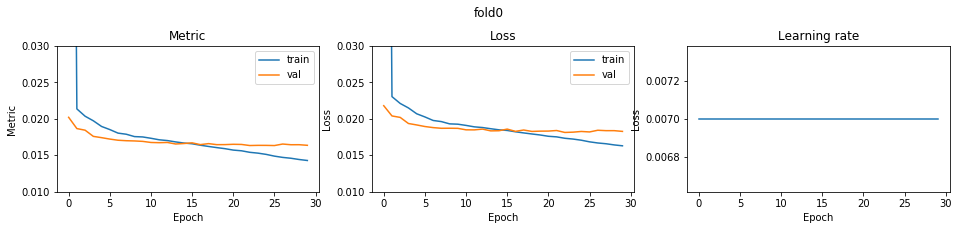

fold 1


epoch1 save best model... 0.020407954000461127
epoch2 save best model... 0.019053243576808085
epoch3 save best model... 0.018457597032898947
epoch4 save best model... 0.018277027943623746
epoch5 save best model... 0.017626641923805718
epoch7 save best model... 0.017301462403114306
epoch8 save best model... 0.017213337156496387
epoch10 save best model... 0.01708209498618439
epoch11 save best model... 0.016995332181525002
epoch12 save best model... 0.0169236818801694
epoch13 save best model... 0.016872554827344854
epoch16 save best model... 0.016848721154208986
epoch18 save best model... 0.0166942918773738
epoch23 save best model... 0.016634674438318474
fold1 score: 0.01663467434034531


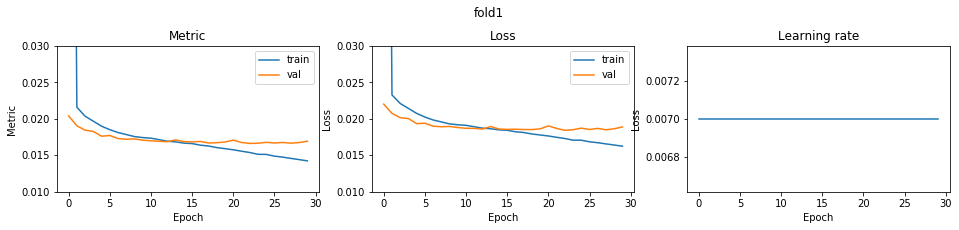

fold 2


epoch1 save best model... 0.020398505319374167
epoch2 save best model... 0.01918677461419936
epoch3 save best model... 0.01901533478104116
epoch4 save best model... 0.018042594707286842
epoch5 save best model... 0.017466780481111843
epoch6 save best model... 0.0174194862834785
epoch7 save best model... 0.017092009127185878
epoch9 save best model... 0.017080310107849404
epoch10 save best model... 0.01693445735577707
epoch11 save best model... 0.016821096441819908
epoch12 save best model... 0.01682050105190258
epoch13 save best model... 0.01671881616322672
epoch15 save best model... 0.016554947508769364
epoch20 save best model... 0.01652209850027733
epoch21 save best model... 0.01649067482783097
epoch25 save best model... 0.016428501929389258
fold2 score: 0.016428501874407746


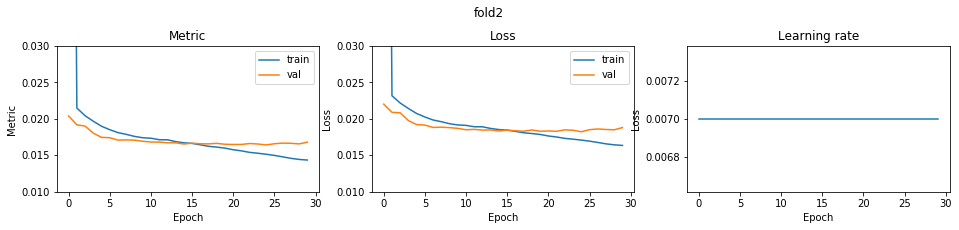

fold 3


epoch1 save best model... 0.021154752658820098
epoch2 save best model... 0.01929215542963602
epoch3 save best model... 0.018580647797699263
epoch4 save best model... 0.01824491269640404
epoch5 save best model... 0.017919095725262357
epoch6 save best model... 0.01766166330733101
epoch7 save best model... 0.01748804659762999
epoch8 save best model... 0.017291273612418723
epoch9 save best model... 0.01717795327577341
epoch11 save best model... 0.017075521582504204
epoch12 save best model... 0.01703002923306137
epoch13 save best model... 0.016996996173876972
epoch14 save best model... 0.016842812209778332
epoch18 save best model... 0.01678916259726047
epoch19 save best model... 0.016692701930388094
epoch22 save best model... 0.016653706421460406
epoch23 save best model... 0.016604639463771585
epoch25 save best model... 0.016589416851181375
fold3 score: 0.01658941674959412


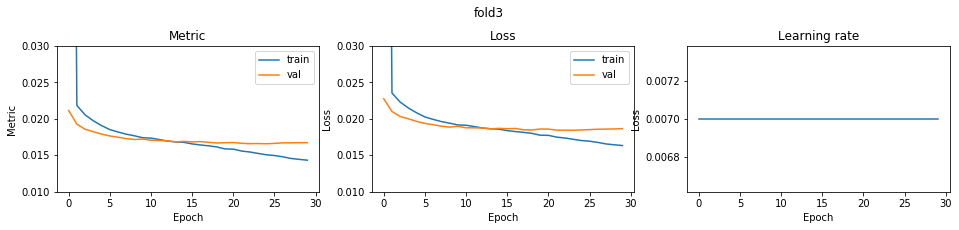

fold 4


epoch1 save best model... 0.01999759880023964
epoch2 save best model... 0.01865432258347444
epoch3 save best model... 0.01798091664706656
epoch4 save best model... 0.017729703404416663
epoch5 save best model... 0.017574902895014895
epoch6 save best model... 0.017307956338964047
epoch7 save best model... 0.01716840377667227
epoch8 save best model... 0.017145898179543588
epoch9 save best model... 0.01707742172664621
epoch10 save best model... 0.01699818746740495
epoch11 save best model... 0.016826516621934934
epoch12 save best model... 0.01679231352671336
epoch14 save best model... 0.016772052268487037
epoch17 save best model... 0.01660370479480009
epoch22 save best model... 0.016523337712541122
fold4 score: 0.016523337613729937


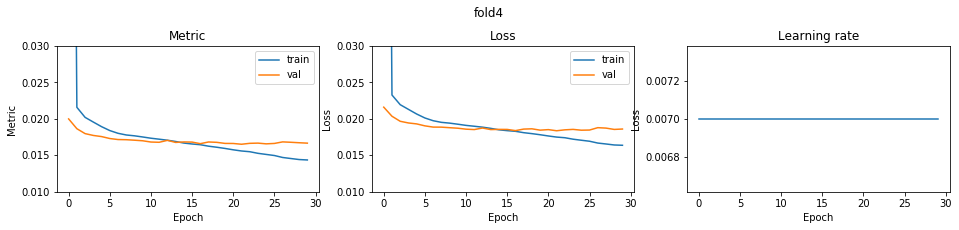

CV score: 0.016504030077414657

optimizer: QHAdam
fold 0


epoch1 save best model... 0.03229385776559829
epoch2 save best model... 0.032252052054657754
epoch10 save best model... 0.03213562857028699
epoch11 save best model... 0.031628599487126284
epoch15 save best model... 0.03161663778703278
epoch16 save best model... 0.031273993659671186
fold0 score: 0.031273993771377344


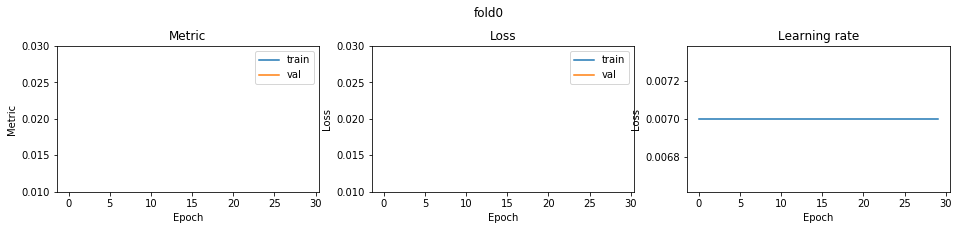

fold 1


epoch1 save best model... 0.03179327243381819
epoch14 save best model... 0.03160829466251339
epoch15 save best model... 0.031575397794353685
fold1 score: 0.031575399149072404


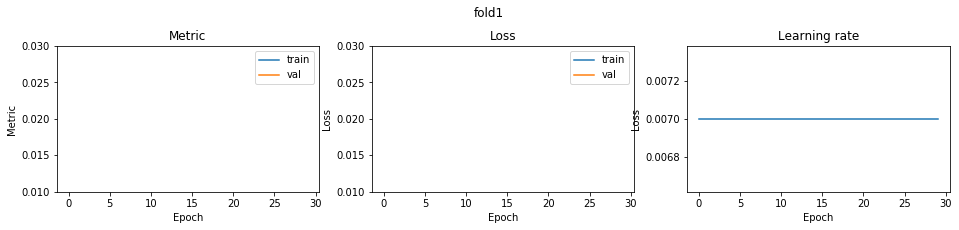

fold 2


epoch1 save best model... 0.03191203288020985
epoch19 save best model... 0.03157335968964408
fold2 score: 0.031573358736158894


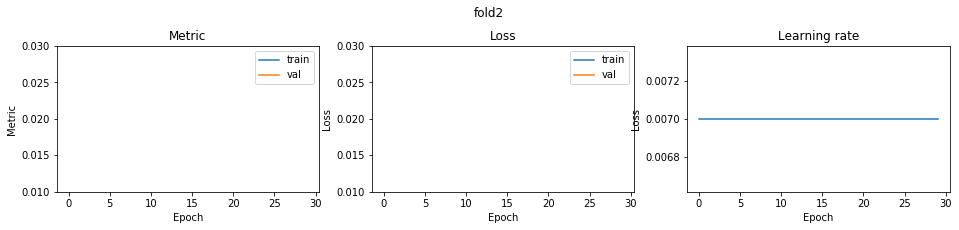

fold 3


epoch1 save best model... 0.032614168965157994
epoch3 save best model... 0.03229520464812433
epoch12 save best model... 0.0320731350299234
fold3 score: 0.032073134957727414


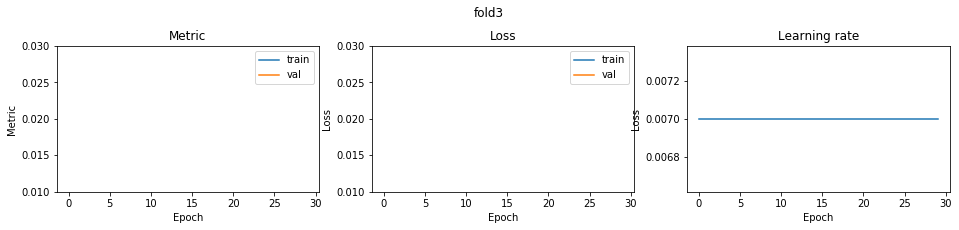

fold 4


epoch1 save best model... 0.032014104885161605
epoch15 save best model... 0.03151530226128248
fold4 score: 0.031515302350664784


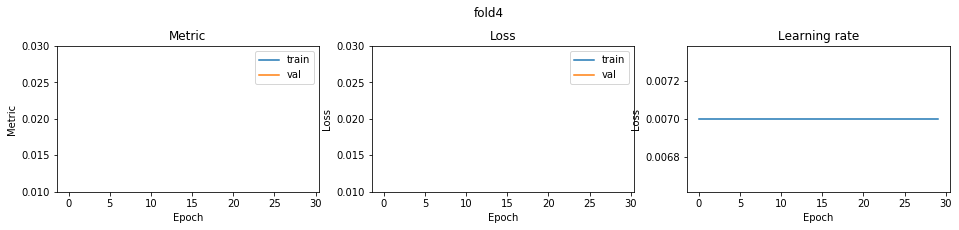

CV score: 0.03160224033162331

optimizer: RAdam
fold 0


epoch1 save best model... 0.020848867411731586
epoch2 save best model... 0.018947854111128083
epoch3 save best model... 0.018106438856834974
epoch4 save best model... 0.017776092809703464
epoch5 save best model... 0.017425354643977313
epoch6 save best model... 0.0174117778565794
epoch7 save best model... 0.0170339510252101
epoch8 save best model... 0.017031667075185677
epoch9 save best model... 0.016963191125923788
epoch10 save best model... 0.016810325695231457
epoch11 save best model... 0.016737413549783017
epoch13 save best model... 0.01669358872895496
epoch14 save best model... 0.016591433006294225
epoch16 save best model... 0.01656835366099869
epoch17 save best model... 0.016547064439039295
epoch18 save best model... 0.016482686097383636
epoch19 save best model... 0.016426552298366346
epoch20 save best model... 0.016379197672060385
epoch23 save best model... 0.016362751324094645
fold0 score: 0.016362751150389133


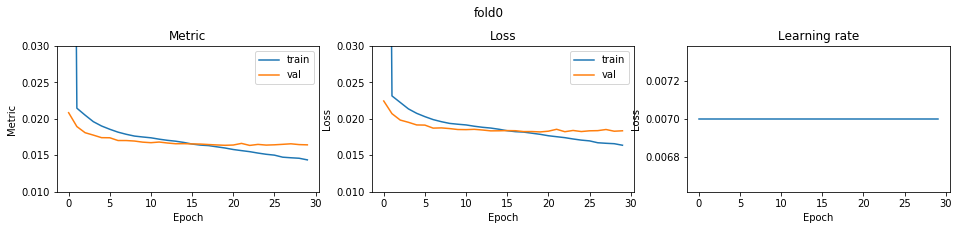

fold 1


epoch1 save best model... 0.020354506311614357
epoch2 save best model... 0.018965579319798774
epoch3 save best model... 0.01855277230101176
epoch4 save best model... 0.018042468528037706
epoch5 save best model... 0.01764357196221009
epoch6 save best model... 0.01738761835934212
epoch7 save best model... 0.017302753850028316
epoch9 save best model... 0.016989064949067465
epoch11 save best model... 0.016980668161710306
epoch13 save best model... 0.016920833703275625
epoch14 save best model... 0.016901494228122146
epoch16 save best model... 0.016709524765101427
epoch23 save best model... 0.01667289907466234
fold1 score: 0.016672899072095203


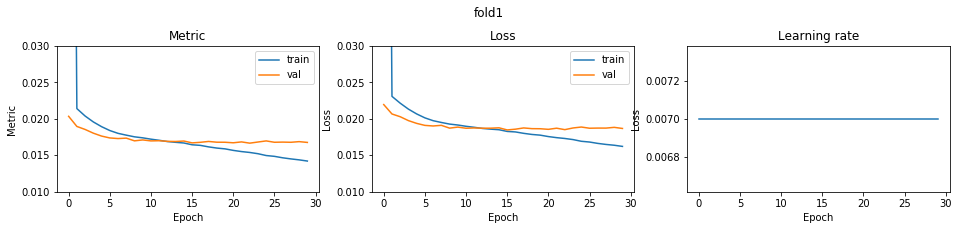

fold 2


epoch1 save best model... 0.02031065853205241
epoch2 save best model... 0.018891797396130512
epoch3 save best model... 0.018457928604106204
epoch4 save best model... 0.01792670300242691
epoch5 save best model... 0.017484707496618936
epoch6 save best model... 0.01734021852502935
epoch7 save best model... 0.017156044343360384
epoch9 save best model... 0.016988312666626735
epoch10 save best model... 0.016926953531283945
epoch12 save best model... 0.016792984811750813
epoch13 save best model... 0.016744938574851875
epoch14 save best model... 0.01663076664189776
epoch17 save best model... 0.016593590104817924
epoch18 save best model... 0.016442431173251046
epoch21 save best model... 0.016422326797286318
epoch23 save best model... 0.01637947829480553
fold2 score: 0.016379478230392146


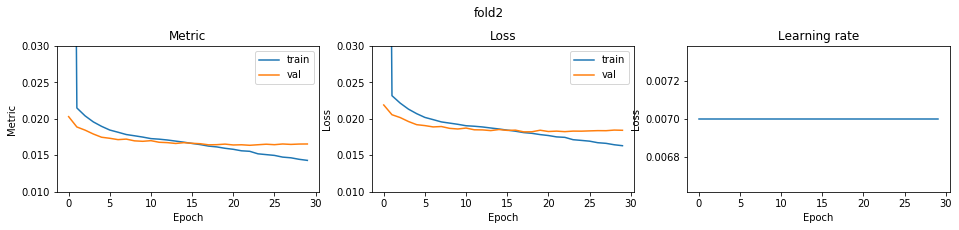

fold 3


epoch1 save best model... 0.020593704045209226
epoch2 save best model... 0.018903991348769914
epoch3 save best model... 0.01840689128184169
epoch4 save best model... 0.01805489557097265
epoch5 save best model... 0.017721674686344446
epoch6 save best model... 0.017582963898794934
epoch7 save best model... 0.01745281158426696
epoch8 save best model... 0.017382960247643853
epoch9 save best model... 0.017260100409083053
epoch10 save best model... 0.017253291997252403
epoch11 save best model... 0.01718785420806913
epoch12 save best model... 0.016987519826663654
epoch13 save best model... 0.016966946772670962
epoch15 save best model... 0.01690862245883173
epoch17 save best model... 0.016843234150668348
epoch18 save best model... 0.016792106213883957
epoch19 save best model... 0.01671614843401591
epoch21 save best model... 0.01660449458052805
fold3 score: 0.016604494538449418


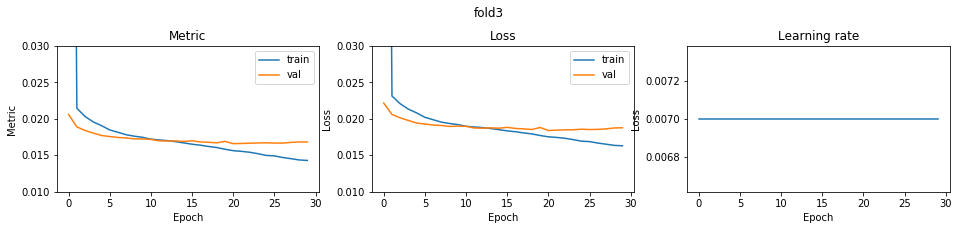

fold 4


epoch1 save best model... 0.02016115747137602
epoch2 save best model... 0.018573730393972646
epoch4 save best model... 0.017738782195268296
epoch5 save best model... 0.01750546831103012
epoch6 save best model... 0.01733363954252765
epoch7 save best model... 0.017168408639491418
epoch9 save best model... 0.017046736656414485
epoch10 save best model... 0.016954671060730085
epoch12 save best model... 0.016945376289596862
epoch13 save best model... 0.016885712282447854
epoch14 save best model... 0.016712857513414836
epoch17 save best model... 0.01662908354158893
epoch21 save best model... 0.01656341938161904
fold4 score: 0.016563419273368223


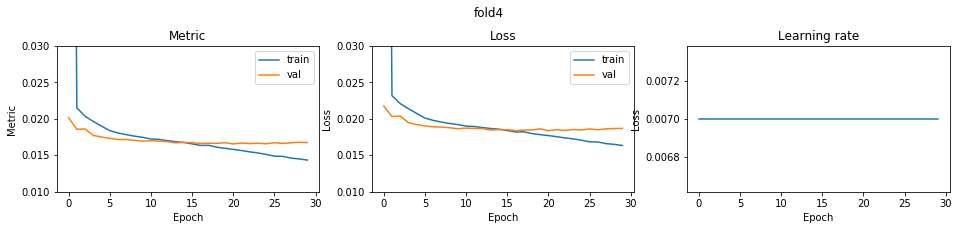

CV score: 0.016516607579948276

optimizer: Ranger
fold 0


epoch1 save best model... 0.021375446917663132
epoch2 save best model... 0.01946112413324229
epoch3 save best model... 0.018353329363845476
epoch4 save best model... 0.018202253353011906
epoch5 save best model... 0.01770702370936751
epoch6 save best model... 0.017318009563927497
epoch7 save best model... 0.017248550348476017
epoch8 save best model... 0.017179083614557097
epoch9 save best model... 0.016876951386995086
epoch10 save best model... 0.016725901314874173
epoch12 save best model... 0.016598254342930465
epoch13 save best model... 0.016582958444375927
epoch14 save best model... 0.016475409127194817
epoch15 save best model... 0.016420560734079204
epoch16 save best model... 0.016383689915621336
epoch17 save best model... 0.016379610772811064
epoch18 save best model... 0.016340884511997597
epoch19 save best model... 0.016309017021472062
epoch21 save best model... 0.01630664443626898
epoch22 save best model... 0.016279128853630503
epoch23 save best model... 0.01627567879567114
epoch

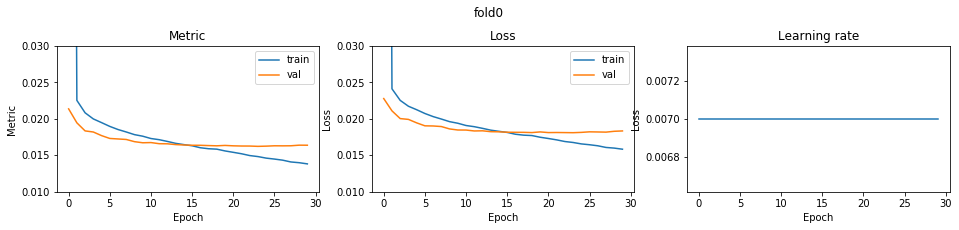

fold 1


epoch1 save best model... 0.021361255878656865
epoch2 save best model... 0.019956560887771497
epoch3 save best model... 0.018625211464629463
epoch4 save best model... 0.01828930698552458
epoch5 save best model... 0.01788477964341084
epoch6 save best model... 0.017484830829488252
epoch8 save best model... 0.01722887386715366
epoch9 save best model... 0.017157505862423324
epoch11 save best model... 0.01695643595444651
epoch12 save best model... 0.016816686227744522
epoch15 save best model... 0.016630513860283243
epoch21 save best model... 0.016615891598052997
fold1 score: 0.016615891531208574


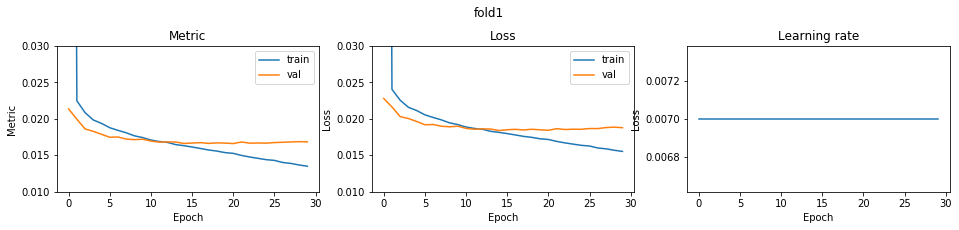

fold 2


epoch1 save best model... 0.021325366283809575
epoch2 save best model... 0.019331158419120798
epoch3 save best model... 0.018561494988248203
epoch4 save best model... 0.0180650304255578
epoch5 save best model... 0.01794240495186205
epoch6 save best model... 0.017453379218001237
epoch7 save best model... 0.01724463428577969
epoch8 save best model... 0.01722536573119039
epoch9 save best model... 0.016958706342761812
epoch10 save best model... 0.016799482604156434
epoch12 save best model... 0.016698800228106648
epoch13 save best model... 0.016630235723523037
epoch14 save best model... 0.016614937529054432
epoch15 save best model... 0.016579680733414957
epoch17 save best model... 0.016497252922353208
epoch18 save best model... 0.016402762121586506
epoch22 save best model... 0.016337311787390306
fold2 score: 0.016337311633040284


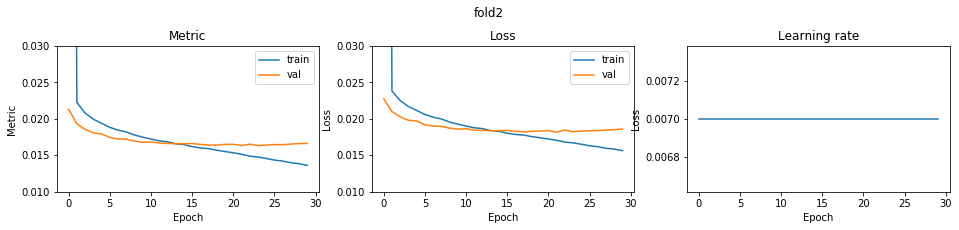

fold 3


epoch1 save best model... 0.021269995607181128
epoch2 save best model... 0.019678494649894688
epoch3 save best model... 0.018788761032876772
epoch4 save best model... 0.018141970502165972
epoch5 save best model... 0.017835187094375187
epoch6 save best model... 0.017561818874421993
epoch7 save best model... 0.017436602535596063
epoch9 save best model... 0.017122809580423295
epoch10 save best model... 0.016995796450500745
epoch11 save best model... 0.016968011668966002
epoch12 save best model... 0.016878361346153437
epoch13 save best model... 0.016774985431810174
epoch14 save best model... 0.01671988801873694
epoch15 save best model... 0.016665492306520698
epoch19 save best model... 0.016594308984289815
epoch24 save best model... 0.016564681899048608
fold3 score: 0.016564681773793655


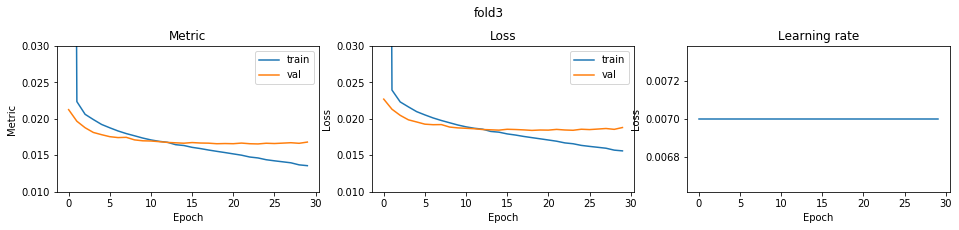

fold 4


epoch1 save best model... 0.021045836516081065
epoch2 save best model... 0.019308768339234495
epoch3 save best model... 0.018384719828826827
epoch4 save best model... 0.017918020705766723
epoch5 save best model... 0.01759503947566677
epoch6 save best model... 0.017349752946703743
epoch7 save best model... 0.01722472189015503
epoch8 save best model... 0.01713932513477862
epoch9 save best model... 0.017010543884068797
epoch10 save best model... 0.01687091969140298
epoch11 save best model... 0.016816615755828882
epoch12 save best model... 0.016770074822449875
epoch13 save best model... 0.016702167139916867
epoch15 save best model... 0.016592503168062225
epoch18 save best model... 0.016561358674919414
epoch19 save best model... 0.01655766802854785
epoch20 save best model... 0.0165173986392066
epoch21 save best model... 0.01650896194456718
fold4 score: 0.016508961799057868


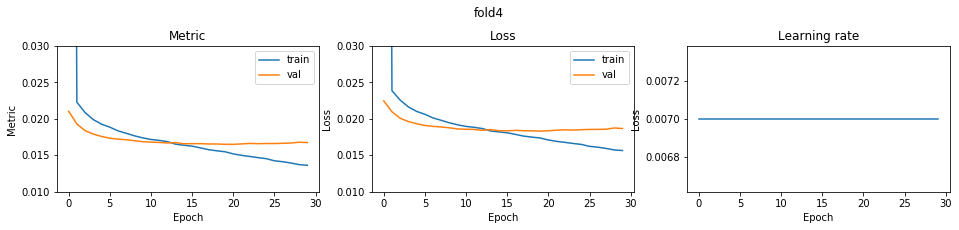

CV score: 0.01645201554263935

optimizer: RangerQH
fold 0


epoch1 save best model... 0.03182099744813317
epoch2 save best model... 0.03175650335135519
epoch12 save best model... 0.03172270582653667
epoch19 save best model... 0.031607362627983096
fold0 score: 0.03160736265990706


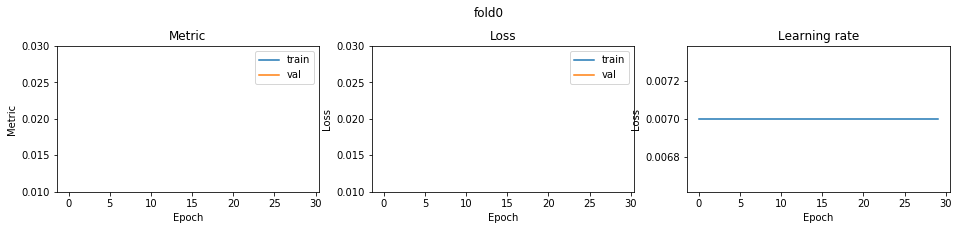

fold 1


epoch1 save best model... 0.03195791193308497
epoch6 save best model... 0.031821452115154615
epoch12 save best model... 0.03174656367544352
fold1 score: 0.03174656279618399


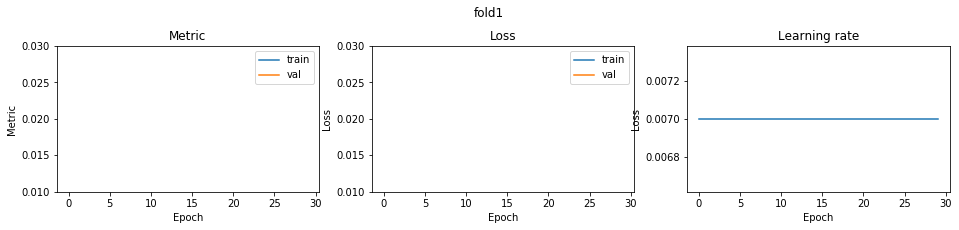

fold 2


epoch1 save best model... 0.03162418773635886
epoch17 save best model... 0.03144697570402195
epoch22 save best model... 0.03138167847446142
fold2 score: 0.031381679016062924


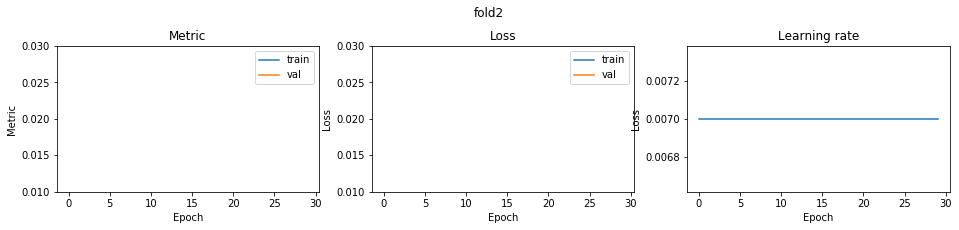

fold 3


epoch1 save best model... 0.031975023997502065
epoch22 save best model... 0.031620037227291994
fold3 score: 0.03162003929155875


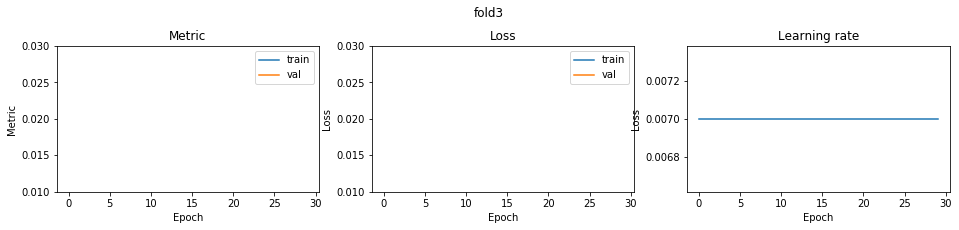

fold 4


epoch1 save best model... 0.03127389282989475
fold4 score: 0.031273892788841295


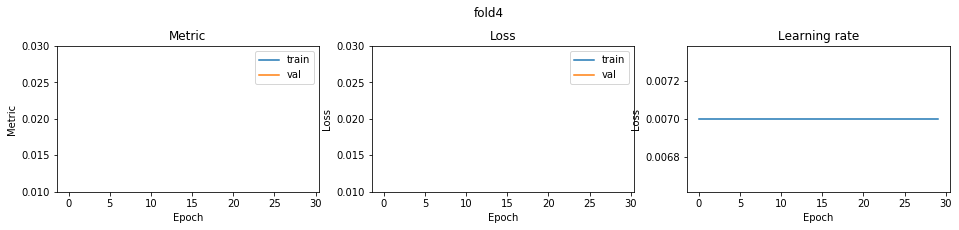

CV score: 0.03152590382831693

optimizer: RangerVA
fold 0


epoch1 save best model... 0.5489717799873178
epoch2 save best model... 0.061008019796265016
epoch3 save best model... 0.02795232652616528
epoch4 save best model... 0.02330432784465695
epoch5 save best model... 0.021872763895771228
epoch6 save best model... 0.02115838870507981
epoch7 save best model... 0.02069785977906817
epoch8 save best model... 0.02039094895446898
epoch9 save best model... 0.020127232714740723
epoch10 save best model... 0.019927204127905038
epoch11 save best model... 0.019670779830807977
epoch12 save best model... 0.019476420835407286
epoch13 save best model... 0.01935077041031152
epoch14 save best model... 0.01917179234257999
epoch15 save best model... 0.019026249313646406
epoch16 save best model... 0.018875432897842825
epoch17 save best model... 0.018739447972667245
epoch18 save best model... 0.01862803143459735
epoch19 save best model... 0.01851048847927727
epoch21 save best model... 0.018396856001915585
epoch22 save best model... 0.018269850332332364
epoch23 save

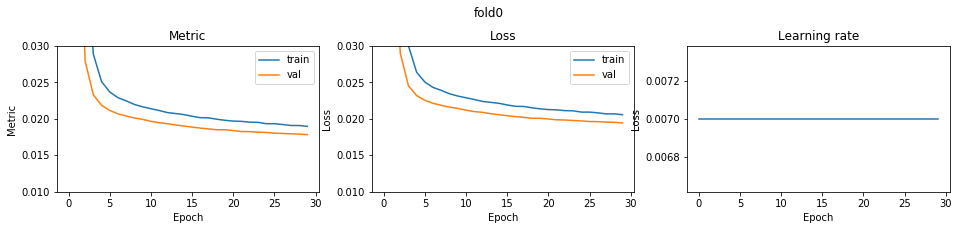

fold 1


epoch1 save best model... 0.5212504780354981
epoch2 save best model... 0.05555005452713844
epoch3 save best model... 0.02727913258202148
epoch4 save best model... 0.023006870901294003
epoch5 save best model... 0.021733712848453296
epoch6 save best model... 0.021083524987936753
epoch7 save best model... 0.02064268898510001
epoch8 save best model... 0.020420528694946555
epoch9 save best model... 0.020186735628612847
epoch10 save best model... 0.019936970603777707
epoch11 save best model... 0.019765332528774274
epoch12 save best model... 0.019631055751329514
epoch13 save best model... 0.019541700195973514
epoch14 save best model... 0.01929320939442011
epoch15 save best model... 0.01921130416757372
epoch16 save best model... 0.019093009884522047
epoch17 save best model... 0.018953510688897498
epoch18 save best model... 0.018833977739606964
epoch19 save best model... 0.018771334682198913
epoch20 save best model... 0.018648911016704853
epoch21 save best model... 0.018582870455500774
epoch22 

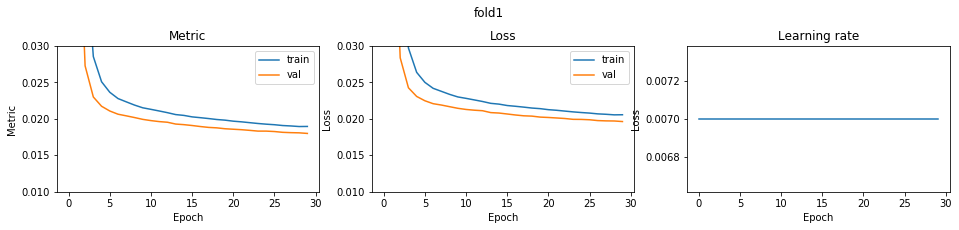

fold 2


epoch1 save best model... 0.5372198938535758
epoch2 save best model... 0.05889447869112943
epoch3 save best model... 0.027853242885325622
epoch4 save best model... 0.023375986281873207
epoch5 save best model... 0.021933104140536744
epoch6 save best model... 0.02122875048311486
epoch7 save best model... 0.020833866182255512
epoch8 save best model... 0.020494623666072822
epoch9 save best model... 0.02027695315112745
epoch10 save best model... 0.02004515885199955
epoch11 save best model... 0.019950601040780558
epoch12 save best model... 0.019678440347303695
epoch13 save best model... 0.01946231578878836
epoch14 save best model... 0.019338927021019685
epoch15 save best model... 0.01919426815616131
epoch16 save best model... 0.018997547882156032
epoch17 save best model... 0.018865653474327778
epoch18 save best model... 0.018705548865622597
epoch19 save best model... 0.018663583174823195
epoch20 save best model... 0.018559436114132744
epoch21 save best model... 0.018448568941457896
epoch22 s

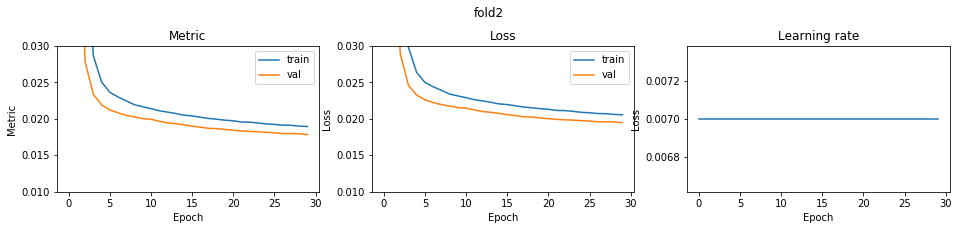

fold 3


epoch1 save best model... 0.5478344702503404
epoch2 save best model... 0.06162343028601861
epoch3 save best model... 0.028408121424546816
epoch4 save best model... 0.023671355531264548
epoch5 save best model... 0.022080898599737327
epoch6 save best model... 0.02138039069016865
epoch7 save best model... 0.02088127370949215
epoch8 save best model... 0.02059575383740229
epoch9 save best model... 0.020314116572329014
epoch10 save best model... 0.020123556929646836
epoch11 save best model... 0.019974278606016162
epoch12 save best model... 0.019842621543633504
epoch13 save best model... 0.019650315639726256
epoch14 save best model... 0.019452035581111773
epoch15 save best model... 0.019321804742725535
epoch16 save best model... 0.019135922449375748
epoch17 save best model... 0.019003955175960117
epoch18 save best model... 0.01892662891027664
epoch19 save best model... 0.018789984295590183
epoch20 save best model... 0.01876487023152564
epoch21 save best model... 0.018687132371330722
epoch22 s

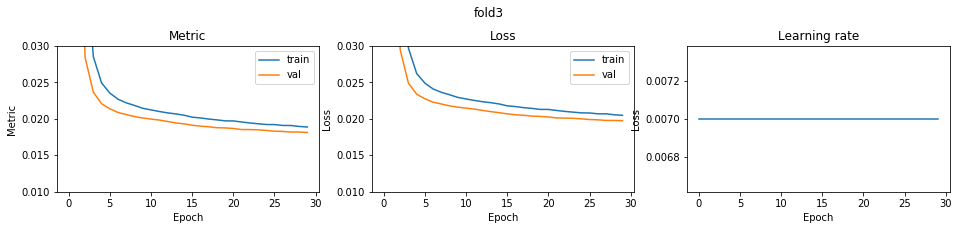

fold 4


epoch1 save best model... 0.5220718381345136
epoch2 save best model... 0.05640744684361651
epoch3 save best model... 0.027162645349028715
epoch4 save best model... 0.022988208471574654
epoch5 save best model... 0.021590407152823544
epoch6 save best model... 0.02098760406289394
epoch7 save best model... 0.020550906025976416
epoch8 save best model... 0.02035210592617071
epoch9 save best model... 0.020007434900603967
epoch10 save best model... 0.019780012315185846
epoch11 save best model... 0.01955142023640097
epoch12 save best model... 0.019434122204916353
epoch13 save best model... 0.0192869949288208
epoch14 save best model... 0.019108312809521626
epoch15 save best model... 0.018964646969643974
epoch16 save best model... 0.018860549279456802
epoch17 save best model... 0.01873613777814395
epoch18 save best model... 0.018673271451629104
epoch19 save best model... 0.01856020171628047
epoch20 save best model... 0.018479356993677132
epoch21 save best model... 0.01840984810033393
epoch22 save

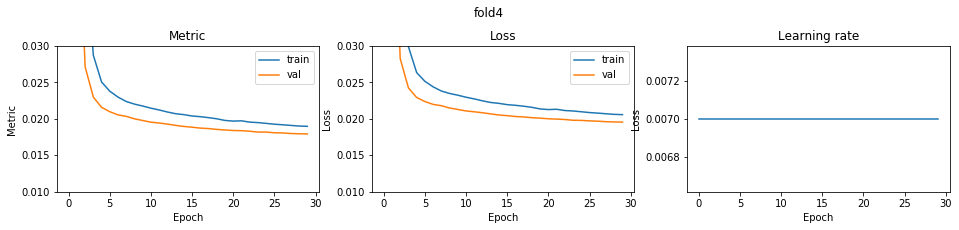

CV score: 0.017956164448258503

optimizer: SWATS
fold 0


epoch1 save best model... 0.030949482141839072
fold0 score: 0.030949482133393734


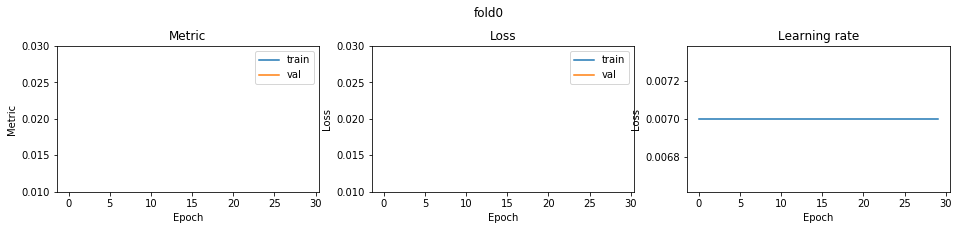

fold 1


epoch1 save best model... 0.030924024324763145
fold1 score: 0.030924024310293095


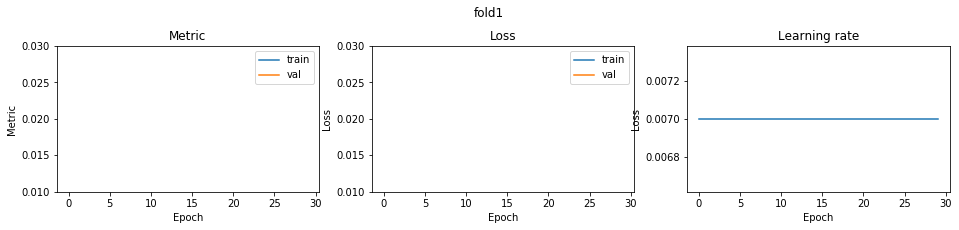

fold 2


epoch1 save best model... 0.030984309600616513
fold2 score: 0.030984309684440117


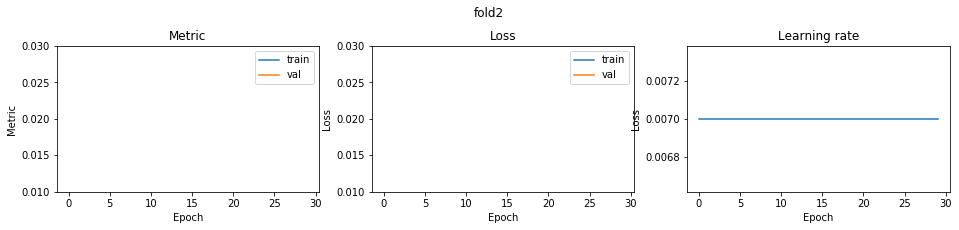

fold 3


epoch1 save best model... 0.031224634055396147
fold3 score: 0.031224633901154313


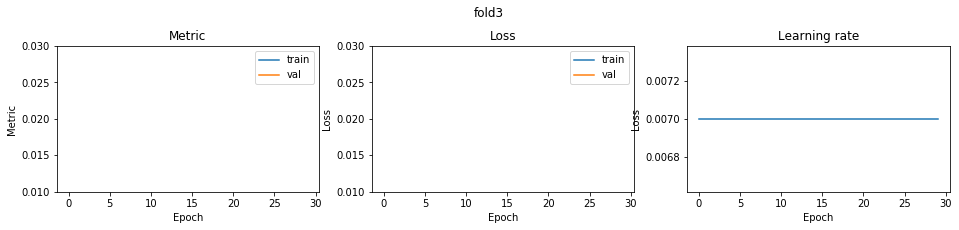

fold 4


epoch1 save best model... 0.031010999928540412
fold4 score: 0.03101099993785371


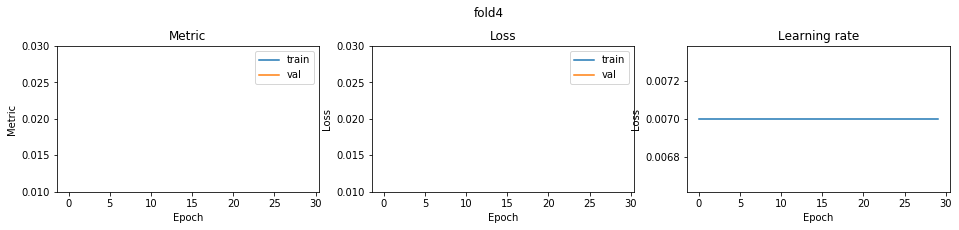

CV score: 0.031018695873051203

optimizer: Yogi
fold 0


epoch1 save best model... 0.030976858556032997
fold0 score: 0.030976858707570578


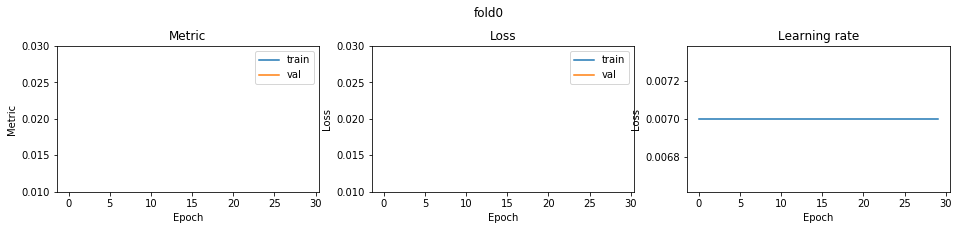

fold 1


epoch1 save best model... 0.030856467308983712
fold1 score: 0.030856467309638726


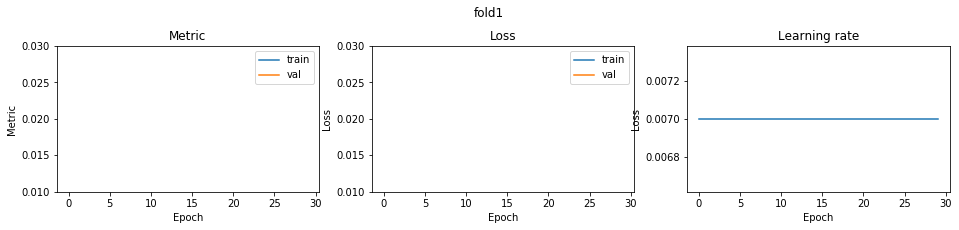

fold 2


epoch1 save best model... 0.030883529255118693
fold2 score: 0.030883529306258324


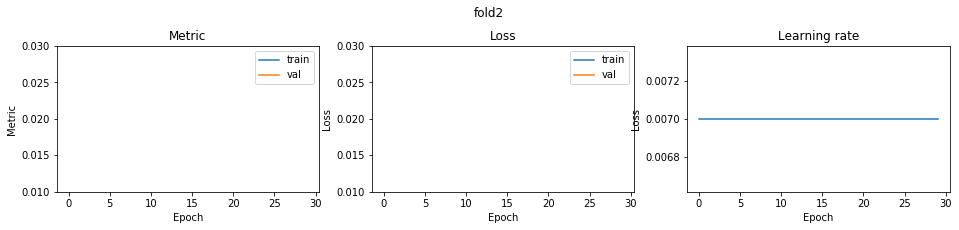

fold 3


epoch1 save best model... 0.030996299624137563
fold3 score: 0.03099629979231103


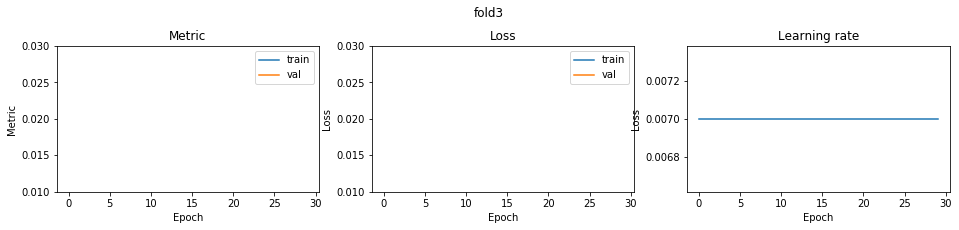

fold 4


epoch1 save best model... 0.030647546472982557
fold4 score: 0.030647546481682754


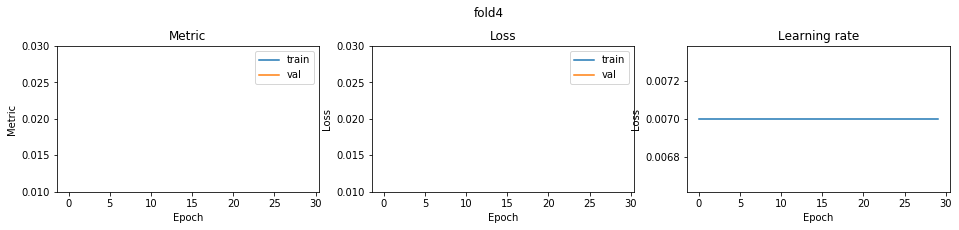

CV score: 0.030872140514681966

optimizer: Adam
fold 0


epoch1 save best model... 0.03222640225990486
epoch10 save best model... 0.03216993912019192
epoch15 save best model... 0.03216614814767941
epoch16 save best model... 0.03177606483289212
fold0 score: 0.031776064955827785


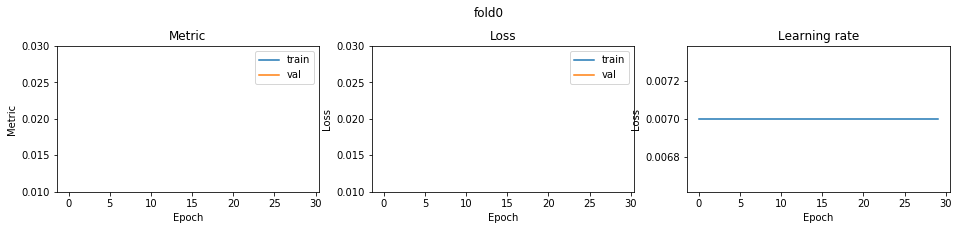

fold 1


epoch1 save best model... 0.03165653357220744
fold1 score: 0.03165653371430478


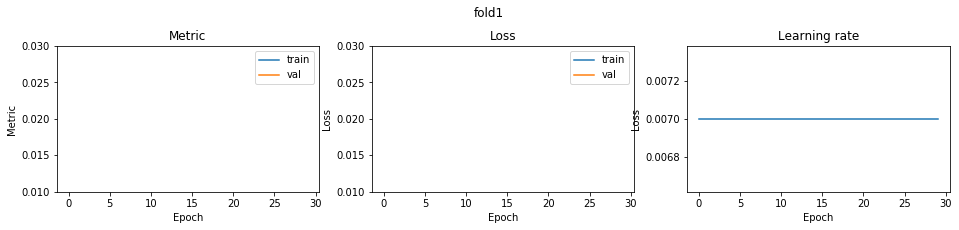

fold 2


epoch1 save best model... 0.0321320198547612
epoch6 save best model... 0.03203979382403051
epoch8 save best model... 0.032034409489829795
epoch11 save best model... 0.03186988788212342
epoch22 save best model... 0.03155769277334308
fold2 score: 0.03155769216953976


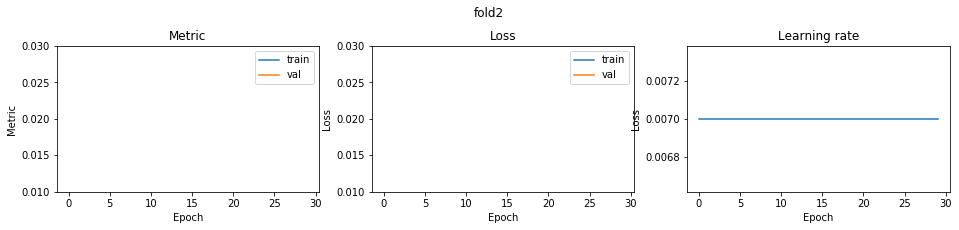

fold 3


epoch1 save best model... 0.03265498460679907
epoch6 save best model... 0.03182739435455386
fold3 score: 0.03182739445711847


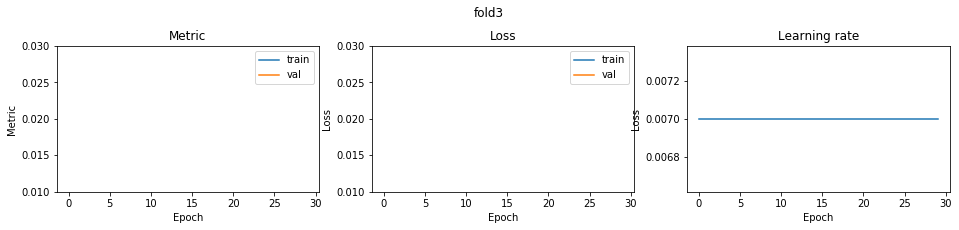

fold 4


epoch1 save best model... 0.03206155484283432
epoch6 save best model... 0.03183119719962596
epoch30 save best model... 0.03174472770278166
fold4 score: 0.031744726553025494


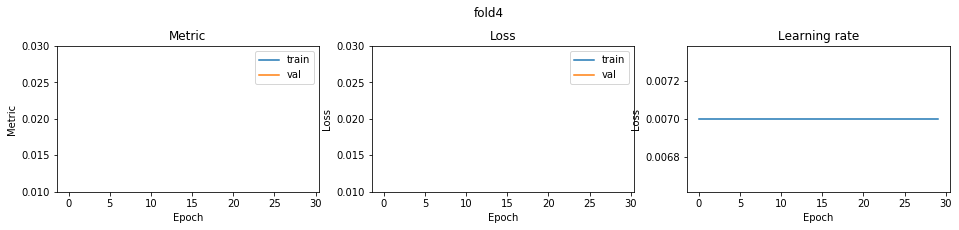

CV score: 0.031712491971697176

optimizer: LookaheadAdam
fold 0


epoch1 save best model... 0.031696494035677376
fold0 score: 0.031696494054019364


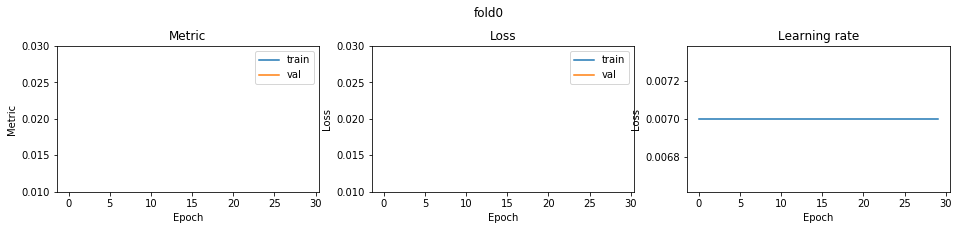

fold 1


epoch1 save best model... 0.031297361303785444
fold1 score: 0.03129736116363313


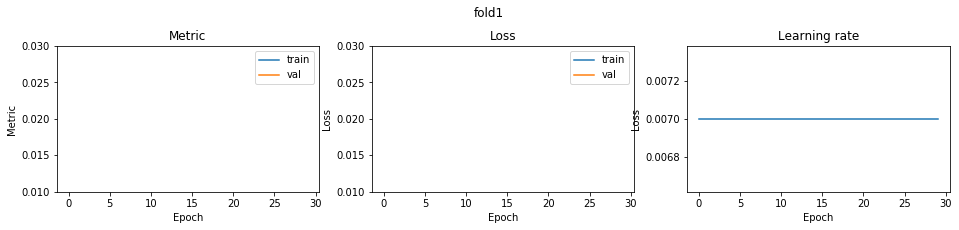

fold 2


epoch1 save best model... 0.031833347591778825
epoch9 save best model... 0.03165142763364448
fold2 score: 0.031651429021464735


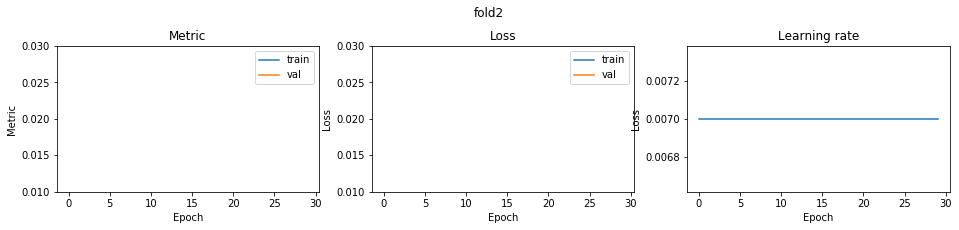

fold 3


epoch1 save best model... 0.03158166363733504
fold3 score: 0.03158166367690437


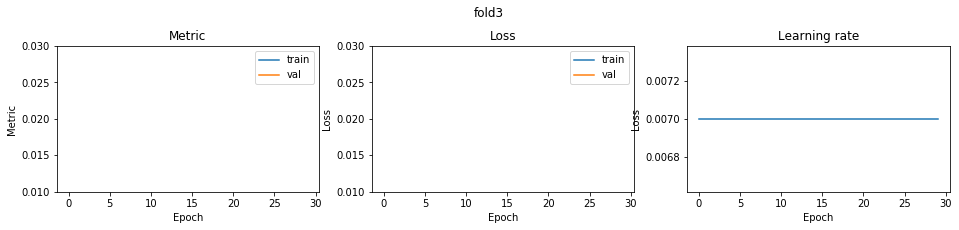

fold 4


epoch1 save best model... 0.03173027378772141
epoch7 save best model... 0.03168102075814658
fold4 score: 0.03168102165017029


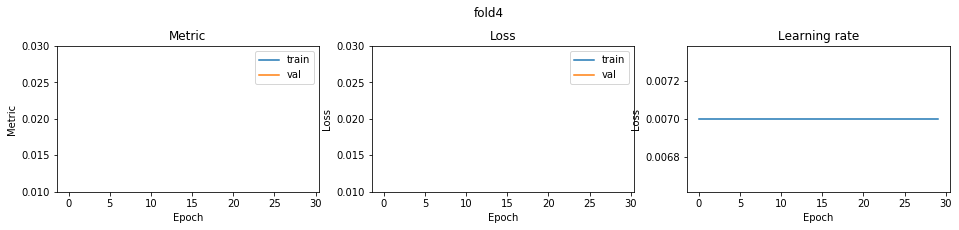

CV score: 0.031581603681674744

optimizer: LookaheadDiffGrad
fold 0


epoch1 save best model... 0.03396983799569156
epoch2 save best model... 0.031367992155746066
fold0 score: 0.03136799204780569


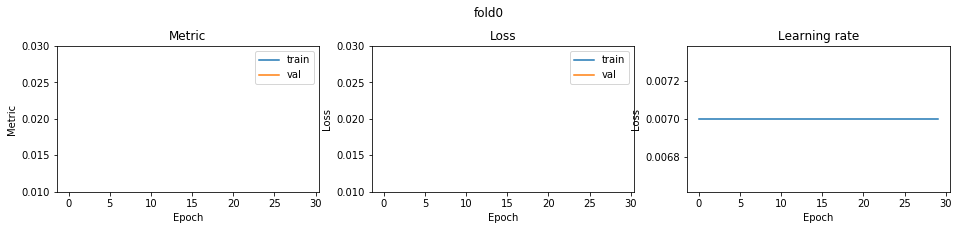

fold 1


epoch1 save best model... 0.03390459090600282
epoch2 save best model... 0.030984922578928816
fold1 score: 0.030984922601958897


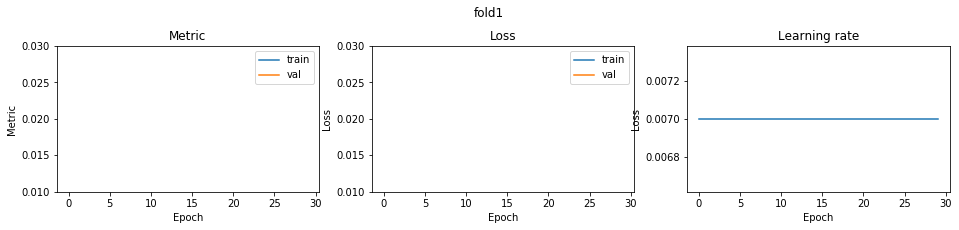

fold 2


epoch1 save best model... 0.03375345399091009
epoch2 save best model... 0.03155975852872074
fold2 score: 0.03155975851704494


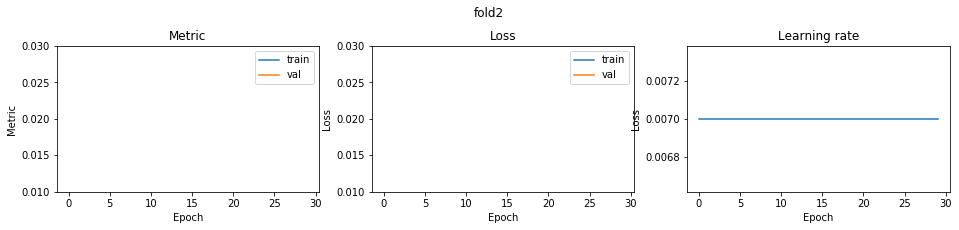

fold 3


epoch1 save best model... 0.03340815830390247
epoch2 save best model... 0.03140720594716778
fold3 score: 0.031407206066933174


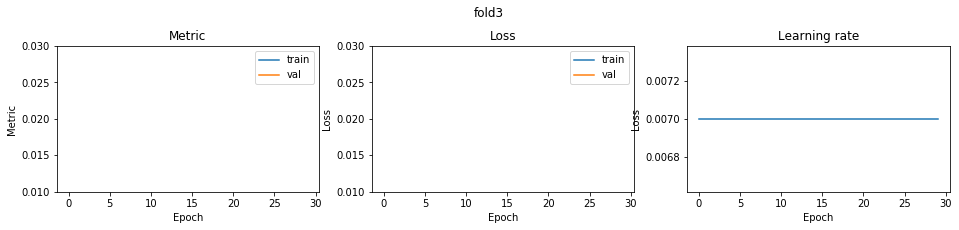

fold 4


epoch1 save best model... 0.03335265784708948
epoch2 save best model... 0.03120575209481298
fold4 score: 0.031205751899560777


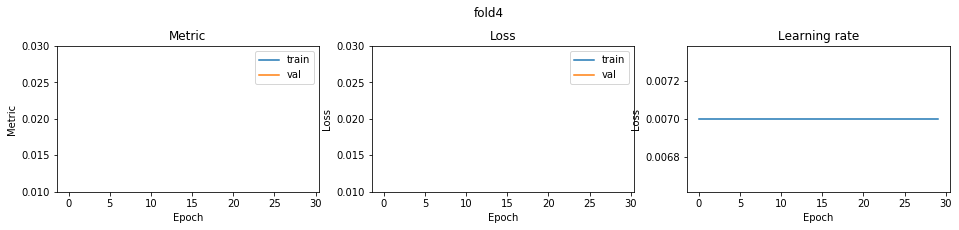

CV score: 0.031305129214237434

optimizer: LookaheadYogi
fold 0


epoch1 save best model... 0.031106319779144062
epoch2 save best model... 0.030867578548321964
fold0 score: 0.03086757866019684


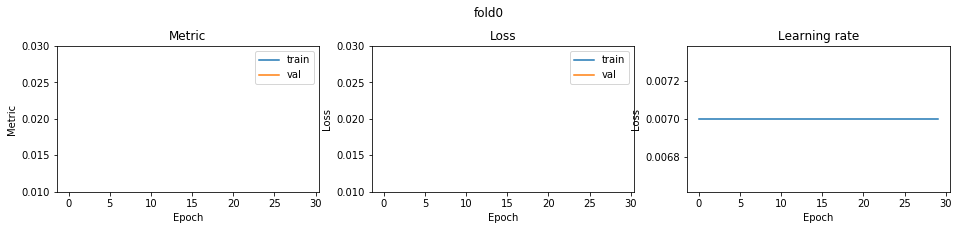

fold 1


epoch1 save best model... 0.03150636162867739
epoch2 save best model... 0.030826001334914206
fold1 score: 0.03082600124054803


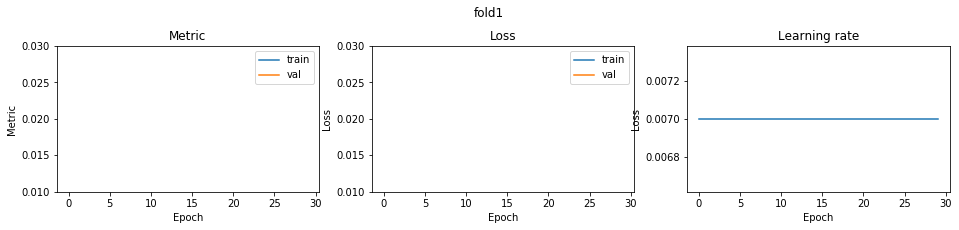

fold 2


epoch1 save best model... 0.030944877444397455
epoch2 save best model... 0.030781434642226962
fold2 score: 0.030781434497139583


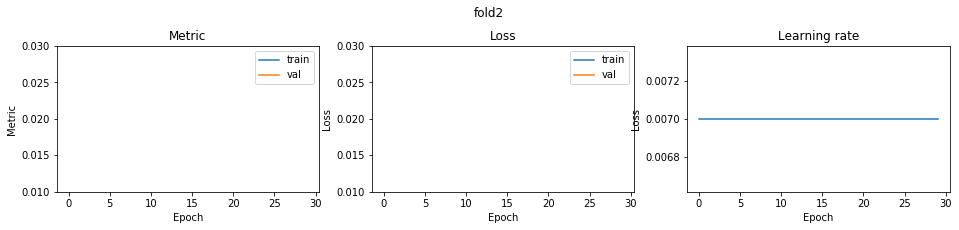

fold 3


epoch1 save best model... 0.030703602031993432
fold3 score: 0.03070360205702401


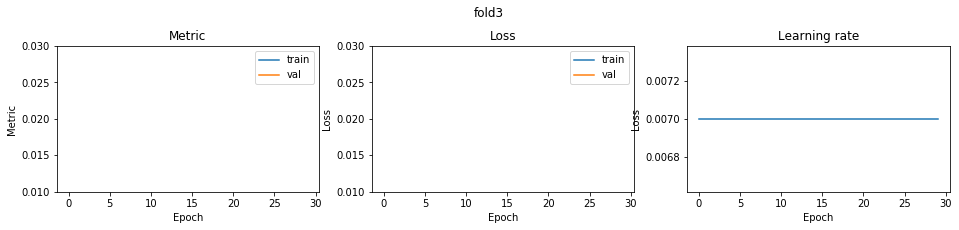

fold 4


epoch1 save best model... 0.03110489386445705
epoch2 save best model... 0.030676167997147608
fold4 score: 0.030676168037109167


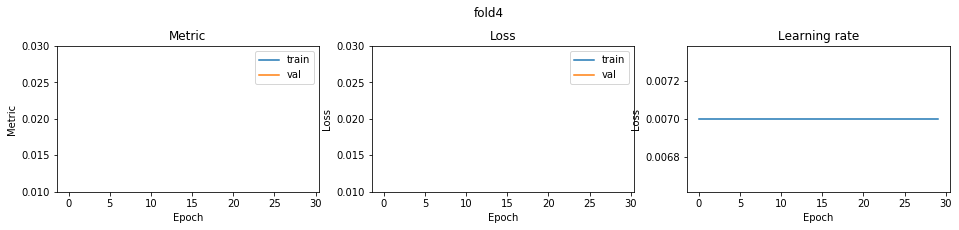

CV score: 0.03077095391307726

optimizer: RangerLars
fold 0


epoch1 save best model... 0.02181580820564257
epoch2 save best model... 0.01987175851602082
epoch3 save best model... 0.018634567189121574
epoch4 save best model... 0.018096433600287773
epoch5 save best model... 0.01760525708861123
epoch6 save best model... 0.017254156338428583
epoch7 save best model... 0.01709772414169306
epoch8 save best model... 0.016931903874819805
epoch9 save best model... 0.016796773633917534
epoch10 save best model... 0.016591116796186137
epoch11 save best model... 0.016507139095955938
epoch12 save best model... 0.016408585544870763
epoch13 save best model... 0.016327800457036985
epoch14 save best model... 0.01630281792754193
epoch15 save best model... 0.016267408167514822
epoch16 save best model... 0.01622532475188137
epoch18 save best model... 0.01618209486797554
fold0 score: 0.016182094725831802


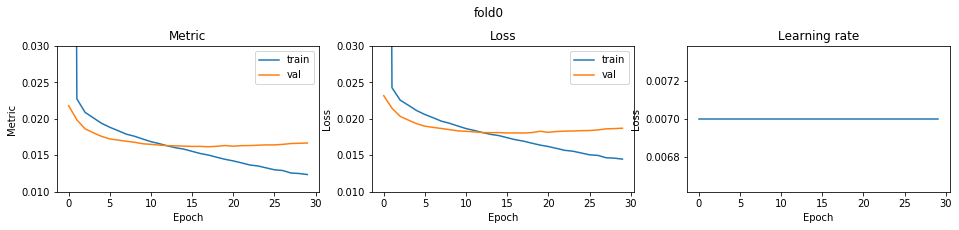

fold 1


epoch1 save best model... 0.021952330429971856
epoch2 save best model... 0.019900696248148806
epoch3 save best model... 0.0189337394329492
epoch4 save best model... 0.018373512051614225
epoch5 save best model... 0.017933682388122926
epoch6 save best model... 0.017544474866513674
epoch7 save best model... 0.017483895754886805
epoch8 save best model... 0.017164654698749966
epoch9 save best model... 0.016995478763083143
epoch10 save best model... 0.016927485369310533
epoch11 save best model... 0.016811782949981587
epoch12 save best model... 0.016699978966315993
epoch13 save best model... 0.01663906707312325
epoch14 save best model... 0.01659036882766615
epoch19 save best model... 0.016589950432537914
fold1 score: 0.016589950402643706


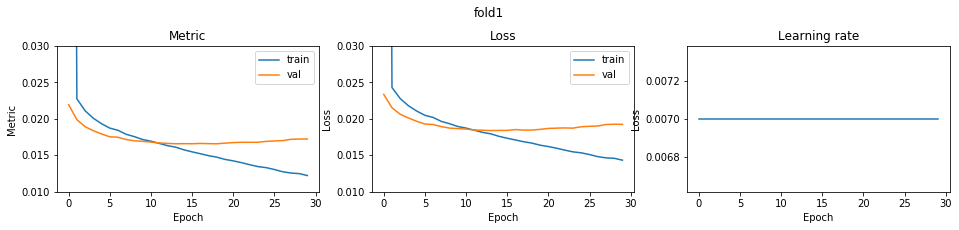

fold 2


epoch1 save best model... 0.02203223200404147
epoch2 save best model... 0.019895588389223735
epoch3 save best model... 0.019132897246346356
epoch4 save best model... 0.018241317852555783
epoch5 save best model... 0.017819924580090733
epoch6 save best model... 0.017409934341656264
epoch7 save best model... 0.017165867509063622
epoch8 save best model... 0.0169695157898935
epoch9 save best model... 0.01678355817493551
epoch10 save best model... 0.016765018414530295
epoch11 save best model... 0.016669055908718068
epoch12 save best model... 0.016518103126856618
epoch13 save best model... 0.016455947159430682
epoch15 save best model... 0.016396169143939623
epoch16 save best model... 0.01635933220900016
epoch19 save best model... 0.016315113463646787
fold2 score: 0.016315113497539984


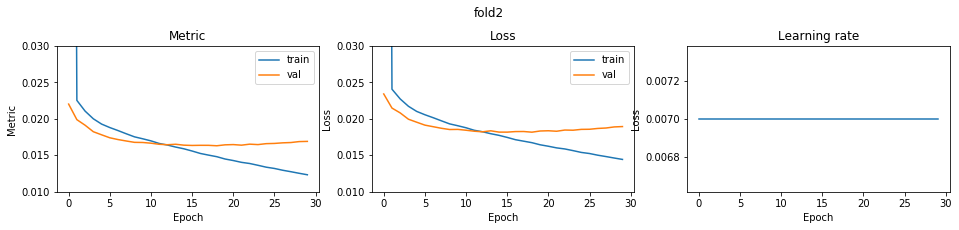

fold 3


epoch1 save best model... 0.021794296258844114
epoch2 save best model... 0.019880566462993216
epoch3 save best model... 0.01878377835951525
epoch4 save best model... 0.018466741377848428
epoch5 save best model... 0.01782619670958413
epoch6 save best model... 0.01764764935923804
epoch7 save best model... 0.017480132918473935
epoch8 save best model... 0.017258083138504576
epoch9 save best model... 0.01709230149457558
epoch10 save best model... 0.016928819362031708
epoch11 save best model... 0.01688091492997419
epoch12 save best model... 0.01670620795169629
epoch13 save best model... 0.01664798714152637
epoch15 save best model... 0.01663498570103037
epoch16 save best model... 0.01649459219412509
fold3 score: 0.01649459210564189


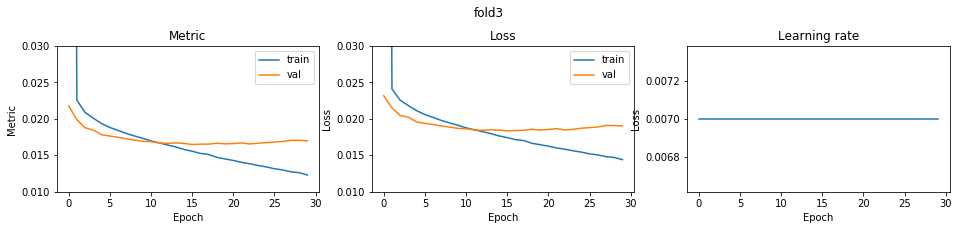

fold 4


epoch1 save best model... 0.021700651576246108
epoch2 save best model... 0.01970738922935276
epoch3 save best model... 0.018471792442533178
epoch4 save best model... 0.017960669321341098
epoch5 save best model... 0.017685249073172076
epoch6 save best model... 0.0174094672384831
epoch7 save best model... 0.0171992373166941
epoch8 save best model... 0.017133777926767197
epoch9 save best model... 0.016910597212307137
epoch10 save best model... 0.016849699190017983
epoch11 save best model... 0.016829287854356348
epoch12 save best model... 0.01667495276100068
epoch13 save best model... 0.01664002265034409
epoch15 save best model... 0.016471905472151646
epoch18 save best model... 0.016435537185596306
fold4 score: 0.016435537026758474


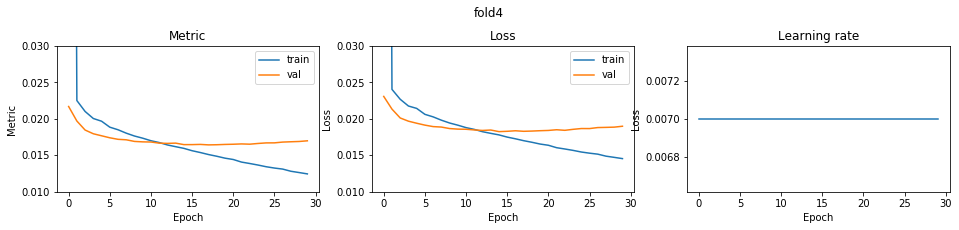

CV score: 0.01640345307980433


In [26]:
score_dict = {}

for optimizer in optim_list:
    CFG.optimizer = optimizer
    logger.info('')
    logger.info('optimizer: '+ optimizer.__name__)
    oof, predictions = run_kfold_nn(CFG,
                                    trn_df,
                                    test_df,
                                    CFG.feature_cols,
                                    CFG.target_cols,
                                    n_fold=5)

    # OOF score without 'ctl_vehicle'
    ys = trn_df[y_keys]
    preds = oof

    score = compute_metric(preds, ys)
    score_dict[optimizer.__name__] = score

In [27]:
score_dict

{'Adam_CG': 0.031599344861094676,
 'AdamW_CG': 0.016505942199280622,
 'PlainRAdam_CG': 0.018830631696300067,
 'RAdam_CG': 0.01654688466322071,
 'Ranger_CG': 0.01648640966054874,
 'AggMo': 0.03006905345305123,
 'Apollo': 0.1559558860657513,
 'PID': 0.15903969961974412,
 'QHM': 0.16057157501137928,
 'SGDP': 0.1621888185333763,
 'SGDW': 0.05505144858141185,
 'SGD': 0.16226609111624665,
 'AdaBelief': 0.016516349607616162,
 'AdaBound': 0.030475275371797513,
 'AdaMod': 0.01651574691390649,
 'AdamW': 0.01650972780321599,
 'AdamP': 0.016464705273118864,
 'DiffGrad': 0.03137748618649447,
 'Lamb': 0.01649835465140455,
 'NovoGrad': 0.016504525038244556,
 'PlainRAdam': 0.01650403007741471,
 'QHAdam': 0.03160224033162295,
 'RAdam': 0.016516607579948325,
 'Ranger': 0.016452015542639333,
 'RangerQH': 0.0315259038283187,
 'RangerVA': 0.017956164448258455,
 'SWATS': 0.031018695873051345,
 'Yogi': 0.03087214051468181,
 'Adam': 0.03171249197169808,
 'LookaheadAdam': 0.03158160368167613,
 'LookaheadDiffGr

In [28]:
pd.DataFrame.from_dict(score_dict, columns=['metric'], orient='index')

metric
Adam_CG            0.031599
AdamW_CG           0.016506
PlainRAdam_CG      0.018831
RAdam_CG           0.016547
Ranger_CG          0.016486
AggMo              0.030069
Apollo             0.155956
PID                0.159040
QHM                0.160572
SGDP               0.162189
SGDW               0.055051
SGD                0.162266
AdaBelief          0.016516
AdaBound           0.030475
AdaMod             0.016516
AdamW              0.016510
AdamP              0.016465
DiffGrad           0.031377
Lamb               0.016498
NovoGrad           0.016505
PlainRAdam         0.016504
QHAdam             0.031602
RAdam              0.016517
Ranger             0.016452
RangerQH           0.031526
RangerVA           0.017956
SWATS              0.031019
Yogi               0.030872
Adam               0.031712
LookaheadAdam      0.031582
LookaheadDiffGrad  0.031305
LookaheadYogi      0.030771
RangerLars         0.016403

In [29]:
logger.info(pd.DataFrame.from_dict(score_dict, columns=['metric'], orient='index'))

                     metric
Adam_CG            0.031599
AdamW_CG           0.016506
PlainRAdam_CG      0.018831
RAdam_CG           0.016547
Ranger_CG          0.016486
AggMo              0.030069
Apollo             0.155956
PID                0.159040
QHM                0.160572
SGDP               0.162189
SGDW               0.055051
SGD                0.162266
AdaBelief          0.016516
AdaBound           0.030475
AdaMod             0.016516
AdamW              0.016510
AdamP              0.016465
DiffGrad           0.031377
Lamb               0.016498
NovoGrad           0.016505
PlainRAdam         0.016504
QHAdam             0.031602
RAdam              0.016517
Ranger             0.016452
RangerQH           0.031526
RangerVA           0.017956
SWATS              0.031019
Yogi               0.030872
Adam               0.031712
LookaheadAdam      0.031582
LookaheadDiffGrad  0.031305
LookaheadYogi      0.030771
RangerLars         0.016403


In [30]:
sort_dict = {k: v for k, v in sorted(score_dict.items(), key=lambda x: x[1])}

In [31]:
pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index')

metric
RangerLars         0.016403
Ranger             0.016452
AdamP              0.016465
Ranger_CG          0.016486
Lamb               0.016498
PlainRAdam         0.016504
NovoGrad           0.016505
AdamW_CG           0.016506
AdamW              0.016510
AdaMod             0.016516
AdaBelief          0.016516
RAdam              0.016517
RAdam_CG           0.016547
RangerVA           0.017956
PlainRAdam_CG      0.018831
AggMo              0.030069
AdaBound           0.030475
LookaheadYogi      0.030771
Yogi               0.030872
SWATS              0.031019
LookaheadDiffGrad  0.031305
DiffGrad           0.031377
RangerQH           0.031526
LookaheadAdam      0.031582
Adam_CG            0.031599
QHAdam             0.031602
Adam               0.031712
SGDW               0.055051
Apollo             0.155956
PID                0.159040
QHM                0.160572
SGDP               0.162189
SGD                0.162266

In [32]:
logger.info(pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index'))

                     metric
RangerLars         0.016403
Ranger             0.016452
AdamP              0.016465
Ranger_CG          0.016486
Lamb               0.016498
PlainRAdam         0.016504
NovoGrad           0.016505
AdamW_CG           0.016506
AdamW              0.016510
AdaMod             0.016516
AdaBelief          0.016516
RAdam              0.016517
RAdam_CG           0.016547
RangerVA           0.017956
PlainRAdam_CG      0.018831
AggMo              0.030069
AdaBound           0.030475
LookaheadYogi      0.030771
Yogi               0.030872
SWATS              0.031019
LookaheadDiffGrad  0.031305
DiffGrad           0.031377
RangerQH           0.031526
LookaheadAdam      0.031582
Adam_CG            0.031599
QHAdam             0.031602
Adam               0.031712
SGDW               0.055051
Apollo             0.155956
PID                0.159040
QHM                0.160572
SGDP               0.162189
SGD                0.162266


In [33]:
pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index').to_csv(nb_name[:-6]+'.csv')